# Cellular Deconvolution Notebook

author: Simon Lee (slee@celsiustx.com)

You will need to install the following methods to properly use this notebook 

- [cellanneal](https://github.com/LiBuchauer/cellanneal)
- [Kassandra](https://github.com/BostonGene/Kassandra)

These repos can be cloned inside the "source" folder for usability. The structure below demonstrates what I mean:

src</br>
|_ cellanneal </br>
|_ Kassandra </br>
|_ master_deconvolution.ipynb</br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

# import deconvolution methods
import cellanneal
from core.mixer import Mixer 
from core.cell_types import CellTypes
from core.model import DeconvolutionModel
from core.plotting import print_cell_matras, cells_p, print_all_cells_in_one
from core.utils import *
from scipy.optimize import nnls
from sklearn.svm import NuSVR
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler

#import plotting configs
import project_configs as project_configs

# statistical tests
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from tqdm import tqdm

In [2]:
# plot parameters all coming from project.configurations
plt.style.use(project_configs.style)
plt.rcParams['font.family'] = project_configs.font_family
plt.rcParams['font.serif'] = project_configs.font_serif
plt.rcParams['font.monospace'] = project_configs.font_monospace
plt.rcParams['font.size'] = project_configs.font_size
plt.rcParams['axes.labelsize'] = project_configs.axes_label_size
plt.rcParams['axes.labelweight'] = project_configs.axes_label_weight
plt.rcParams['axes.titlesize'] = project_configs.axes_title_size
plt.rcParams['xtick.labelsize'] = project_configs.xtick_label_size
plt.rcParams['ytick.labelsize'] = project_configs.ytick_label_size
plt.rcParams['legend.fontsize'] = project_configs.legend_font_size 
plt.rcParams['figure.titlesize'] = project_configs.figure_title_size
plt.rcParams['image.cmap'] = project_configs.image_cmap 
plt.rcParams['image.interpolation'] = project_configs.image_interpolation 
plt.rcParams['figure.figsize'] = project_configs.figure_size
plt.rcParams['axes.grid']=project_configs.axes_grid
plt.rcParams['lines.linewidth'] = project_configs.lines_line_width
plt.rcParams['lines.markersize'] = project_configs.lines_marker_size

In [3]:
cells_p = {'B_cells': '#558ce0',
                'CD4_T_cells': '#28a35c',
                'CD8_T_cells': '#58d3bb',
                'Dendritic_cells': '#eaabcc',
                'Endothelium': '#F6783E',
                'Fibroblasts': '#a3451a',
                'Macrophages': '#d689b1',
                'Monocytes': '#ad4f80',
                'NK_cells': '#61cc5b',
                'Neutrophils': '#FCB586',
                'T_cells': '#808000',
                'Other': '#999999',
                'Immune_general': '#4f80ad',
                'Monocytic_cells': '#61babf',
                'Lymphocytes': '#5e9e34',
                'Plasma_B_cells': '#29589e',
                'Non_plasma_B_cells': '#248ce0',
                'Granulocytes': '#FCB511',
                'Basophils': '#fa7005',
                'Eosinophils': '#aaB586',
                'Naive_CD4_T_cells': '#bf8f0f',
                'Memory_CD4_T_cells': '#0f8f0f',
                'Memory_B_cells': '#55afe0',
                'Naive_CD8_T_cells': '#8FBC8F',
                'Memory_CD8_T_cells': '#8FBCFF',
                'Naive_B_cells': '#558cff'}

### Defined some methods for statistical testing

I will eventuall put these all in .py files for better organization

In [4]:
class statsTest():
    '''
    class that performs all statistical test for the deconvolution methods
    '''
    def rmse(self, predicted_values, true_values):
        '''
        A module that calculates the Root mean squared error
        '''
        rms = mse(true_values, predicted_values, squared=False)
        return rms
        
    def correlation(self,predicted_values, true_values, p = False):
        '''
        A module that calculates the pearson correlation coefficient
        '''
        corrcoef, pval = pearsonr(predicted_values, true_values)
        corrcoef = str(round(corrcoef, 3))

        if p:
            pval = str(round(pval, 3))
            return pval
        
        return corrcoef

    def Pvalue(self,predicted_values, true_values):
        '''
        A module that calculates the P value
        '''
        pval = self.correlation(predicted_values,true_values,p=True)
        return pval
        
    def R_squared(self, predicted_values, true_values):
        '''
        A module that calculates the R squared value
        '''
        r2 = r2_score(true_values, predicted_values)
        return r2
    
    def test(self, predicted_values, true_values):
        '''
        Runs all statistical tests in one
        '''
        Rmse = self.rmse(predicted_values, true_values)
        Corr = self.correlation(predicted_values, true_values)
        Pval = self.Pvalue(predicted_values, true_values)
        R2 = self.R_squared(predicted_values, true_values)
        print("Statistical Tests\n------------------------\nRMSE:",round(Rmse,3), "\nPearson Correlation Coefficient:", round(float(Corr),3), "\nP value:",float(Pval),"\nR^2:", round(R2,3))
        return round(Rmse,3), round(float(Corr),3), round(float(Pval),3), round(R2,3)


### Defined some methods for plotting

In [205]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

class Plot():
    '''
    class that performs plotting features for better analysis of results
    '''

    def stack_plot(self,df):
        '''
        stack plots to visualize the cellular composition 
        '''
        corr_list = []
        if 'rho_Spearman' in df.columns:
            corr_list.append('rho_Spearman')
        if 'rho_Pearson' in df.columns:
            corr_list.append('rho_Pearson')
        if len(corr_list) > 0:
            df = df.drop(corr_list, axis=1)
        else:
            df = df
        df.plot(kind='bar', stacked=True)
        plt.title("Cell Deconvolutions")
        plt.xlabel("Bulk Sample ID")
        plt.ylabel("Cell type Proportions (%)")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    def heat_map(self,mix_df):
        '''
        Heat Map representation of the cell proportion. Very elegant compared to stack plots
        '''
        corr_list = []
        if 'rho_Spearman' in mix_df.columns:
            corr_list.append('rho_Spearman')
        if 'rho_Pearson' in mix_df.columns:
            corr_list.append('rho_Pearson')
        if len(corr_list) > 0:
            plot_df = mix_df.drop(corr_list, axis=1)
        else:
            plot_df = mix_df
        fig, ax = plt.subplots(
        figsize=(10/np.shape(mix_df)[1]*np.shape(mix_df)[0],
                    0.5*np.shape(mix_df)[1]))
        # removing correlation coefficients from df
        corr_list = []
        if 'rho_Spearman' in mix_df.columns:
            corr_list.append('rho_Spearman')
        if 'rho_Pearson' in mix_df.columns:
            corr_list.append('rho_Pearson')
        if len(corr_list) > 0:
            plot_df = mix_df.drop(corr_list, axis=1)
        else:
            plot_df = mix_df
        
        # plott

        ax = sns.heatmap(plot_df.T.sort_index(0),
                        linewidths=.5, square=True, cmap='viridis',
                        cbar_kws={'shrink': 0.7, 'label': 'fraction'})
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

        bottom, top = ax.get_ylim()
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        ax.invert_yaxis()
        plt.title("Cell Deconvolutions")
        plt.xlabel("Bulk Sample ID")
        plt.ylabel("Cell types")
        #plt.savefig('', bbox_inches='tight')

    def corr_plot(self, predicted_values, true_values, figsize=(24, 24), pallete=None):
        '''
        Author: Kassandra
        '''
        ind_names = predicted_values.index.intersection(true_values.index)
        col_names = predicted_values.columns.intersection(true_values.columns)
        predicted_values = predicted_values.loc[ind_names, col_names]
        true_values = true_values.loc[ind_names, col_names]

        if len(ind_names) < 4:
            num_ncols = len(ind_names)
        else:
            num_ncols = 4

        num_nrows = (len(ind_names) - 1) // 6 + 1
        
        figsize = (figsize[0], figsize[0] * num_nrows / num_ncols)

        fig, axs = plt.subplots(num_nrows, num_ncols, figsize=figsize)
        #fig.set_title("Correlation of predicted and real percentage of cells", fontsize=20)
        fig.tight_layout()
        fig.subplots_adjust(top=0.91, wspace=0.4, hspace=0.4)

        
        ordered_names = ind_names.sort_values()

        for ax, cell in zip(axs.flat, ordered_names):
            
            sub_title = cell
            if cell in pallete:
                colors = pallete[cell]
            else:
                colors = '#999999'
            self.print_cell(predicted_values.loc[cell], true_values.loc[cell], ax=ax,title=sub_title, pallete=pallete, color = colors)

        return axs

    def print_cell(self, predicted_values, true_values, ax=None, pallete=None, single_color='#999999',
                predicted_name='Predicted percentage of cells, %',
                true_name='Real percentage of cells, %', title=None, corr_title=True, corr_rounding=3,
                figsize=(6, 6), s=60, title_font=20, labels_font=18, ticks_size=17, xlim=None, ylim=None,
                corr_line=True, linewidth=1, line_color='black', pad=15, min_xlim=0.1, min_ylim=0.1, labelpad=None, color = None):
        """
        Author: Kassandra
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        ind_points = true_values.dropna().index.intersection(predicted_values.dropna().index)
        ax.grid(b=False)
        predicted_values = predicted_values.loc[ind_points].astype(float)
        true_values = true_values.loc[ind_points].astype(float)
        if corr_title:
            corrcoef, pval = pearsonr(predicted_values, true_values)
            corrcoef = str(round(corrcoef, corr_rounding))
            pval = str(round(pval, 3))
            if title is not None:
                ax.set_title('{title}, corr = {corr}\np = {p}'.format(title=title,
                                                                    corr=corrcoef,
                                                                    p=pval),
                            size=title_font, pad=pad)
            else:
                ax.set_title('Corr = {corr}\np = {p}'.format(corr=corrcoef,
                                                            p=pval),
                            size=title_font, pad=pad)
        elif title is not None:
            ax.set_title(title, size=title_font, pad=pad)
        ax.set_xlabel(predicted_name, size=labels_font, labelpad = labelpad)
        ax.set_ylabel(true_name, size=labels_font, labelpad = labelpad)
        ax.tick_params(labelsize=ticks_size)

        ax.set_xlim(-0.5, max(1.2 * max(predicted_values), min_xlim))
        ax.set_ylim(-0.5, max(1.2 * max(true_values), min_ylim))

        if single_color != '#999999':
            ax.scatter(predicted_values, true_values, s=s, c=single_color)
        else:
            ax.scatter(predicted_values, true_values, s=s, c=color)

        if corr_line:
            self.print_fitted_line(predicted_values, true_values, ax=ax, linewidth=linewidth, line_color=line_color)

        return ax
    
    def print_fitted_line(self, x_values, y_values, ax=None, linewidth=1, line_color='black', figsize=(6, 6)):
        """
        Author: Kassandra
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        fit_coefs = np.polyfit(x_values, y_values, deg=1)
        fit_values = np.sort(x_values)
        ax.plot(fit_values, fit_coefs[0] * fit_values + fit_coefs[1], linewidth=linewidth, color=line_color)

        return ax
    
    def print_cell_whole(self, predicted_values, true_values, ax=None, pallete=None, single_color='#999999',
                           colors_by='index', predicted_name='Predicted percentage of cells, %',
                           true_name='Real percentage of cells, %', 
                           title=None, stat=True,
                           corr_rounding=3, figsize=(8, 8), s=50, title_font=20,
                           labels_font=20, ticks_size=17, xlim=None, ylim=None,
                           corr_line=True, linewidth=1, line_color='black', pad=15, min_xlim=10, min_ylim=10):
        '''
        Author: Kassandra
        '''
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        ind_names = predicted_values.index.intersection(true_values.index)
        col_names = predicted_values.columns.intersection(true_values.columns)
        predicted_values = predicted_values.loc[ind_names, col_names]
        true_values = true_values.loc[ind_names, col_names]
        ravel_predicted = pd.Series(predicted_values.values.ravel()).dropna()
        ravel_true = pd.Series(true_values.values.ravel()).dropna()
        ravel_ind = ravel_predicted.index.intersection(ravel_true.index)
        ravel_predicted = ravel_predicted.loc[ravel_ind].astype(float)
        ravel_true = ravel_true.loc[ravel_ind].astype(float)
        if xlim is None:
            xlim = (0, max(1.2 * max(ravel_predicted), min_xlim))
        if ylim is None:
            ylim = (0, max(1.2 * max(ravel_true), min_ylim))
        
        if not title:
            title = ''
        
        if stat:
            stats = statsTest()
            rmse, corr, p, r2 = stats.test(ravel_predicted.loc[ravel_ind], ravel_true.loc[ravel_ind])
        
        ax.set_title(title, size=title_font, pad=pad)

        for col in col_names:
            if colors_by == 'index':
                ax_pallete = pallete
                ax_single_color = single_color
            elif col in pallete:
                ax_pallete = None
                ax_single_color = pallete[col]
            else:
                ax_pallete = None
                ax_single_color = single_color

            self.print_cell(predicted_values[col], true_values[col], ax=ax, pallete=ax_pallete, single_color=ax_single_color,
                    predicted_name=predicted_name, true_name=true_name, corr_title=False, s=s, labels_font=labels_font,
                    ticks_size=ticks_size, xlim=xlim, ylim=ylim, corr_line=False)
        if corr_line:
            self.print_fitted_line(ravel_predicted, ravel_true, ax=ax, linewidth=linewidth, line_color=line_color)

        if stat:  
            bbox = dict(boxstyle ="round", fc ="0.8")
            ax.annotate('Statistical Tests:\nRMSE: %.2f\nPears Corr: %.2f\nP value: %.2f\nR^2: %.2f' % (rmse,corr,p,r2), xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom', bbox = bbox)

        return ax

    def bland_altman(self, predicted_values, true_values, figsize=(24, 24), pallete=None):
        '''
        Author: Simon Lee

        plots residuals
        '''
        
        ind_names = predicted_values.index.intersection(true_values.index)
        col_names = predicted_values.columns.intersection(true_values.columns)
        predicted_values = predicted_values.loc[ind_names, col_names]
        true_values = true_values.loc[ind_names, col_names]

        if len(ind_names) < 4:
            num_ncols = len(ind_names)
        else:
            num_ncols = 4

        num_nrows = (len(ind_names) - 1) // 6 + 1
        
        figsize = (figsize[0], figsize[0] * num_nrows / num_ncols)
        fig, axs = plt.subplots(num_nrows, num_ncols, figsize=figsize)
        #fig.set_title("Correlation of predicted and real percentage of cells", fontsize=20)
        fig.tight_layout()
        fig.subplots_adjust(top=0.91, wspace=0.4, hspace=0.4)

        
        ordered_names = ind_names.sort_values()
        for ax, cell in zip(axs.flat, ordered_names):
            
            sub_title = cell
            if cell in pallete:
                colors = pallete[cell]
            else:
                colors = '#999999'
            
            self.bland_altman2(predicted_values.loc[cell], true_values.loc[cell], ax=ax,title=sub_title, color = colors)

        return axs

    def bland_altman2(self, predicted_values, true_values, ax=None, pallete=cells_p, single_color='#999999',
                predicted_name='Average (%), (pred+true)/2',
                true_name='Difference (%) (pred-true)', title=None, corr_title=True, corr_rounding=3,
                figsize=(6, 6), s=60, title_font=15, labels_font=12, ticks_size=17, xlim=None, ylim=None,
                corr_line=True, linewidth=1, line_color='black', pad=15, min_xlim=0.1, min_ylim=0.1, labelpad=None, color = None):
        '''
        Author: Simon Lee

        bland altman helper function
        '''


        ind_points = true_values.dropna().index.intersection(predicted_values.dropna().index)
        ax.grid(b=False)
        predicted_values = predicted_values.loc[ind_points].astype(float)
        true_values = true_values.loc[ind_points].astype(float)

        # so the percentages line up

        df = pd.merge(predicted_values, true_values, left_index=True, right_index=True)
        indices = df.columns
        df['diff'] = df[indices[0]] - df[indices[1]]
        df['avg'] = (df[indices[0]] + df[indices[1]])/2

        title = 'Bland Altman of ' + title + ': {' + str(round(df['diff'].mean(),3)) + ' +/- ' + str(round(df['diff'].std(),3)) + '}'

        ax.set_title(title, size=title_font, pad=pad)
        ax.set_xlabel(predicted_name, size=labels_font, labelpad = labelpad)
        ax.set_ylabel(true_name, size=labels_font, labelpad = labelpad)
        ax.tick_params(labelsize=ticks_size)

        maximum = max(1.2 * max(predicted_values), min_xlim)

        ax.set_xlim(-0.5,maximum*1.5)
        ax.set_ylim(df['diff'].mean() -4* df['diff'].std(),df['diff'].mean() + 3* df['diff'].std())
        
        ax.scatter(df['avg'], df['diff'], s=s, c=color)

        # plot mean lines and std deviations
        ax.axhline(df['diff'].mean(), c='#000000')
        ax.axhline(df['diff'].mean() + 2* df['diff'].std(), ls='--', c='#000000')
        ax.axhline(df['diff'].mean() + df['diff'].std(), ls='dashdot', c='#000000')
        ax.axhline(df['diff'].mean() - df['diff'].std(), ls='dashdot', c='#000000')
        ax.axhline(df['diff'].mean() - 2* df['diff'].std(), ls='--', c='#000000')

        ax.annotate('-SD2: %.2f' % (df['diff'].mean() - 2* df['diff'].std()), xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')
        
        ax.annotate('+SD2: %.2f' % (df['diff'].mean() + 2* df['diff'].std()), xy=(0.97, 0.9), xycoords='axes fraction', fontsize=16,
                xytext=(5, 5), textcoords='offset points', ha='right', va='top')

        del df
        
        return ax

    def get_cmap(self, n, name='hsv'):
        '''
        Author Stack Overflow

        Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
        RGB color; the keyword argument name must be a standard mpl colormap name.
        '''
        return plt.cm.get_cmap(name, n)
    
    def plot_sample(self, predicted_values, true_values, figsize=(24, 24), pallete=None, specific_col = None):
        '''
        Author: modified version of Kassandra plot
        '''
        ind_names = predicted_values.index.intersection(true_values.index)
        if specific_col != None:
            ind_points = true_values[specific_col].dropna().index.intersection(predicted_values[specific_col].dropna().index)
        else:
            ind_points = true_values.dropna().index.intersection(predicted_values.dropna().index)
        col_names = predicted_values.columns.intersection(true_values.columns)
        predicted_values = predicted_values.loc[ind_names, col_names]
        true_values = true_values.loc[ind_names, col_names]

        if len(col_names) < 4:
            num_ncols = len(col_names)
        else:
            num_ncols = 4

        num_nrows = (len(col_names) - 1) // 6 + 1
        
        figsize = (figsize[0], figsize[0] * num_nrows / num_ncols)

        fig, axs = plt.subplots(num_nrows, num_ncols, figsize=figsize)
        #fig.set_title("Correlation of predicted and real percentage of cells", fontsize=20)
        fig.tight_layout()
        fig.subplots_adjust(top=0.91, wspace=0.4, hspace=0.4)

        predicted_values = predicted_values.T
        true_values = true_values.T

        
        ordered_names = col_names.sort_values()
        ordered_cell_names = ind_names.sort_values()

        cmap = pallete
        counter = 0
        
        for ax, sample in zip(axs.flat, ordered_names):
            
            sub_title = sample

            if counter == len(ordered_names)-1:
                self.print_sample(predicted_values.loc[sample], true_values.loc[sample], ax=ax,title=sub_title, color = cmap, cells = ordered_cell_names, legend = True)
            else:
                self.print_sample(predicted_values.loc[sample], true_values.loc[sample], ax=ax,title=sub_title, color = cmap, cells = ordered_cell_names)
            counter += 1
        
        # making a legend for plots
        if specific_col != None:
            for i, cell in enumerate(ind_points):
                plt.scatter([],[],color = cmap(i), label=cell)
        else: 
            for i, cell in enumerate(ind_points):
                plt.scatter([],[],color = cmap(i), label=cell)
        
        fig.legend(bbox_to_anchor=(1.2, 0.5),title="Cell types", prop={'size': 14})

        return axs

    def print_sample(self, predicted_values, true_values, ax=None, pallete=None, single_color='#999999',
                predicted_name='Predicted percentage of cells, %',
                true_name='Real percentage of cells, %', title=None, corr_title=True, corr_rounding=3,
                figsize=(6, 6), s=60, title_font=20, labels_font=18, ticks_size=17, xlim=None, ylim=None,
                corr_line=True, linewidth=1, line_color='black', pad=15, min_xlim=0.1, min_ylim=0.1, labelpad=None, color = None, cells = None, legend = False):
        """
        Author: Kassandra
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        ind_points = true_values.dropna().index.intersection(predicted_values.dropna().index)
        ax.grid(b=False)
        predicted_values = predicted_values.loc[ind_points].astype(float)
        true_values = true_values.loc[ind_points].astype(float)
        ordered_cell = ind_points.sort_values()
        if corr_title:
            corrcoef, pval = pearsonr(predicted_values, true_values)
            corrcoef = str(round(corrcoef, corr_rounding))
            pval = str(round(pval, 3))
            if title is not None:
                ax.set_title('{title}, corr = {corr}\np = {p}'.format(title=title,
                                                                    corr=corrcoef,
                                                                    p=pval),
                            size=title_font, pad=pad)
            else:
                ax.set_title('Corr = {corr}\np = {p}'.format(corr=corrcoef,
                                                            p=pval),
                            size=title_font, pad=pad)
        elif title is not None:
            ax.set_title(title, size=title_font, pad=pad)
        ax.set_xlabel(predicted_name, size=labels_font, labelpad = labelpad)
        ax.set_ylabel(true_name, size=labels_font, labelpad = labelpad)
        ax.tick_params(labelsize=ticks_size)

        ax.set_xlim(-0.5, max(1.2 * max(predicted_values), min_xlim))
        ax.set_ylim(-0.5, max(1.2 * max(true_values), min_ylim))

        if legend:
            for i, cell in enumerate(ordered_cell):
                ax.scatter(predicted_values[i], true_values[i], s=s, c=color(i), label = cells[i])
        else:
            for i, cell in enumerate(ordered_cell):
                ax.scatter(predicted_values[i], true_values[i], s=s, c=color(i))

        if corr_line:
            self.print_fitted_line(predicted_values, true_values, ax=ax, linewidth=linewidth, line_color=line_color)

        return ax

    def bland_altman_v2(self, predicted_values, true_values, figsize=(24, 24), pallete=None, specific_col = None):
        
        ind_names = predicted_values.index.intersection(true_values.index)

        if specific_col != None:
            ind_points = true_values[specific_col].dropna().index.intersection(predicted_values[specific_col].dropna().index)
        else:
            ind_points = true_values.dropna().index.intersection(predicted_values.dropna().index)

        col_names = predicted_values.columns.intersection(true_values.columns)
        predicted_values = predicted_values.loc[ind_names, col_names]
        true_values = true_values.loc[ind_names, col_names]

        if len(col_names) < 4:
            num_ncols = len(col_names)
        else:
            num_ncols = 4

        num_nrows = (len(col_names) - 1) // 6 + 1
        
        figsize = (figsize[0], figsize[0] * num_nrows / num_ncols)
        fig, axs = plt.subplots(num_nrows, num_ncols, figsize=figsize)
        #fig.set_title("Correlation of predicted and real percentage of cells", fontsize=20)
        fig.tight_layout()
        fig.subplots_adjust(top=0.91, wspace=0.4, hspace=0.4)


        predicted_values = predicted_values.T
        true_values = true_values.T
        
        ordered_names = col_names.sort_values()
        ordered_cell_names = ind_names.sort_values()
        cmap = pallete

        counter = 0

        for ax, sample in zip(axs.flat, ordered_names):
            
            sub_title = sample

            if counter == len(ordered_names)-1:
                self.bland_altmanv2_2(predicted_values.loc[sample], true_values.loc[sample], ax=ax,title=sub_title,color = cmap, cells = ordered_cell_names, legend=True)
            else:
                self.bland_altmanv2_2(predicted_values.loc[sample], true_values.loc[sample], ax=ax,title=sub_title,color = cmap, cells = ordered_cell_names)
            counter += 1
        
        # making a legend for plots
        if specific_col != None:
            for i, cell in enumerate(ind_points):
                plt.scatter([],[],color = cmap(i), label=cell)
        else: 
            for i, cell in enumerate(ind_points):
                plt.scatter([],[],color = cmap(i), label=cell)
        
        fig.legend(bbox_to_anchor=(1.2, 0.5),title="Cell types", prop={'size': 14})

        return axs

    def bland_altmanv2_2(self, predicted_values, true_values, ax=None, pallete=cells_p, single_color='#999999',
                predicted_name='Average (%), (pred+true)/2',
                true_name='Difference (%) (pred-true)', title=None, corr_title=True, corr_rounding=3,
                figsize=(6, 6), s=60, title_font=15, labels_font=12, ticks_size=17, xlim=None, ylim=None,
                corr_line=True, linewidth=1, line_color='black', pad=15, min_xlim=0.1, min_ylim=0.1, labelpad=None, color = None, cells = None, legend=False):

        ind_points = true_values.dropna().index.intersection(predicted_values.dropna().index)
        ax.grid(b=False)
        predicted_values = predicted_values.loc[ind_points].astype(float)
        true_values = true_values.loc[ind_points].astype(float)
        ordered_cell = ind_points.sort_values()

        # so the percentages line up

        df = pd.merge(predicted_values, true_values, left_index=True, right_index=True)
        indices = df.columns
        df['diff'] = df[indices[0]] - df[indices[1]]
        df['avg'] = (df[indices[0]] + df[indices[1]])/2

        title = 'Bland Altman of ' + title + ': {' + str(round(df['diff'].mean(),3)) + ' +/- ' + str(round(df['diff'].std(),3)) + '}'

        ax.set_title(title, size=title_font, pad=pad)
        ax.set_xlabel(predicted_name, size=labels_font, labelpad = labelpad)
        ax.set_ylabel(true_name, size=labels_font, labelpad = labelpad)
        ax.tick_params(labelsize=ticks_size)

        maximum = max(1.2 * max(predicted_values), min_xlim)

        ax.set_xlim(-0.5,maximum*1.5)
        ax.set_ylim(df['diff'].mean() -4* df['diff'].std(),df['diff'].mean() + 3* df['diff'].std())
        

        if legend:
            for i, cell in enumerate(ordered_cell):
                ax.scatter(df['avg'][i], df['diff'][i], s=s, c=color(i), label = cells[i])
        else:
            for i, cell in enumerate(ordered_cell):
                ax.scatter(df['avg'][i], df['diff'][i], s=s, c=color(i))
        

        # plot mean lines and std deviations
        ax.axhline(df['diff'].mean(), c='#000000')
        ax.axhline(df['diff'].mean() + 2* df['diff'].std(), ls='--', c='#000000')
        ax.axhline(df['diff'].mean() + df['diff'].std(), ls='dashdot', c='#000000')
        ax.axhline(df['diff'].mean() - df['diff'].std(), ls='dashdot', c='#000000')
        ax.axhline(df['diff'].mean() - 2* df['diff'].std(), ls='--', c='#000000')

        ax.annotate('-SD2: %.2f' % (df['diff'].mean() - 2* df['diff'].std()), xy=(1, 0), xycoords='axes fraction', fontsize=16,
                xytext=(-5, 5), textcoords='offset points', ha='right', va='bottom')
        
        ax.annotate('+SD2: %.2f' % (df['diff'].mean() + 2* df['diff'].std()), xy=(0.97, 0.9), xycoords='axes fraction', fontsize=16,
                xytext=(5, 5), textcoords='offset points', ha='right', va='top')

        del df
        
        return ax

    def qq(self, predicted_values, true_values):
        pass    
    

Having a weird import issue with `Kassandra/configs/.tsv` files

In [6]:
import gc
import pandas as pd
import numpy as np
from numpy import random
from core.cell_types import CellTypes, get_proportions_series
import pickle
from pathlib import Path
from typing import Dict
import yaml
from typing import Tuple, List


class Mixers:
    """
    Class for mix generation. Handles cells expression mixing and noise adding.
    """
    def __init__(self,
                 cell_types: CellTypes,
                 cells_expr: pd.DataFrame,
                 cells_annot: pd.DataFrame,
                 tumor_expr: pd.DataFrame, 
                 tumor_annot: pd.DataFrame,
                 tumor_mean=0.5,
                 tumor_sd=0.5,
                 hyperexpression_fraction=0.01,
                 max_hyperexpr_level=1000,
                 num_points: int = 1000,
                 rebalance_param: float = 0.3,
                 gene_length: str = 'Kassandra/configs/gene_length_values.tsv',
                 genes_in_expression_path='Kassandra/configs/genes_in_expression.txt',
                 num_av: int = 5,
                 all_genes: bool = False):
        """
        :param proportions: pandas Series with numbers for proportions for each type
        :param cell_types: Object of class CellTypes
        :param gene_length: path to table with gene lengths values
        :param rebalance_parameter: whether to reduce the weight of large datasets when forming random samples selection,
                                None or 0 < rebalance_parameter <= 1
                                rebalance_parameter == 1: equal number of samples from each dataset
        :param poisson_noise_level: coeff for Poisson noise level (larger - higher noise)
        :param uniform_noise_level: coeff for uniform noise level (larger - higher noise)
        :param dirichlet_samples_proportion: fraction of cell mixes that will be formed through the dirichlet distribution
                                            for method 'concat_ratios_with_dirichlet'
                                            Value must be in the range from 0 to 1.
        :param num_av: number of random samples of cell type that will be averaged to form the resulting sample
        :param num_points: number of resulting samples for each cell type
        :param genes: genes to consider in mixing. Uses all genes from cells_config if none provided.
        :param random_seed: fixed random state
        """
        self.num_points = num_points
        self.cell_types = cell_types
        self.rebalance_param = rebalance_param
        self.num_av = num_av
        self.proportions = get_proportions_series(cell_types)
        self.gene_length = pd.read_csv(gene_length, sep='\t', index_col=0)
        self.cells_annot = cells_annot
        self.tumor_annot = tumor_annot

        self.genes_in_expression = []
        with open(genes_in_expression_path, "r") as f:
            for line in f:
                self.genes_in_expression.append(line.strip())
        
        print('Checking normal cells expressions...')
        self.check_expressions(cells_expr)
        print('Checking cancer cells expressions...')
        self.check_expressions(tumor_expr)
            
        # renormalizing expressions
        cells_expr = cells_expr.loc[self.genes_in_expression]
        self.cells_expr = (cells_expr / cells_expr.sum()) * 10**6
        tumor_expr = tumor_expr.loc[self.genes_in_expression]
        self.tumor_expr = (tumor_expr / tumor_expr.sum()) * 10**6

        self.tumor_mean = tumor_mean
        self.tumor_sd = tumor_sd
        self.hyperexpression_fraction = hyperexpression_fraction
        self.max_hyperexpr_level = max_hyperexpr_level

    def check_expressions(self, expr):
        '''
        Checks if expressions have the right format.
        '''
        if not any(expr.max(axis=1) > np.log2(10**6)):
            raise ValueError("MODEL DOES NOT WORK WITH LOG NORMALIZED DATA. LINEARIZE YOUR EXPRESSION MATRXI.")
        diff = set(self.cell_types.genes).difference(set(expr.index))
        if diff:
            raise ValueError("EXPRESSION MATRIX HAS TO CONTAIN AT LEAST ALL THE GENES THAT ARE USED AS A FEATURES")
        diff = set(self.cell_types.genes).symmetric_difference(set(expr.index))
        if not diff:
            print(f'WARNING: YOU USING ONLY FEATURE GENES. MAKE SURE THAT NORMALIZATION IS CORRECT')
        else:
            print("Expressions OK")

    def get_cells_to_mix(self, modeled_cell: str) -> List[str]:
        """
        Returns list of cells to mix for modeld cell type.
        """
        cells_to_remove = [modeled_cell]
        cells_to_remove += self.cell_types.get_all_parents(modeled_cell)
        cells_to_remove += self.cell_types.get_all_subtypes(modeled_cell)
        cells_to_mix = []
        for cell in cells_to_remove:
            cells_to_mix += self.cell_types.get_direct_subtypes(cell)

        cells_to_mix = [cell for cell in cells_to_mix if cell not in cells_to_remove]
        return  cells_to_mix

    def generate(self,
                 modeled_cell: str,
                 genes=None,
                 random_seed: int = 0) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Generates mixes for cell model training.
        :genes: Subset of genes outputed in resulted mixes expressions. Uses genes for cell type from config if None. 
        Affects execution speed. 
        :modeled_cell: Cell type for which model training mixes is to be assambled
        :random_seed: random seed
        :returns: tuple with dataframes of mixed expressions and rna proportions
        """
        np.random.seed(random_seed)

        if not genes:
            genes = self.cell_types[modeled_cell].genes
    
        mixed_cells_expr = pd.DataFrame(np.zeros((len(genes), self.num_points)),
                                        index=genes,
                                        columns=range(self.num_points), dtype=float)

        cells_to_mix = self.get_cells_to_mix(modeled_cell) 

        average_cells = {**self.generate_pure_cell_expressions(genes, 1, cells_to_mix),
                         **self.generate_pure_cell_expressions(genes, self.num_av, [modeled_cell])}
        mixed_cells_values = self.dirichlet_mixing(self.num_points, cells_to_mix)

        for cell in mixed_cells_values.index:
            mixed_cells_expr += mixed_cells_values.loc[cell] * average_cells[cell]

        modeled_cell_values = self.normal_cell_distribution(mean=self.cell_types[modeled_cell].cell_proportion)

        other_cells_values = (1 - modeled_cell_values)
        mixed_cells_values *= other_cells_values
        mixed_cells_expr *= other_cells_values
        mixed_cells_expr += modeled_cell_values * average_cells[modeled_cell]
        mixed_cells_values.loc[modeled_cell] = modeled_cell_values        

        tumor_values = self.normal_cell_distribution(mean=self.tumor_mean,
                                                     sd=self.tumor_sd)

        microenvironment_fractions = 1 - tumor_values
        tumor_expr_reshaped = self.tumor_expr.loc[genes].sample(self.num_points, replace=True,
                                                     axis=1, random_state=random_seed)
        tumor_expr_reshaped.columns = range(self.num_points)
        tumor_expr_reshaped = self.add_tumor_hyperexpression(tumor_expr_reshaped,
                                                             hyperexpression_fraction=self.hyperexpression_fraction,
                                                             max_hyperexpr_level=self.max_hyperexpr_level)
        tumor_with_cells_expr = tumor_expr_reshaped * tumor_values + mixed_cells_expr * microenvironment_fractions
        tumor_with_cells_values = mixed_cells_values * microenvironment_fractions
        tumor_with_cells_values.loc['Tumor'] = tumor_values
        tumor_with_cells_expr = self.make_noise(tumor_with_cells_expr)
        
        return tumor_with_cells_expr, tumor_with_cells_values
    
    def generate_pure_cell_expressions(self, genes: list, num_av: int, cells_to_mix: List[str]) -> Dict[str, float]:
        """
        Function makes averaged samples of random cellular samples, taking into account the nested structure
        of the subtypes and the desired proportions of the subtypes for cell type.
        :param cells_to_mix: list of cell types for which averaged samples from random selection will be formed
        :param num_av: number of random samples of cell type that will be averaged to form the resulting sample
        :returns: dict with matrix of average of random num_av samples for each cell type with replacement
        """
        average_cells = {}
        cells_expr = self.cells_expr.loc[genes]
        for cell in cells_to_mix:
            cells_selection = self.select_cells_with_subtypes(cell)
            expressions_matrix = pd.DataFrame(np.zeros((len(cells_expr.index), self.num_points)),
                                              index=cells_expr.index,
                                              columns=range(self.num_points), dtype=float)
            for i in range(num_av):
                if self.rebalance_param is not None:
                    cells_index = pd.Index(self.rebalance_samples_by_type(self.cells_annot.loc[cells_selection.index],
                                                                          k=self.rebalance_param))
                else:
                    cells_index = cells_selection.index
                if self.proportions is not None:
                    cell_subtypes = self.cell_types.get_all_subtypes(cell)
                    specified_subtypes = set(self.proportions.dropna().index).intersection(cell_subtypes)
                    if len(specified_subtypes) > 1:
                        cells_index = self.change_subtype_proportions(cell=cell,
                                                                      cells_index=cells_index)
                samples = random.choice(cells_index, self.num_points)
                expressions_matrix += cells_expr.loc[:, samples].values
            average_cells[cell] = expressions_matrix / float(num_av)
        return average_cells
    
    def dirichlet_mixing(self, num_points: int, cells_to_mix: List[str]):
        """
        Method generates the values of the proportion of mixed cells by dirichlet method.
        The method guarantees a high probability of the the presence of each cell type from 0 to 100%
        at the expense of enrichment of fractions close to zero.
        :param num_points: int number of how many mixes to create
        :param cells_to_mix: list of cell types to mix
        :returns: pandas dataframe with generated cell type fractions
        """
        return pd.DataFrame(np.random.dirichlet([1.0 / len(cells_to_mix)]*len(cells_to_mix), size=num_points).T,
                            index=cells_to_mix, columns=range(num_points))

    def normal_cell_distribution(self, sd=0.5, mean=0.5) -> float:
        """
        Generates vector with normal distribution truncated on [0,1] for cell mixing.
        :param sd: Standard deviation
        :param mean: mean
        :returns: np.array with values
        """
        values = sd * np.random.randn(self.num_points) + mean
        values[values < 0] = np.random.uniform(size=len(values[values < 0]))
        values[values > 1] = np.random.uniform(size=len(values[values > 1]))
        return values

    def select_cells_with_subtypes(self, cell: str) -> pd.DataFrame:
        """
        Method makes a selection of all cell type samples with all level nested subtypes.
        :param cell: cell type from names in 'Cell_type'
        :returns: pandas Series with samples indexes and cell names
        """
        selected_cells = [cell] + self.cell_types.get_all_subtypes(cell)
        return self.cells_annot[self.cells_annot['Cell_type'].isin(selected_cells)]

    @staticmethod
    def add_tumor_hyperexpression(data, hyperexpression_fraction, max_hyperexpr_level):
        """
        :param data: pandas dataframe with expressions in TPM
        :param hyperexpression_fraction: probability for gene to be hyperexpressed
        :param max_hyperexpr_level: maximum level of tumor expression
        :return:
        """
        tumor_noise = np.random.random(size=data.shape)
        tumor_noise = np.where(tumor_noise < hyperexpression_fraction, max_hyperexpr_level, 0)
        tumor_noise = tumor_noise * np.random.random(size=data.shape)
        data = data + tumor_noise
        return data


    @staticmethod
    def rebalance_samples_by_type(annot: pd.DataFrame, k: float) -> pd.Index:
        """
        Function rebalances the annotation dataset: rare types (type is based on column 'col')
        appears more often due to the multiplication of their samples in the dataset.
        All NaN samples will be deleted.

        k == 0: no rebalance
        k == 1: number of samples of each type in 'col' increases to maximum
        0 < k < 1: rebalance based on 'func'

        :param annot: pandas annotation dataframe (samples as indices)
        :param k: rebalance parameter 0 < k < 1
        :return: list of samples
        """
        type_counter = annot['Dataset'].value_counts()

        func = lambda x: x**(1 - k)

        max_counter = type_counter.max()
        type_counter = np.round(func(type_counter / max_counter) * max_counter).astype(int)

        samples = []
        for t, counter in type_counter.items():
            samples.extend(np.random.choice(annot.loc[annot['Dataset'] == t].index, counter))

        return pd.Index(samples)

    def change_subtype_proportions(self, cell: str, cells_index: pd.Index) -> pd.Index:
        """
        Function changes the proportions of the cell subtypes when they are considered as types for random selection.
        The proportions of the subtypes will be changed including samples of deeper subtypes
        :param cell: string with the name of cell type for which the proportions of the subtypes will be changed
        :param cells_index: pandas index of samples for cell type
        :returns: array of sample indexes oversampled for needed proportions
        """
        
        cell_subtypes = self.cell_types.get_direct_subtypes(cell)
        specified_subtypes = set(self.proportions.dropna().index).intersection(cell_subtypes)

        # cell type samples and samples without specified subtype proportion
        unspecified_types = list(set(cell_subtypes).difference(specified_subtypes)) + [cell]
        unspecified_samples = cells_index[self.cells_annot.loc[cells_index, 'Cell_type'].isin(unspecified_types)]
        min_num = min(self.proportions.loc[specified_subtypes])

        subtype_proportions = {cell: dict(self.proportions.loc[specified_subtypes])}

        subtype_samples = {}
        subtype_size = {}
        oversampled_subtypes = {}
        for subtype in specified_subtypes:
            subtype_subtypes = self.cell_types.get_direct_subtypes(subtype)
            subtype_has_subtypes = len(set(self.proportions.dropna().index).intersection(subtype_subtypes)) > 1

            subtype_samples[subtype] = self.select_cells_with_subtypes(subtype).index

            if subtype_has_subtypes:
                subtype_samples[subtype] = self.change_subtype_proportions(cell=subtype,
                                                                        cells_index=subtype_samples[subtype])
            subtype_size[subtype] = len(subtype_samples[subtype])
        max_size = max(subtype_size.values())
        result_samples = unspecified_samples
        for subtype in specified_subtypes:
            oversampled_subtypes[subtype] = np.random.choice(subtype_samples[subtype],
                                                            int(subtype_proportions[cell][
                                                                subtype] * max_size / min_num + 1))
            result_samples = np.concatenate((result_samples, oversampled_subtypes[subtype]))

        return result_samples

    def make_noise(self,
                   data: pd.DataFrame,
                   poisson_noise_level=0.5,
                   uniform_noise_level=0) -> pd.DataFrame:
        """
        Method adds Poisson noise (very close approximation) and uniform noise for expressions in TPM.
        Uniform noise - proportional to gene expressions noise from a normal distribution.
        :param data: pandas dataframe with expressions in TPM with genes as indexes
        :returns: dataframe data with added noise
        """
        length_normed_data = (data.T * 1000.0 / self.gene_length.loc[data.index, 'length']).T.astype(float)
        data = data + np.sqrt(length_normed_data * poisson_noise_level) * np.random.normal(size=data.shape) + \
            uniform_noise_level * data * np.random.normal(size=data.shape)
        return data.clip(lower=0)


In [7]:
# deconvolution model for blood PBMC samples
from pathlib import Path
from typing import Dict
import pandas as pd
import numpy as np
import lightgbm as lgb
from typing import Dict
from core.cell_types import CellTypes
from core.mixer import Mixer
import timeit


# boosting parameters typing
boosting_parameters_dtypes = {
        'learning_rate': float,
        'max_depth': int,
        'min_data_in_leaf': int,
        'num_iterations': int,
        'n_estimators': int,
        'subsample': float,
        'bagging_fraction': float,
        'bagging_freq': int,
        'lambda_l1': float,
        'lambda_l2': float,
        'feature_fraction': float,
        'gamma': float,
        'reg_alpha': float,
        'reg_lambda': float,
        'colsample_bytree': float,
        'colsample_bylevel': float,
        'min_child_weight': int,
        'random_state': int,
        'n_jobs': int}

class DeconvolutionModels:
    """
    Base class for model training and prediction.
    """ 
    def __init__(self, cell_types: CellTypes,
                 boosting_params_first_step = 'configs/boosting_params/lgb_parameters_first_step.tsv',
                 boosting_params_second_step = 'configs/boosting_params/lgb_parameters_second_step.tsv',
                 genes_in_expression_path='Kassandra/configs/genes_in_expression.txt',
                 l1_models: Dict = None,    
                 l2_models: Dict = None,
                 random_seed=0):
        """
        :param cell_types: Object of class CellTypes
        :param boosting_params_first_step: path to boosting parameters for the first step
        :param boosting_params_second_step: path to boosting parameters for the second step
        :param random_seed: random seed
        """
        self.cell_types = cell_types
        self.random_seed = random_seed
        self.boosting_params_first_step = pd.read_csv(boosting_params_first_step, sep='\t',
                                                      index_col=0, dtype=boosting_parameters_dtypes)
        self.boosting_params_second_step = pd.read_csv(boosting_params_second_step, sep='\t',
                                                       index_col=0, dtype=boosting_parameters_dtypes)
        # assigned in fit or directly in __init__
        self.l1_models = l1_models or {}
        self.l2_models = l2_models or {}
        # assigned in fit from mixer.genes_in_expression
        self.genes_in_expression = []
        with open(genes_in_expression_path, "r") as f:
            for line in f:
                self.genes_in_expression.append(line.strip())
            
    def fit(self, mixer: Mixer):
        """
        Training pipeline for this model.
        :param mixer: object of Mixer/TumorMixer/... class
        """
        #### write a try and except block 

        np.random.seed(self.random_seed)
        start = timeit.default_timer()
        print('============== L1 models ==============')
        for i, cell in enumerate(self.cell_types.models):
            print(f'Generating mixes for {cell} model')
            start1 = timeit.default_timer()
            expr, values = mixer.generate(cell, genes=self.cell_types[cell].genes, random_seed=i+1)
            print(f'Fitting {cell} model')
            self.l1_models[cell] = self.train_l1_model(expr, values, cell)
            end1 = timeit.default_timer()
            print(f'Trained in:  {round(end1-start1, 1)} sec.')
            print('\n')

        print('============== L2 models ==============')
        for i, cell in enumerate(self.cell_types.models):
            print(f'Generating mixes for {cell} model')
            start1 = timeit.default_timer()
            expr, values = mixer.generate(cell, genes=self.cell_types.genes, random_seed=i+1007)
            print(f'Fitting {cell} model')
            self.l2_models[cell] = self.train_l2_model(expr, values, cell)
            end1 = timeit.default_timer()
            print(f'Trained in:  {round(end1-start1, 1)} sec.')
            print('\n')
        
        end = timeit.default_timer()
        print(f'Deconv model fitting done in: {round(end-start, 1)} sec.')

    def train_l1_model(self, expr, values, cell):
        """
        Trains L1 model for one cell type.
        :param expr: pd df with samples in columns and genes in rows
        :param values: pd df with true RNA fractions
        :param cell: cell type for which model is trained
        :return: trained model for cell type
        """
        features = sorted(list(set(self.cell_types[cell].genes)))
        x = expr.T[features]
        x = x.sample(frac=1)
        y = values.loc[cell].loc[x.index]
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)

        boosting_params = self.boosting_params_first_step.to_dict(orient='index')[cell]
        model = lgb.LGBMRegressor(**boosting_params,
                                random_state=0)
        model.fit(x, y)

        return model

    def train_l2_model(self, expr, values, cell):
        """
        Trains L2 model for one cell type. Uses L1 models as an input features.
        :param expr: pd df with samples in columns and genes in rows
        :param values: pd df with true RNA fractions
        :param cell: cell type for which model is trained
        :return: trained model for cell type
        """
        features = sorted(list(set(self.cell_types.genes)))
        x = expr.T[features]
        x = x.sample(frac=1)
        l1_preds = self.predict_l1(x.T)
        features = sorted(list(set(self.cell_types[cell].genes)))
        x = x[features]
        x = pd.concat([x, l1_preds], axis=1)
        y = values.loc[cell].loc[x.index]
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)

        boosting_params = self.boosting_params_second_step.to_dict(orient='index')[cell]
        model = lgb.LGBMRegressor(**boosting_params,
                                random_state=0)

        model.fit(x, y)
        return model
    
    def predict(self, expr, use_l2=False, add_other=True, other_coeff=0.073468):
        """
        Prediction pipeline for the model.
        :param expr: pd df with samples in columns and genes in rows
        :param predict_cells: If RNA fractions to be recalculated to cells fractions.
        :return: pd df with predictions for cell types in rows and samples in columns.
        """
        self.check_expressions(expr)
        expr = self.renormalize_expr(expr)
        preds = self.predict_l2(expr)

        preds = self.adjust_rna_fractions(preds, other_coeff)
        preds = self.convert_rna_to_cells_fractions(preds, other_coeff)
        preds = preds.T
        return preds
    
    def check_expressions(self, expr):
        '''
        Checks if expressions have the right format.
        '''
        # if not any(expr.max(axis=1) > np.log2(10**6)):
        #     raise ValueError("MODEL DOES NOT WORK WITH LOG NORMALIZED DATA. LINEARIZE YOUR EXPRESSION MATRXI.")
        diff = set(self.cell_types.genes).difference(set(expr.index))
        if diff:
            raise ValueError("EXPRESSION MATRIX HAS TO CONTAIN AT LEAST ALL THE GENES THAT ARE USED AS A FEATURES")
        diff = set(self.cell_types.genes).symmetric_difference(set(expr.index))
        if not diff:
            print(f'WARNING: YOU USING ONLY FEATURE GENES. MAKE SURE THAT NORMALIZATION IS CORRECT')
        else:
            print("Expressions OK")

    def renormalize_expr(self, expr):
        sym_diff = set(self.genes_in_expression).symmetric_difference(set(expr.index))
        if len(sym_diff) > 0:
            expr = expr.loc[self.genes_in_expression]
            expr = (expr / expr.sum()) * 10**6

        return expr

    def adjust_rna_fractions(self, preds, add_other):
        """
        Adjusts predicted fractions based on cell types tree structure. Lower subtypes recalculated to sum up to
        value of its parent type.
        :param preds: pd df with predictions for cell types in columns and samples in rows.
        :add_other: if not None adds Other fraction in case if sum of all general cell types predictors yeilds < 1
        :returns: adjusted preds
        """
        preds[preds < 0] = 0
        cell = self.cell_types.root
        general_types = [ct for ct in self.cell_types.get_direct_subtypes(cell) if ct in self.cell_types.models]
        # adding other 
        for sample in preds.index:
            s = preds.loc[sample, general_types].sum()
            if s < 1 and add_other:
                preds.loc[sample, 'Other'] = 1 - s
            else:
                preds.loc[sample, general_types] = preds.loc[sample, general_types] / s
                preds.loc[sample, 'Other'] = 0

            
        cells_with_unadjusted_subtypes = general_types

        while cells_with_unadjusted_subtypes:
            cell = cells_with_unadjusted_subtypes.pop()
            subtypes = [ct for ct in self.cell_types.get_direct_subtypes(cell) if ct in self.cell_types.models]
            preds[subtypes] = preds[subtypes].divide(preds[subtypes].sum(axis=1), axis=0)
            preds[subtypes] = preds[subtypes].multiply(preds[cell], axis=0)
            cells_with_unadjusted_subtypes = subtypes + cells_with_unadjusted_subtypes

        return preds

    def convert_rna_to_cells_fractions(self, rna_fractions, other_coeff):
        """
        Multiplies RNA fractions predictions for each cell on corresponded rna_per_cell coefficient from cell_config.yaml
        :param preds: pd df with RNA fractions predictions
        :return: pd df with adjusted predictions
        """
        rna_fractions = rna_fractions.T
        terminal_models = []
        for cell in self.cell_types.models:
            subtypes = self.cell_types.get_all_subtypes(cell)
            submodels = [c for c in subtypes if self.cell_types[c].model]
            if not submodels:
                terminal_models.append(cell)
        
        non_terminal_models = [cell for cell in self.cell_types.models if cell not in terminal_models]

        cells_fractions = rna_fractions.loc[['Other'] + terminal_models]
        coefs = pd.Series([other_coeff] + [self.cell_types[cell].rna_per_cell for cell in terminal_models])
        terminal_models = ['Other'] + terminal_models
        coefs.index = terminal_models
        cells_fractions = cells_fractions.mul(coefs, axis='rows')
        cells_fractions = cells_fractions / cells_fractions.sum()
        while non_terminal_models:
            m = non_terminal_models.pop()
            submodels = self.cell_types.get_direct_subtypes(m) # get all subtypes maybe??? 
            submodels = [cell for cell in submodels if cell in self.cell_types.models]
            # if its subtypes still unadjusted move it to the end of the queue
            skip = [cell for cell in submodels if cell in non_terminal_models]
            if skip:
                non_terminal_models = [m] + non_terminal_models
            else:
                cells_fractions.loc[m] = cells_fractions.loc[submodels].sum(axis=0)

        return cells_fractions.T

    def predict_l1(self, expr):
        """
        Predicts rna fractions by L1 models.
        :param expr: pd df with samples in columns and genes in rows.
        :return: L1 models predictions.
        """
        preds = {}
        for cell in sorted(self.l1_models.keys()):
            features = sorted(list(set(self.cell_types[cell].genes)))
            x = expr.T[features]
            preds[cell] = self.l1_models[cell].predict(x)
        preds =  pd.DataFrame(preds)
        preds.index = x.index
        return preds

    def predict_l2(self, expr):
        """
        Predicts rna fractions by L2 models using L1 models predictions as an input features.
        :param expr: pd df with samples in columns and genes in rows.
        :return: L2 models predictions.
        """
        preds = {}
        l1_preds = self.predict_l1(expr)
        for cell in sorted(self.l2_models.keys()):
            features = sorted(list(set(self.cell_types[cell].genes)))
            x = expr.T[features]
            x = pd.concat([x, l1_preds], axis=1)
            preds[cell] = self.l2_models[cell].predict(x)
        preds =  pd.DataFrame(preds)
        preds.index = x.index
        return preds


### other helpful methods

In [8]:
def gene_intersection(df1, df2):
    '''
    Takes two dataframes (usually bulk samples and gene signature set), 
    finds the intersection of the two and returns two dataframes with matching gene sets. Required for SVR
    '''
    set1 = set(df1.index)
    set2 = set(df2.index)
    intersection = set1.intersection(set2)
    inter = list(intersection)

    signature = df1.filter(items=inter,axis=0)
    bulk = df2.filter(items=inter,axis=0)

    assert signature.shape[0] == bulk.shape[0], "Shapes of the two dataframes don't match"
    return signature, bulk

In [9]:
def gene_sig_builder(df, ref):
    '''
    Gene Signature constructor
    '''
    

In [10]:
def flatten(predicted_values, true_values):
    '''
    Uses np.ravel() to flatten a matrix into a 1D array

    :returns: 1D array
    '''
    ind_names = predicted_values.index.intersection(true_values.index)
    print(ind_names)
    col_names = predicted_values.columns.intersection(true_values.columns)
    print(col_names)



### Models Fitting

In [11]:
signature = pd.read_csv('cellanneal/examples/example_data/sc_PBMC_gene_mean_signature.csv',index_col=0)
bulk = pd.read_csv('Kassandra/data/GSE107572_expr.tsv.tar.gz',sep='\t',index_col=0)

In [12]:
signature_df = pd.read_csv('cellanneal/examples/example_data/sc_PBMC_gene_signature.csv',index_col=0)

In [13]:
signature_match, bulk_match = gene_intersection(signature, bulk)
print(signature_match.shape[0],"==", bulk_match.shape[0])

12998 == 12998


### Cellanneal

In [14]:
gene_dict = cellanneal.make_gene_dictionary(
                    signature_df,
                    bulk,
                    disp_min=0.5,
                    bulk_min=1e-5,
                    bulk_max=0.01)

3862 highly variable genes identified in cell type
        reference.
	1951 of these are within thresholds for sample SRR6337113
	1723 of these are within thresholds for sample SRR6337114
	2159 of these are within thresholds for sample SRR6337115
	2199 of these are within thresholds for sample SRR6337116
	1912 of these are within thresholds for sample SRR6337117
	1876 of these are within thresholds for sample SRR6337118
	1835 of these are within thresholds for sample SRR6337119
	1856 of these are within thresholds for sample SRR6337120
	1926 of these are within thresholds for sample SRR6337121


In [15]:
ca_preds = cellanneal.deconvolve(
                signature_df,
                bulk,
                maxiter=1000,
                gene_dict=gene_dict)

Deconvolving sample 1 of 9 (SRR6337113) ...
Deconvolving sample 2 of 9 (SRR6337114) ...
Deconvolving sample 3 of 9 (SRR6337115) ...
Deconvolving sample 4 of 9 (SRR6337116) ...
Deconvolving sample 5 of 9 (SRR6337117) ...
Deconvolving sample 6 of 9 (SRR6337118) ...
Deconvolving sample 7 of 9 (SRR6337119) ...
Deconvolving sample 8 of 9 (SRR6337120) ...
Deconvolving sample 9 of 9 (SRR6337121) ...


Multiply by 100 to get cell percentages not just units that add up to 1

In [16]:
ca_preds_100 = ca_preds * 100

In [206]:
# plotting object
plotter = Plot()

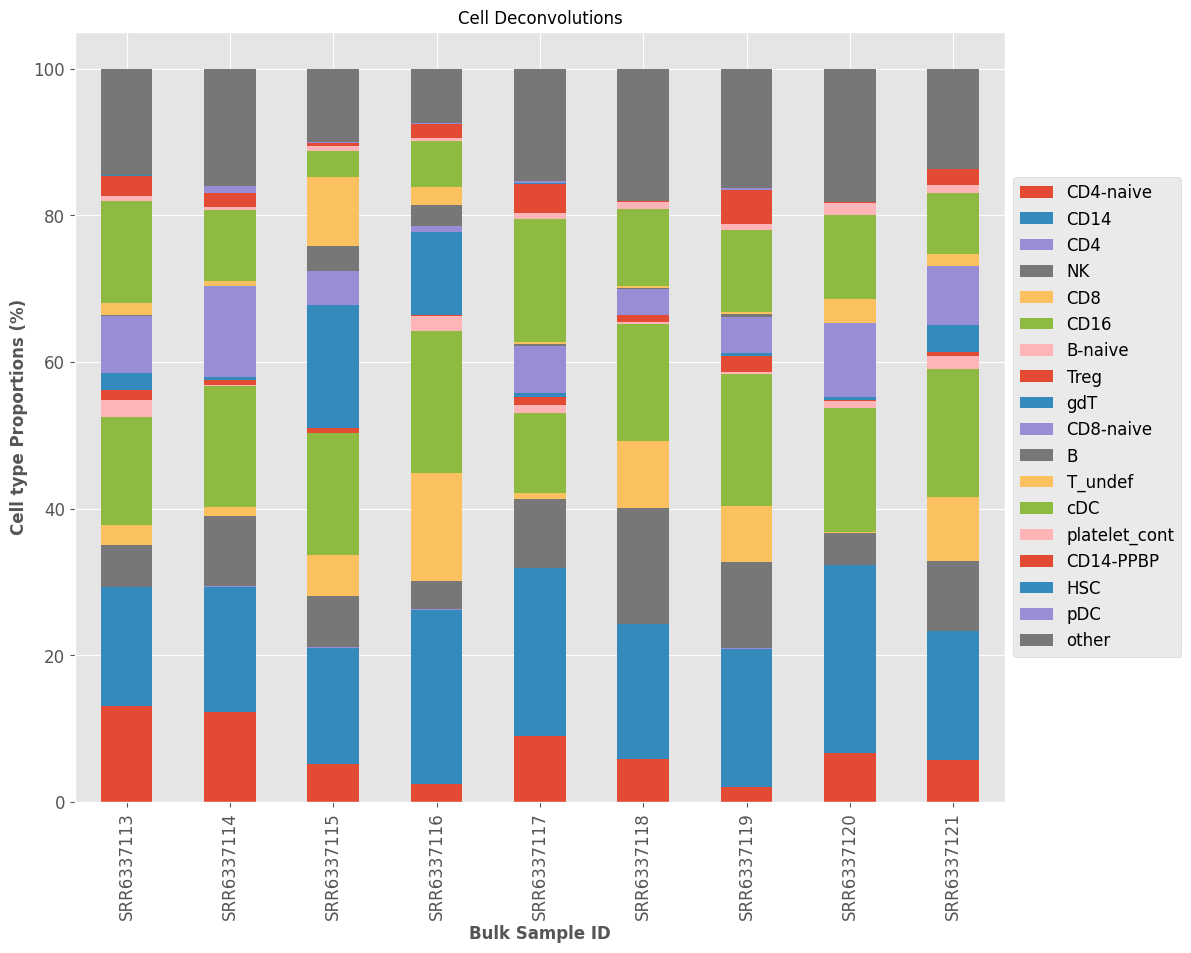

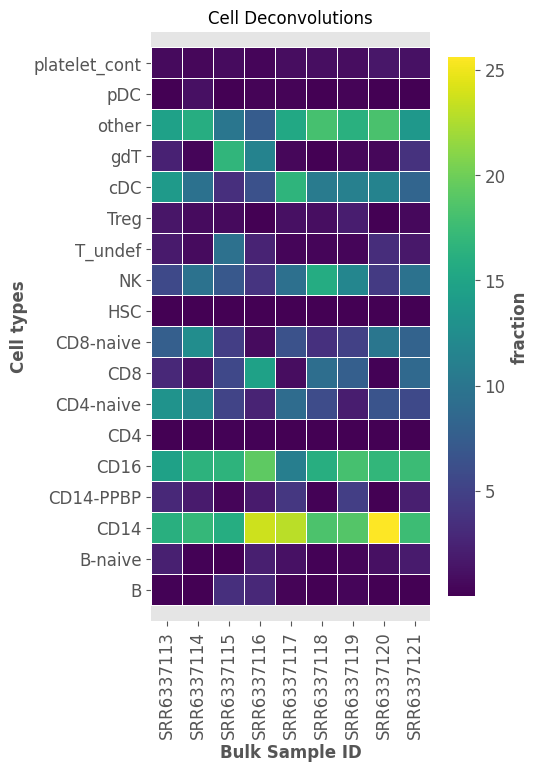

In [18]:
plotter.stack_plot(ca_preds_100)
plotter.heat_map(ca_preds_100)

need the columns to match names to get the correlation plots

In [19]:
# renaming columns to match cytof "ground truth" data
ca_preds_copy = ca_preds_100.T.copy()
ca_preds_copy.loc['B_cells'] = ca_preds_copy.loc[['B', 'B-naive']].sum()
ca_preds_copy.loc['CD4_T_cells'] = ca_preds_copy.loc[['CD4', 'CD4-naive']].sum()
ca_preds_copy.loc['CD8_T_cells'] = ca_preds_copy.loc[['CD8']].sum()
ca_preds_copy.loc['NK_cells'] = ca_preds_copy.loc[['NK']].sum()
ca_preds_copy.loc['Tregs'] = ca_preds_copy.loc[['Treg']].sum()
ca_preds_copy.loc['T_cells'] = ca_preds_copy.loc[['CD8_T_cells', 'CD4_T_cells', 'Tregs', 'T_undef']].sum()
ca_preds_copy.loc['Lymphocytes'] = ca_preds_copy.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

In [20]:
ca_preds_copy

SRR6337113  SRR6337114  SRR6337115  SRR6337116  SRR6337117  \
CD4-naive       13.131184   12.210448    5.154103    2.454812    8.931313   
CD14            16.158521   17.100864   15.876075   23.643770   22.959973   
CD4              0.052053    0.061708    0.144336    0.178055    0.049141   
NK               5.618953    9.643723    6.930889    3.885523    9.310359   
CD8              2.848989    1.176993    5.594204   14.697877    0.899535   
CD16            14.665201   16.474346   16.592285   19.283082   10.850464   
B-naive          2.267146    0.199256    0.008489    2.132502    1.159079   
Treg             1.446769    0.723436    0.684901    0.060131    1.071364   
gdT              2.353903    0.325403   16.764645   11.432918    0.457783   
CD8-naive        7.668329   12.465476    4.626205    0.741936    6.488945   
B                0.120917    0.004084    3.448085    2.863706    0.235037   
T_undef          1.713997    0.704125    9.427047    2.420545    0.351785   
cDC             13.898391    9.585602    3.456503    6.340227   16.701307   
platelet_cont    0.610025    0.467503    0.772586    0.365332    0.820449   
CD14-PPBP        2.854515    1.855015    0.381842    1.891815    4.011006   
HSC              0.040938    0.001928    0.011191    0.004518    0.080273   
pDC              0.012956    1.008766    0.041891    0.216045    0.220246   
other           14.537213   15.991321   10.084723    7.387205   15.401941   
rho_Spearman    64.028833   62.645309   64.342116   69.648251   63.197440   
rho_Pearson     78.402606   74.845377   76.419944   75.824937   77.370985   
B_cells          2.388063    0.203340    3.456574    4.996208    1.394116   
CD4_T_cells     13.183238   12.272156    5.298439    2.632868    8.980454   
CD8_T_cells      2.848989    1.176993    5.594204   14.697877    0.899535   
NK_cells         5.618953    9.643723    6.930889    3.885523    9.310359   
Tregs            1.446769    0.723436    0.684901    0.060131    1.071364   
T_cells         19.192994   14.876710   21.004592   19.811421   11.303138   
Lymphocytes     27.200009   24.723774   31.392055   28.693152   22.007613   

               SRR6337118  SRR6337119  SRR6337120  SRR6337121  
CD4-naive        5.870324    2.077828    6.629772    5.689281  
CD14            18.380249   18.777959   25.621322   17.567036  
CD4              0.023019    0.094510    0.007121    0.024531  
NK              15.768437   11.781719    4.357212    9.614213  
CD8              9.112819    7.615937    0.187485    8.622518  
CD16            16.071855   18.023875   16.861723   17.477003  
B-naive          0.163837    0.304891    1.055261    1.807306  
Treg             0.996608    2.088828    0.026146    0.538389  
gdT              0.041102    0.476271    0.453992    3.696955  
CD8-naive        3.568470    4.908647   10.082332    8.041821  
B                0.010359    0.343355    0.023899    0.048263  
T_undef          0.369331    0.371036    3.271430    1.622185  
cDC             10.512175   11.076220   11.507147    8.234765  
platelet_cont    0.957960    0.866258    1.602070    1.164241  
CD14-PPBP        0.113278    4.606983    0.054219    2.135272  
HSC              0.006173    0.026802    0.009689    0.009662  
pDC              0.008806    0.283578    0.023545    0.051734  
other           18.025198   16.275303   18.225631   13.654825  
rho_Spearman    65.125519   64.148293   63.107628   67.233594  
rho_Pearson     71.362279   75.853602   76.650542   77.641539  
B_cells          0.174196    0.648246    1.079161    1.855569  
CD4_T_cells      5.893343    2.172338    6.636893    5.713812  
CD8_T_cells      9.112819    7.615937    0.187485    8.622518  
NK_cells        15.768437   11.781719    4.357212    9.614213  
Tregs            0.996608    2.088828    0.026146    0.538389  
T_cells         16.372101   12.248139   10.121954   16.496904  
Lymphocytes     32.314733   24.678104   15.558327   27.966685

In [21]:
cytof1 = pd.read_csv('Kassandra/data/GSE107572_cytof.tsv.tar.gz', sep='\t', index_col=0)

array([[<AxesSubplot: title={'center': 'B_cells, corr = 0.341\np = 0.37'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD4_T_cells, corr = 0.752\np = 0.019'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD8_T_cells, corr = 0.79\np = 0.011'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'Lymphocytes, corr = 0.833\np = 0.005'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>],
       [<AxesSubplot: title={'center': 'NK_cells, corr = 0.868\np = 0.002'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'T_cells, corr = 0.863\np = 0.003'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': '

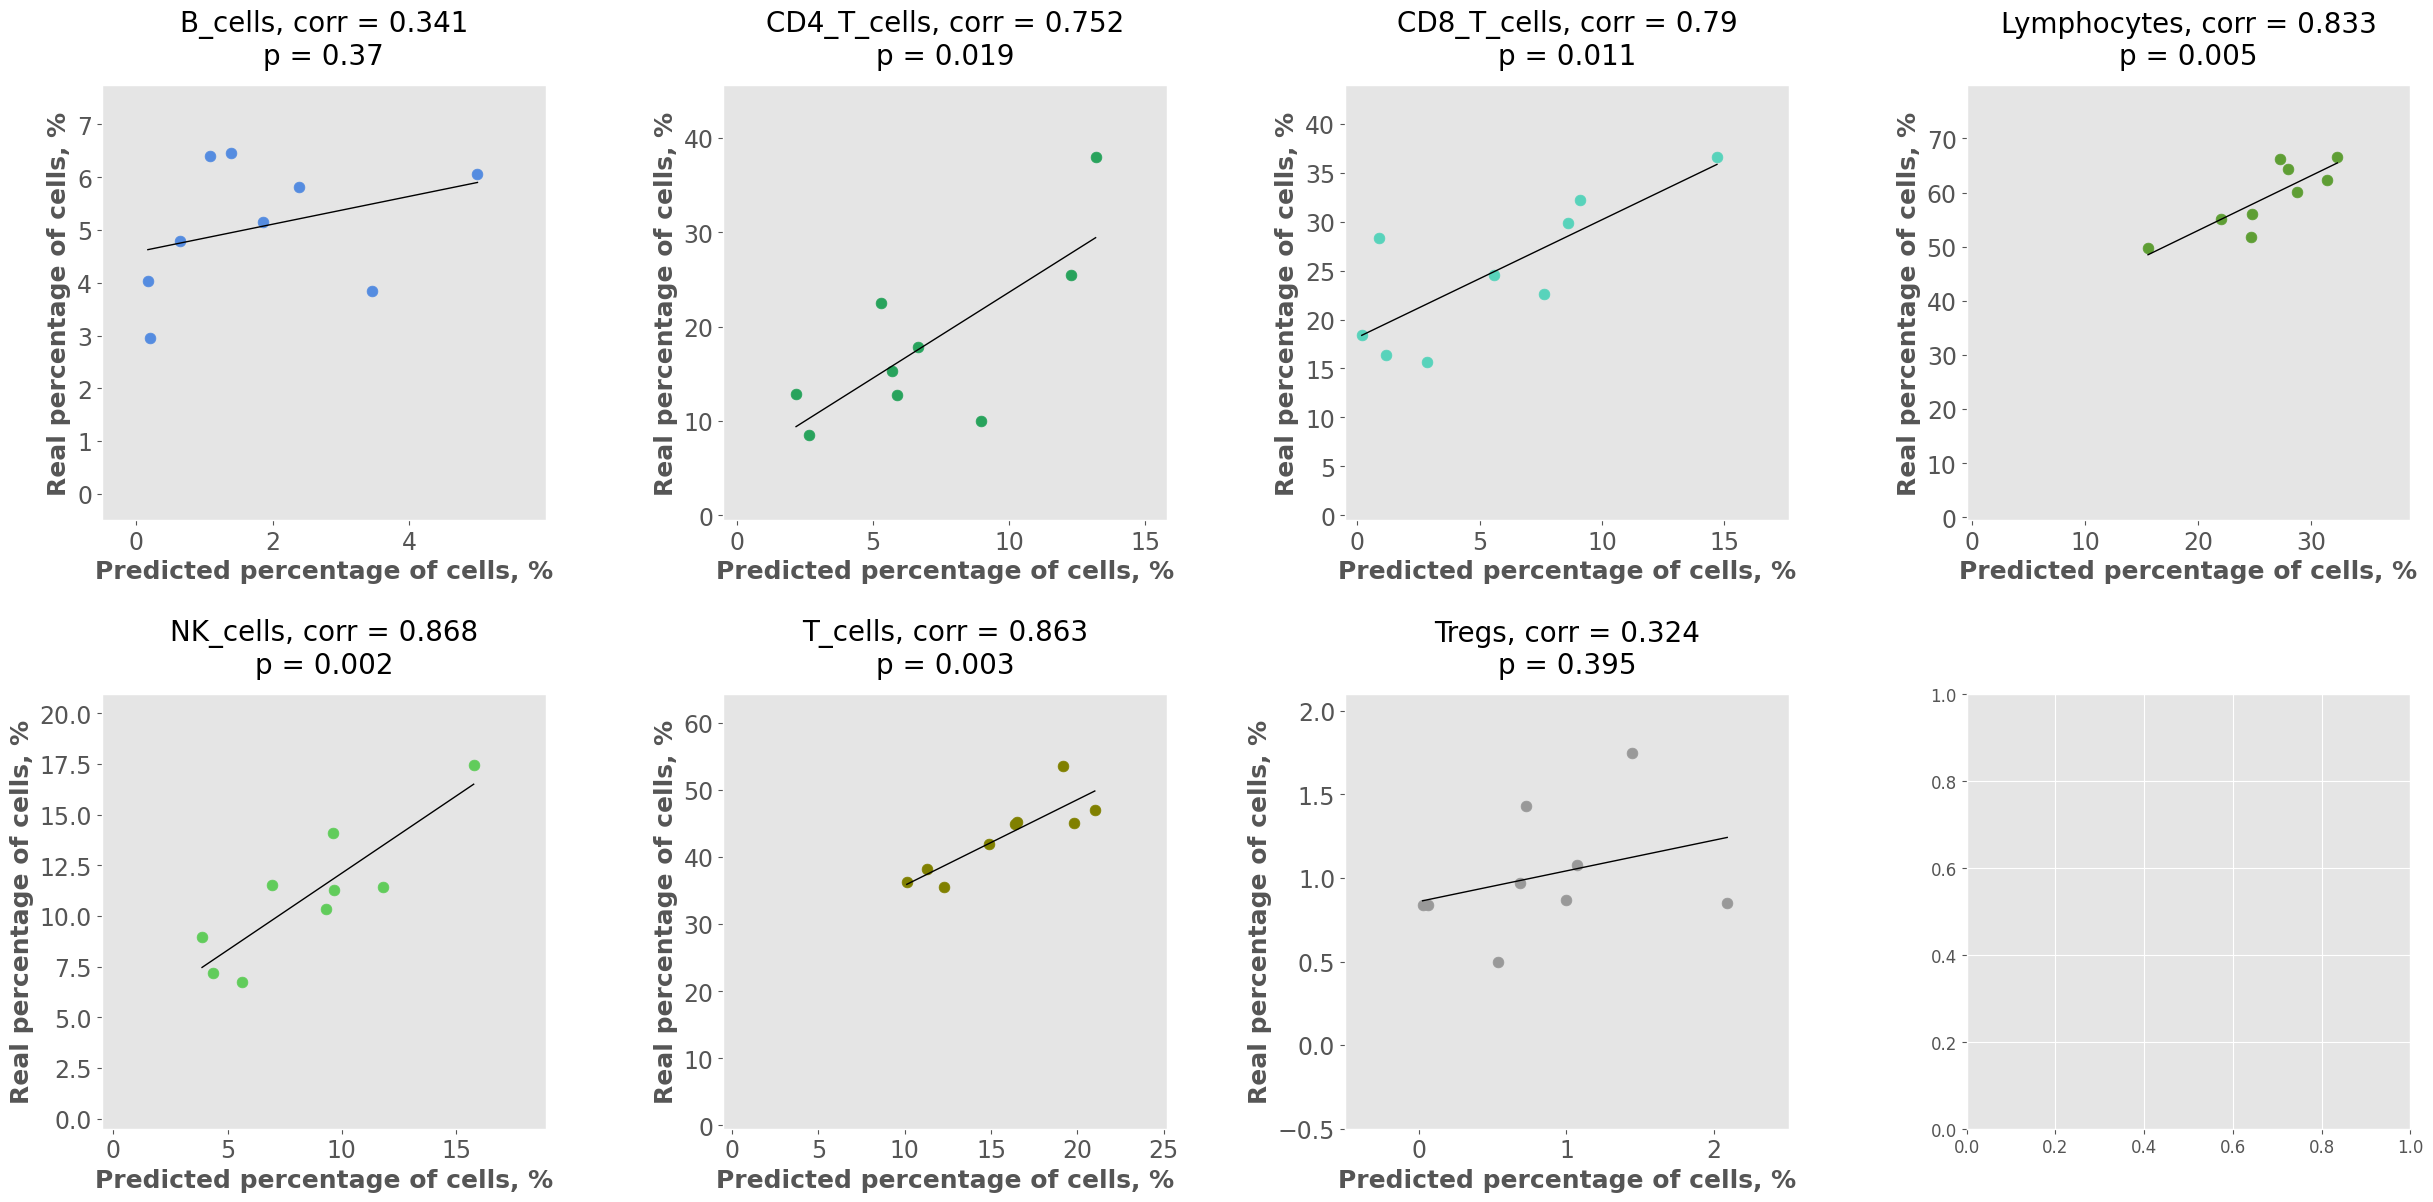

In [22]:
plotter.corr_plot(ca_preds_copy, cytof1, pallete=cells_p)

#### The statsTest class takes the statistics of the whole mixture

Statistical Tests
------------------------
RMSE: 18.692 
Pearson Correlation Coefficient: 0.923 
P value: 0.0 
R^2: 0.153


<AxesSubplot: title={'center': 'GSE107572'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>

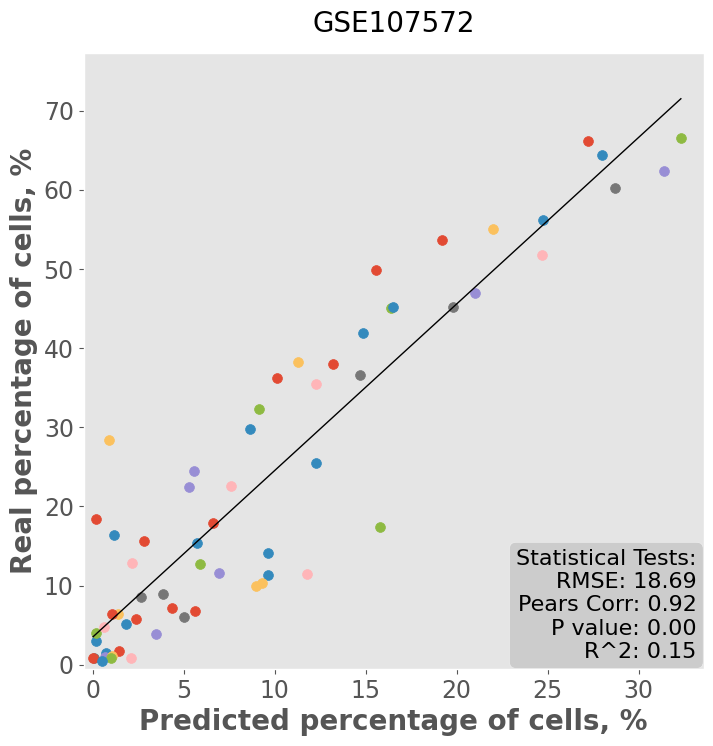

In [23]:
title = 'GSE107572'
plotter.print_cell_whole(ca_preds_copy, cytof1, pallete = cells_p, title=title, stat=True)

array([[<AxesSubplot: title={'center': 'Bland Altman of B_cells: {-3.257 +/- 1.658}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD4_T_cells: {-11.164 +/- 6.878}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD8_T_cells: {-19.315 +/- 4.62}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of Lymphocytes: {-33.097 +/- 3.441}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of NK_cells: {-2.46 +/- 1.889}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of T_cells: {-27.38 +/- 3.118}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <Axes

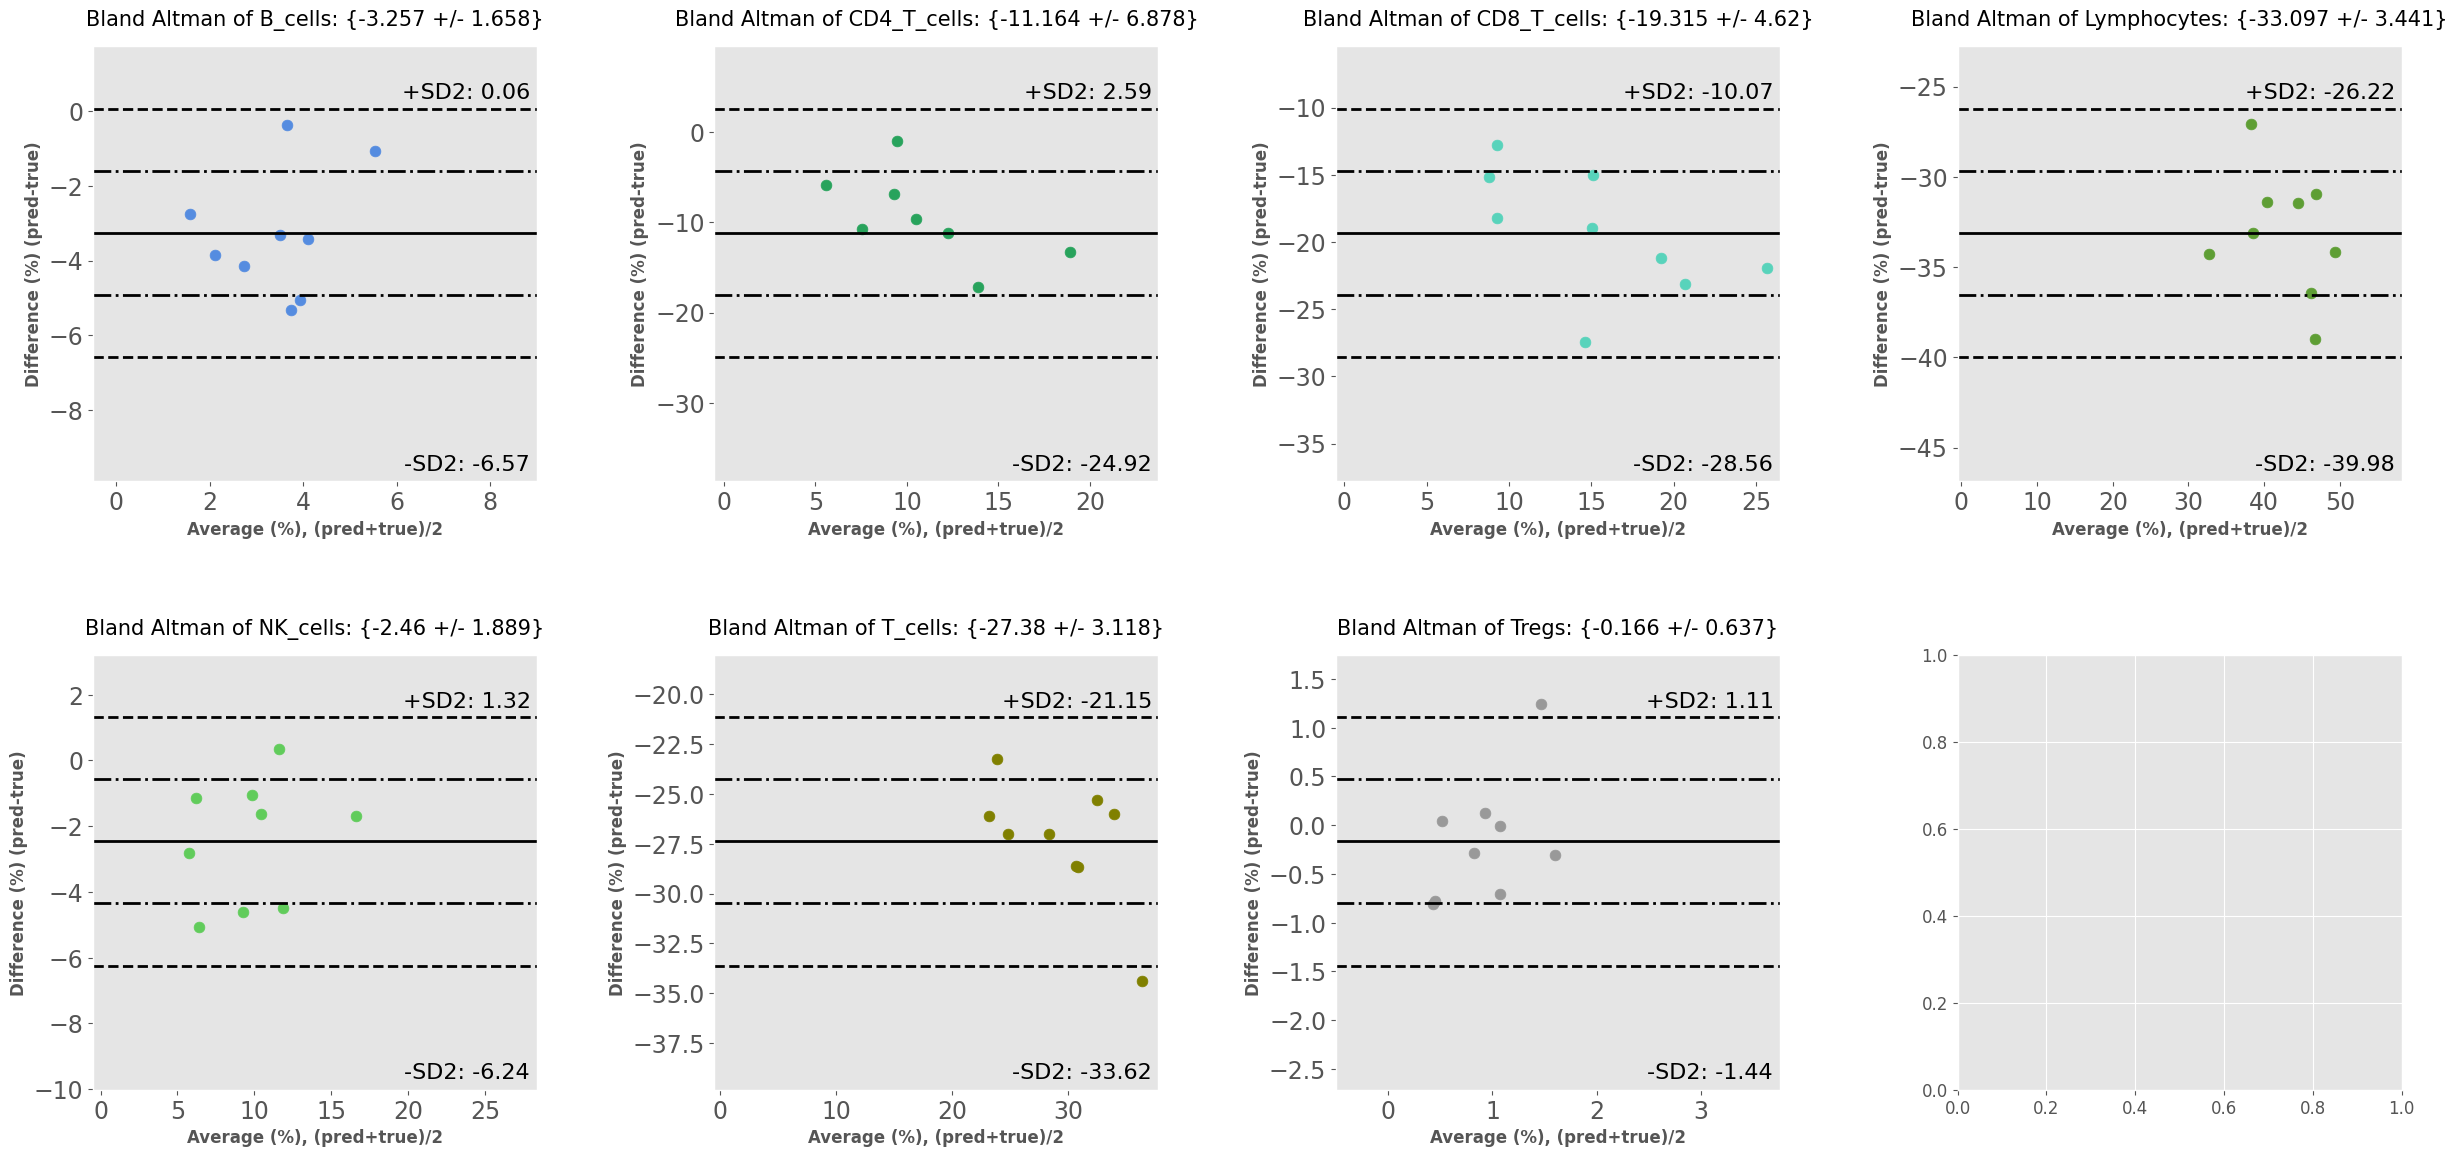

In [76]:
plotter.bland_altman(ca_preds_copy, cytof1, pallete = cells_p)

In [34]:
# get a color pallete for color samples
ind_names = ca_preds_100.index.intersection(cytof1.index)
sample_color = plotter.get_cmap(len(ind_names))


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

array([[<AxesSubplot: title={'center': 'SRR6337113, corr = 0.977\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'SRR6337114, corr = 0.929\np = 0.002'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'SRR6337115, corr = 0.955\np = 0.001'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'SRR6337116, corr = 0.991\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>],
       [<AxesSubplot: title={'center': 'SRR6337117, corr = 0.76\np = 0.047'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'SRR6337118, corr = 0.92\np = 0.003'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 

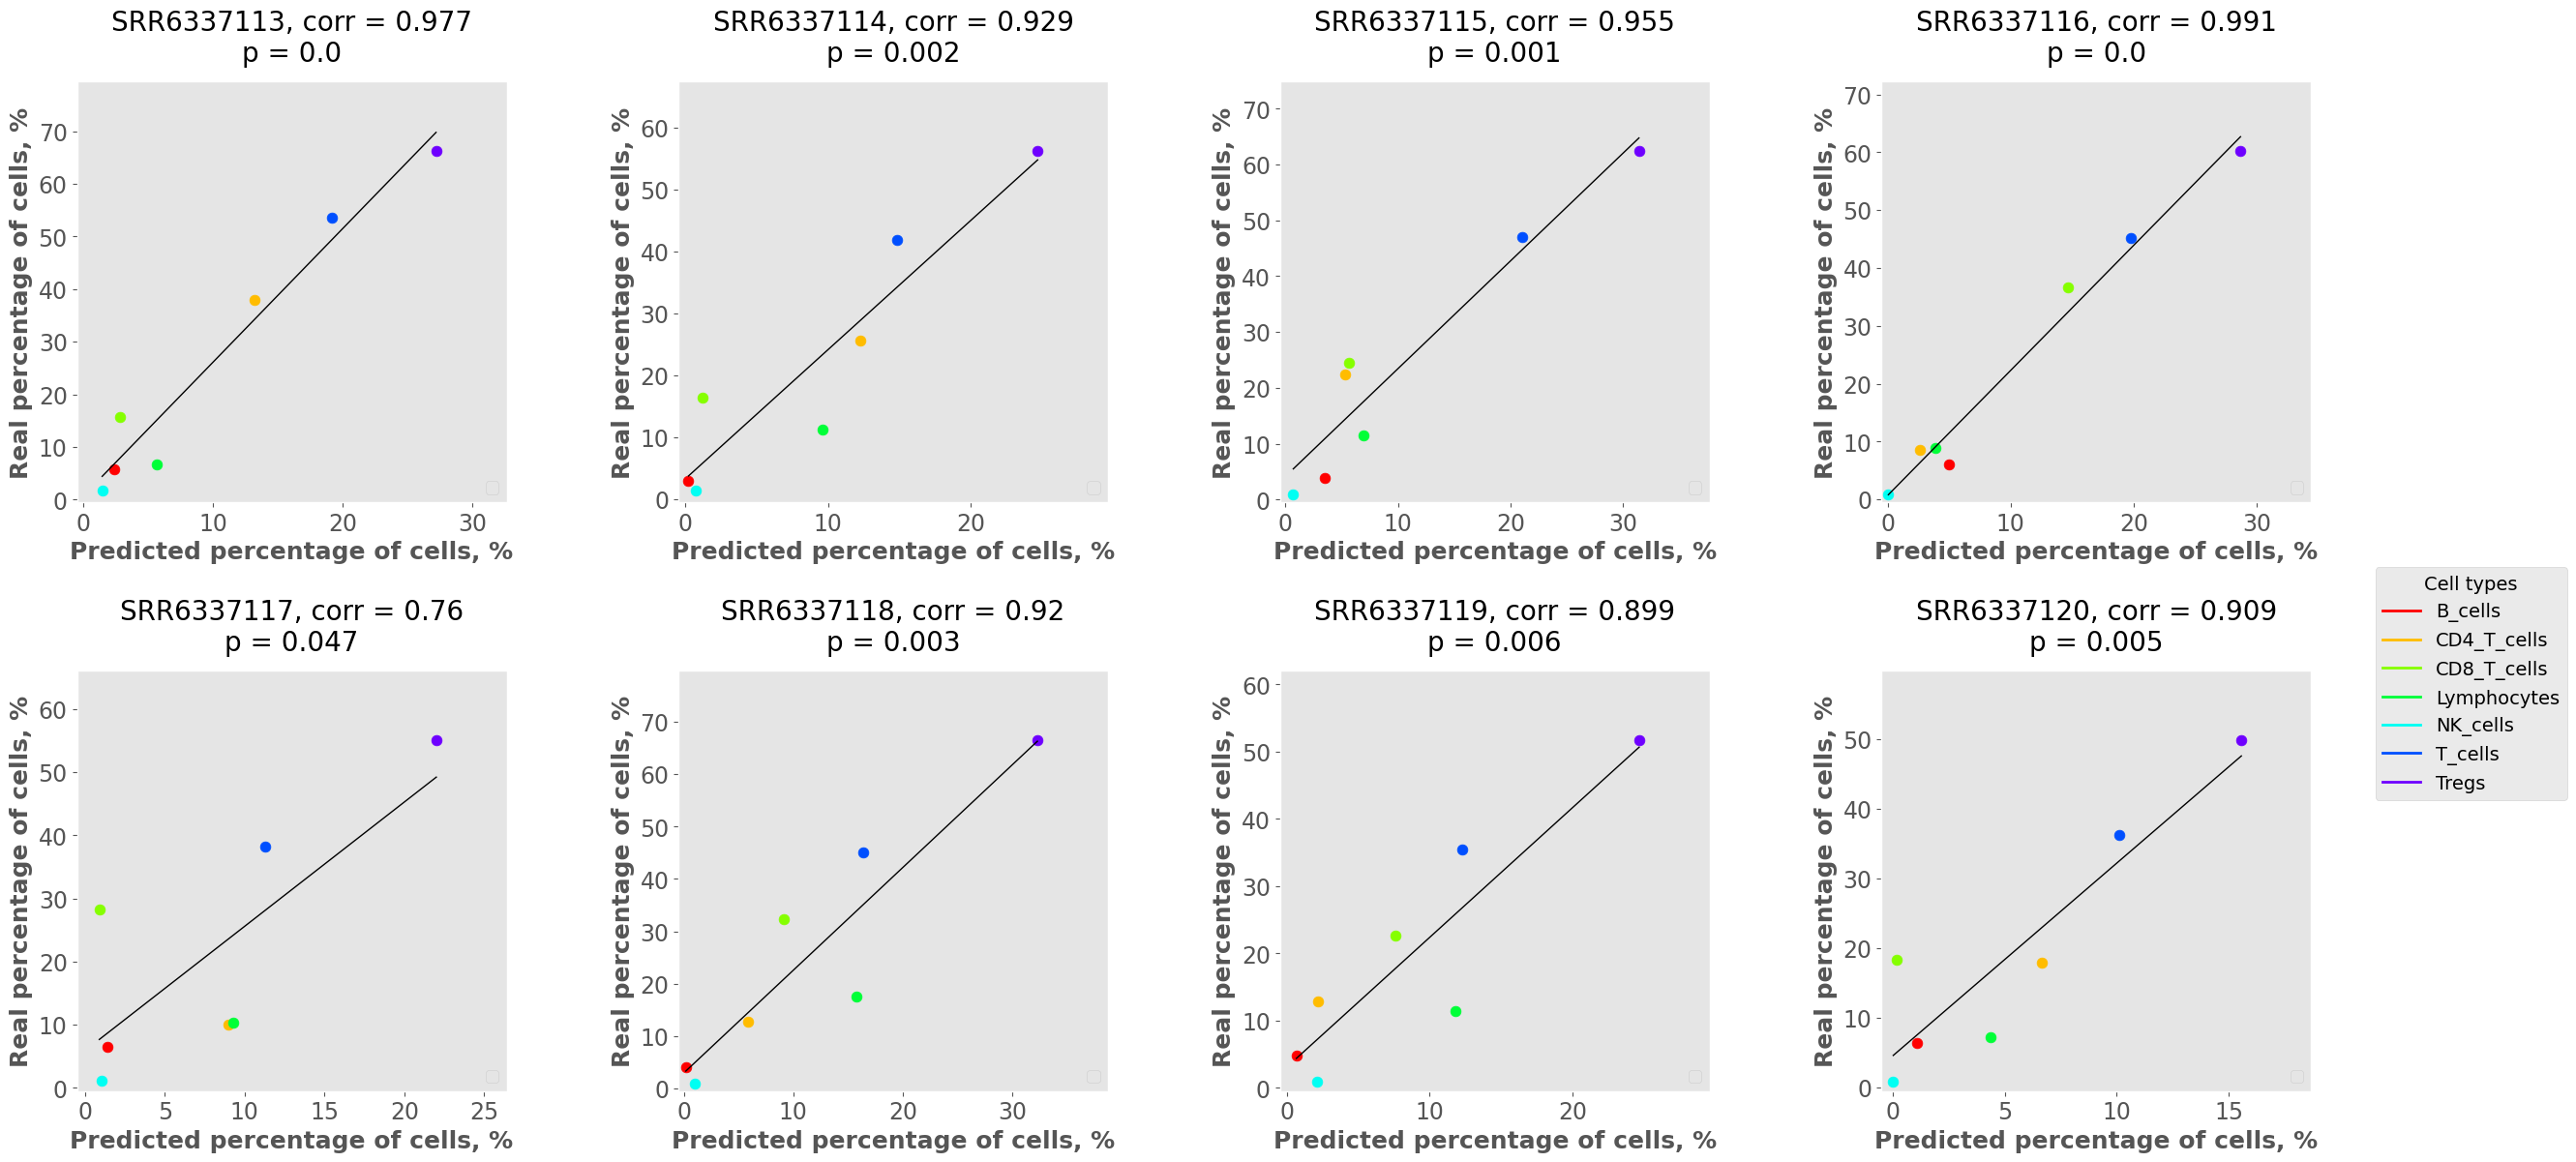

In [120]:
plotter.plot_sample(ca_preds_copy, cytof1, pallete = sample_color)

array([[<AxesSubplot: title={'center': 'Bland Altman of SRR6337113: {-16.542 +/- 16.212}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337114: {-13.141 +/- 12.422}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337115: {-14.048 +/- 12.436}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337116: {-13.075 +/- 12.764}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of SRR6337117: {-13.516 +/- 14.864}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337118: {-14.035 +/- 14.205}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'

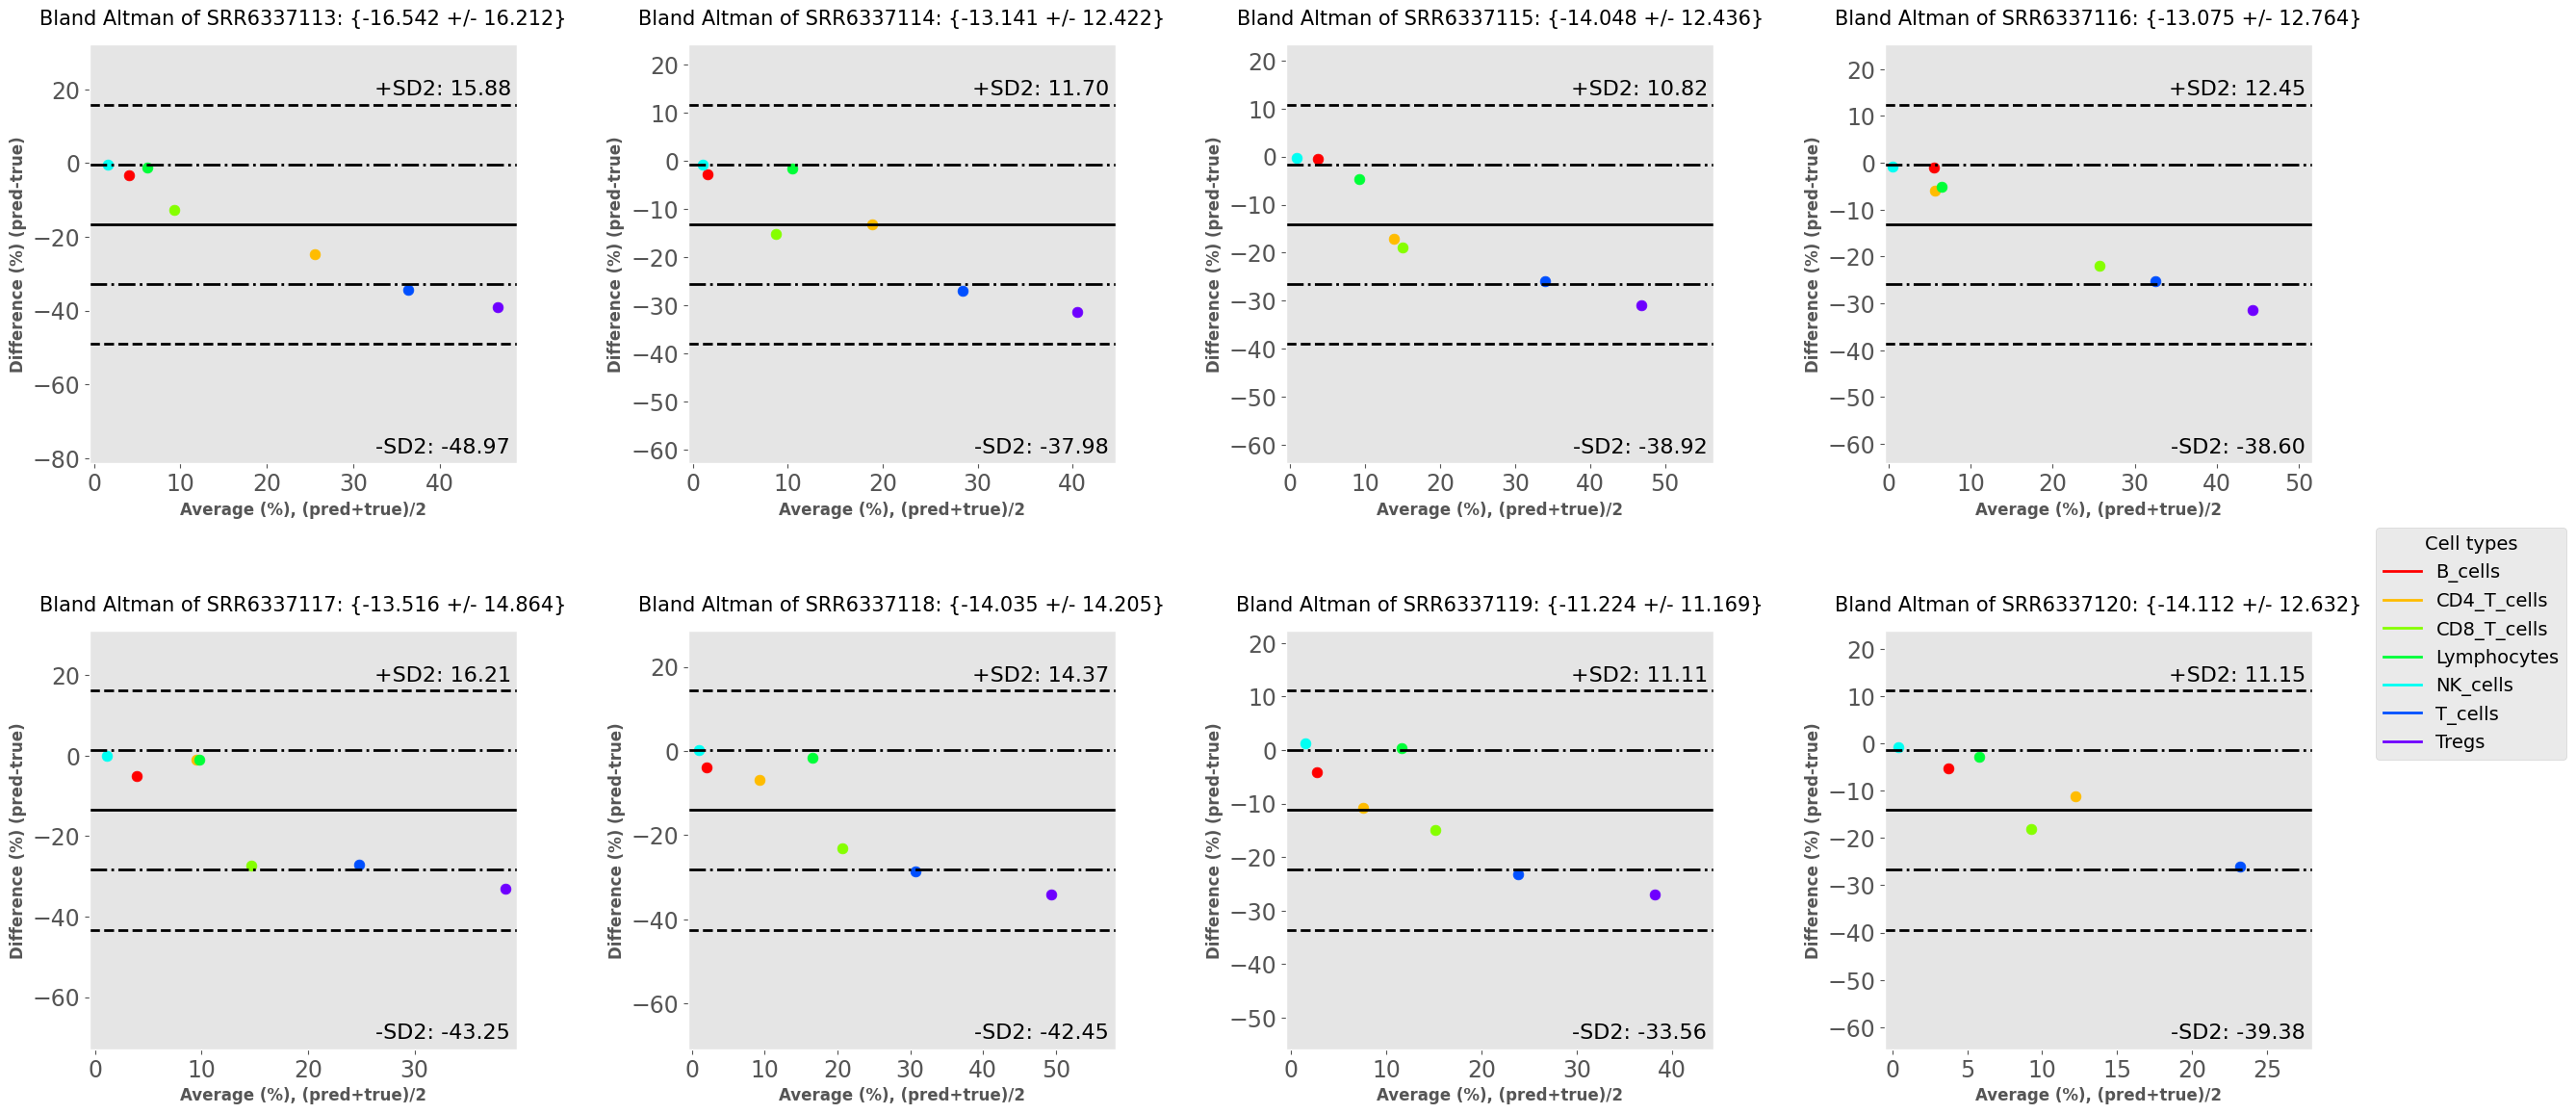

In [117]:
plotter.bland_altman_v2(ca_preds_copy, cytof1, pallete = sample_color)

In [138]:
title = 'GSE1479433'
bulk2 = pd.read_csv('Kassandra/data/validation_datasets/blood_expr.tsv', sep='\t', index_col=0)
cytof2 = pd.read_csv('Kassandra/data/validation_datasets/cytometry_df.tsv', sep='\t', index_col=0)

In [114]:
gene_dict = cellanneal.make_gene_dictionary(
                    signature_df,
                    bulk2,
                    disp_min=0.5,
                    bulk_min=1e-5,
                    bulk_max=0.01)

3862 highly variable genes identified in cell type
        reference.
	2475 of these are within thresholds for sample F0222
	2469 of these are within thresholds for sample F0223
	2507 of these are within thresholds for sample F0224
	2343 of these are within thresholds for sample F0229
	2477 of these are within thresholds for sample F0230
	2412 of these are within thresholds for sample F0231
	2129 of these are within thresholds for sample F0232
	2235 of these are within thresholds for sample F0274
	2293 of these are within thresholds for sample F0303
	2379 of these are within thresholds for sample F0304
	2272 of these are within thresholds for sample F0305
	2442 of these are within thresholds for sample F0306
	2307 of these are within thresholds for sample F0307
	2457 of these are within thresholds for sample F0308
	1809 of these are within thresholds for sample F0460
	2290 of these are within thresholds for sample F0462
	2282 of these are within thresholds for sample F0590
	2076 of the

In [115]:
ca_preds2 = cellanneal.deconvolve(
                signature_df,
                bulk2,
                maxiter=1000,
                gene_dict=gene_dict)

Deconvolving sample 1 of 45 (F0222) ...
Deconvolving sample 2 of 45 (F0223) ...
Deconvolving sample 3 of 45 (F0224) ...
Deconvolving sample 4 of 45 (F0229) ...
Deconvolving sample 5 of 45 (F0230) ...
Deconvolving sample 6 of 45 (F0231) ...
Deconvolving sample 7 of 45 (F0232) ...
Deconvolving sample 8 of 45 (F0274) ...
Deconvolving sample 9 of 45 (F0303) ...
Deconvolving sample 10 of 45 (F0304) ...
Deconvolving sample 11 of 45 (F0305) ...
Deconvolving sample 12 of 45 (F0306) ...
Deconvolving sample 13 of 45 (F0307) ...
Deconvolving sample 14 of 45 (F0308) ...
Deconvolving sample 15 of 45 (F0460) ...
Deconvolving sample 16 of 45 (F0462) ...
Deconvolving sample 17 of 45 (F0590) ...
Deconvolving sample 18 of 45 (F0591) ...
Deconvolving sample 19 of 45 (F0592) ...
Deconvolving sample 20 of 45 (F0594) ...
Deconvolving sample 21 of 45 (F0595) ...
Deconvolving sample 22 of 45 (F0596) ...
Deconvolving sample 23 of 45 (F0597) ...
Deconvolving sample 24 of 45 (F0598) ...
Deconvolving sample 25 of

In [139]:
ca_preds2_100 = ca_preds2*100

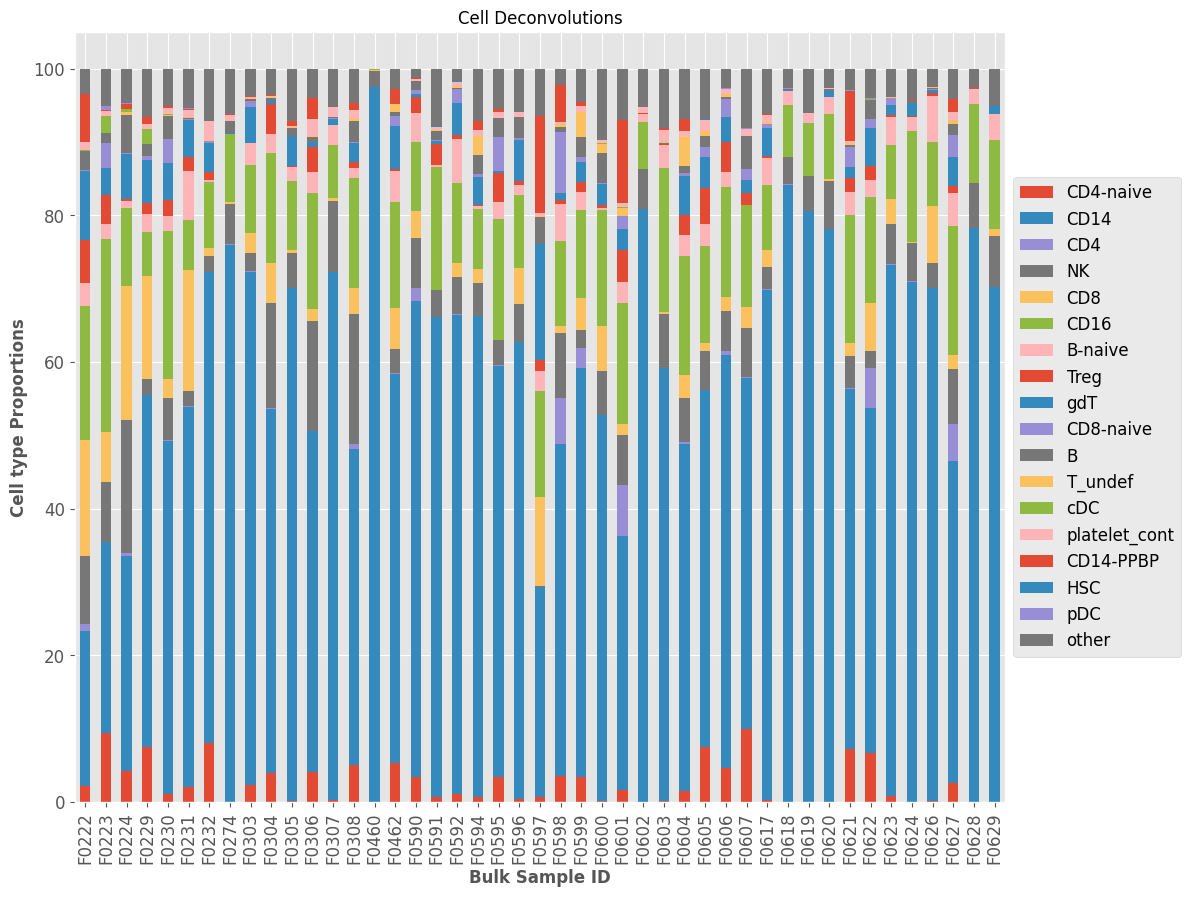

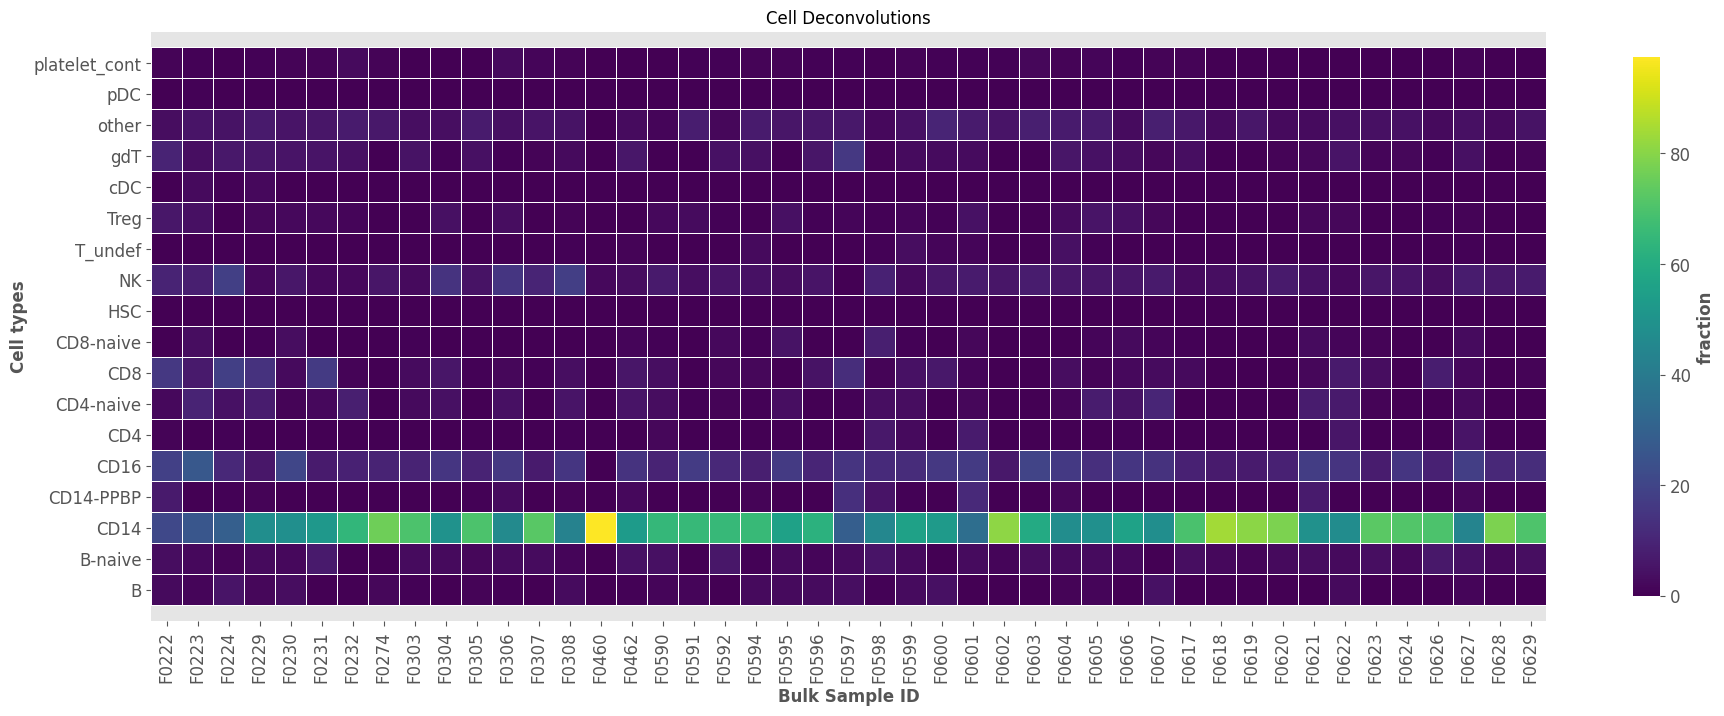

In [140]:
plotter.stack_plot(ca_preds2_100)
plotter.heat_map(ca_preds2_100)

In [141]:
# renaming columns to match cytof "ground truth" data
ca_preds_copy2 = ca_preds2_100.T.copy()
ca_preds_copy2.loc['B_cells'] = ca_preds_copy2.loc[['B', 'B-naive']].sum()
ca_preds_copy2.loc['CD4_T_cells'] = ca_preds_copy2.loc[['CD4', 'CD4-naive']].sum()
ca_preds_copy2.loc['CD8_T_cells'] = ca_preds_copy2.loc[['CD8']].sum()
ca_preds_copy2.loc['NK_cells'] = ca_preds_copy2.loc[['NK']].sum()
ca_preds_copy2.loc['Tregs'] = ca_preds_copy2.loc[['Treg']].sum()
ca_preds_copy2.loc['T_cells'] = ca_preds_copy2.loc[['CD8_T_cells', 'CD4_T_cells', 'Tregs', 'T_undef']].sum()
ca_preds_copy2.loc['Lymphocytes'] = ca_preds_copy2.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

In [142]:
flatten(ca_preds_copy2, cytof2)

Index(['B_cells', 'CD4_T_cells', 'CD8_T_cells', 'NK_cells', 'Tregs', 'T_cells',
       'Lymphocytes'],
      dtype='object')
Index(['F0222', 'F0223', 'F0224', 'F0229', 'F0230', 'F0231', 'F0232', 'F0274',
       'F0303', 'F0304', 'F0305', 'F0306', 'F0307', 'F0308', 'F0460', 'F0462',
       'F0590', 'F0591', 'F0592', 'F0594', 'F0595', 'F0596', 'F0597', 'F0598',
       'F0599', 'F0600', 'F0601', 'F0602', 'F0603', 'F0604', 'F0605', 'F0606',
       'F0607', 'F0617', 'F0618', 'F0619', 'F0620', 'F0621', 'F0622', 'F0623',
       'F0624', 'F0626', 'F0627', 'F0628', 'F0629'],
      dtype='object')


array([[<AxesSubplot: title={'center': 'B_cells, corr = 0.784\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD4_T_cells, corr = 0.798\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD8_T_cells, corr = 0.457\np = 0.013'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'Lymphocytes, corr = 0.809\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>],
       [<AxesSubplot: title={'center': 'NK_cells, corr = 0.65\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'T_cells, corr = 0.881\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'Tregs, co

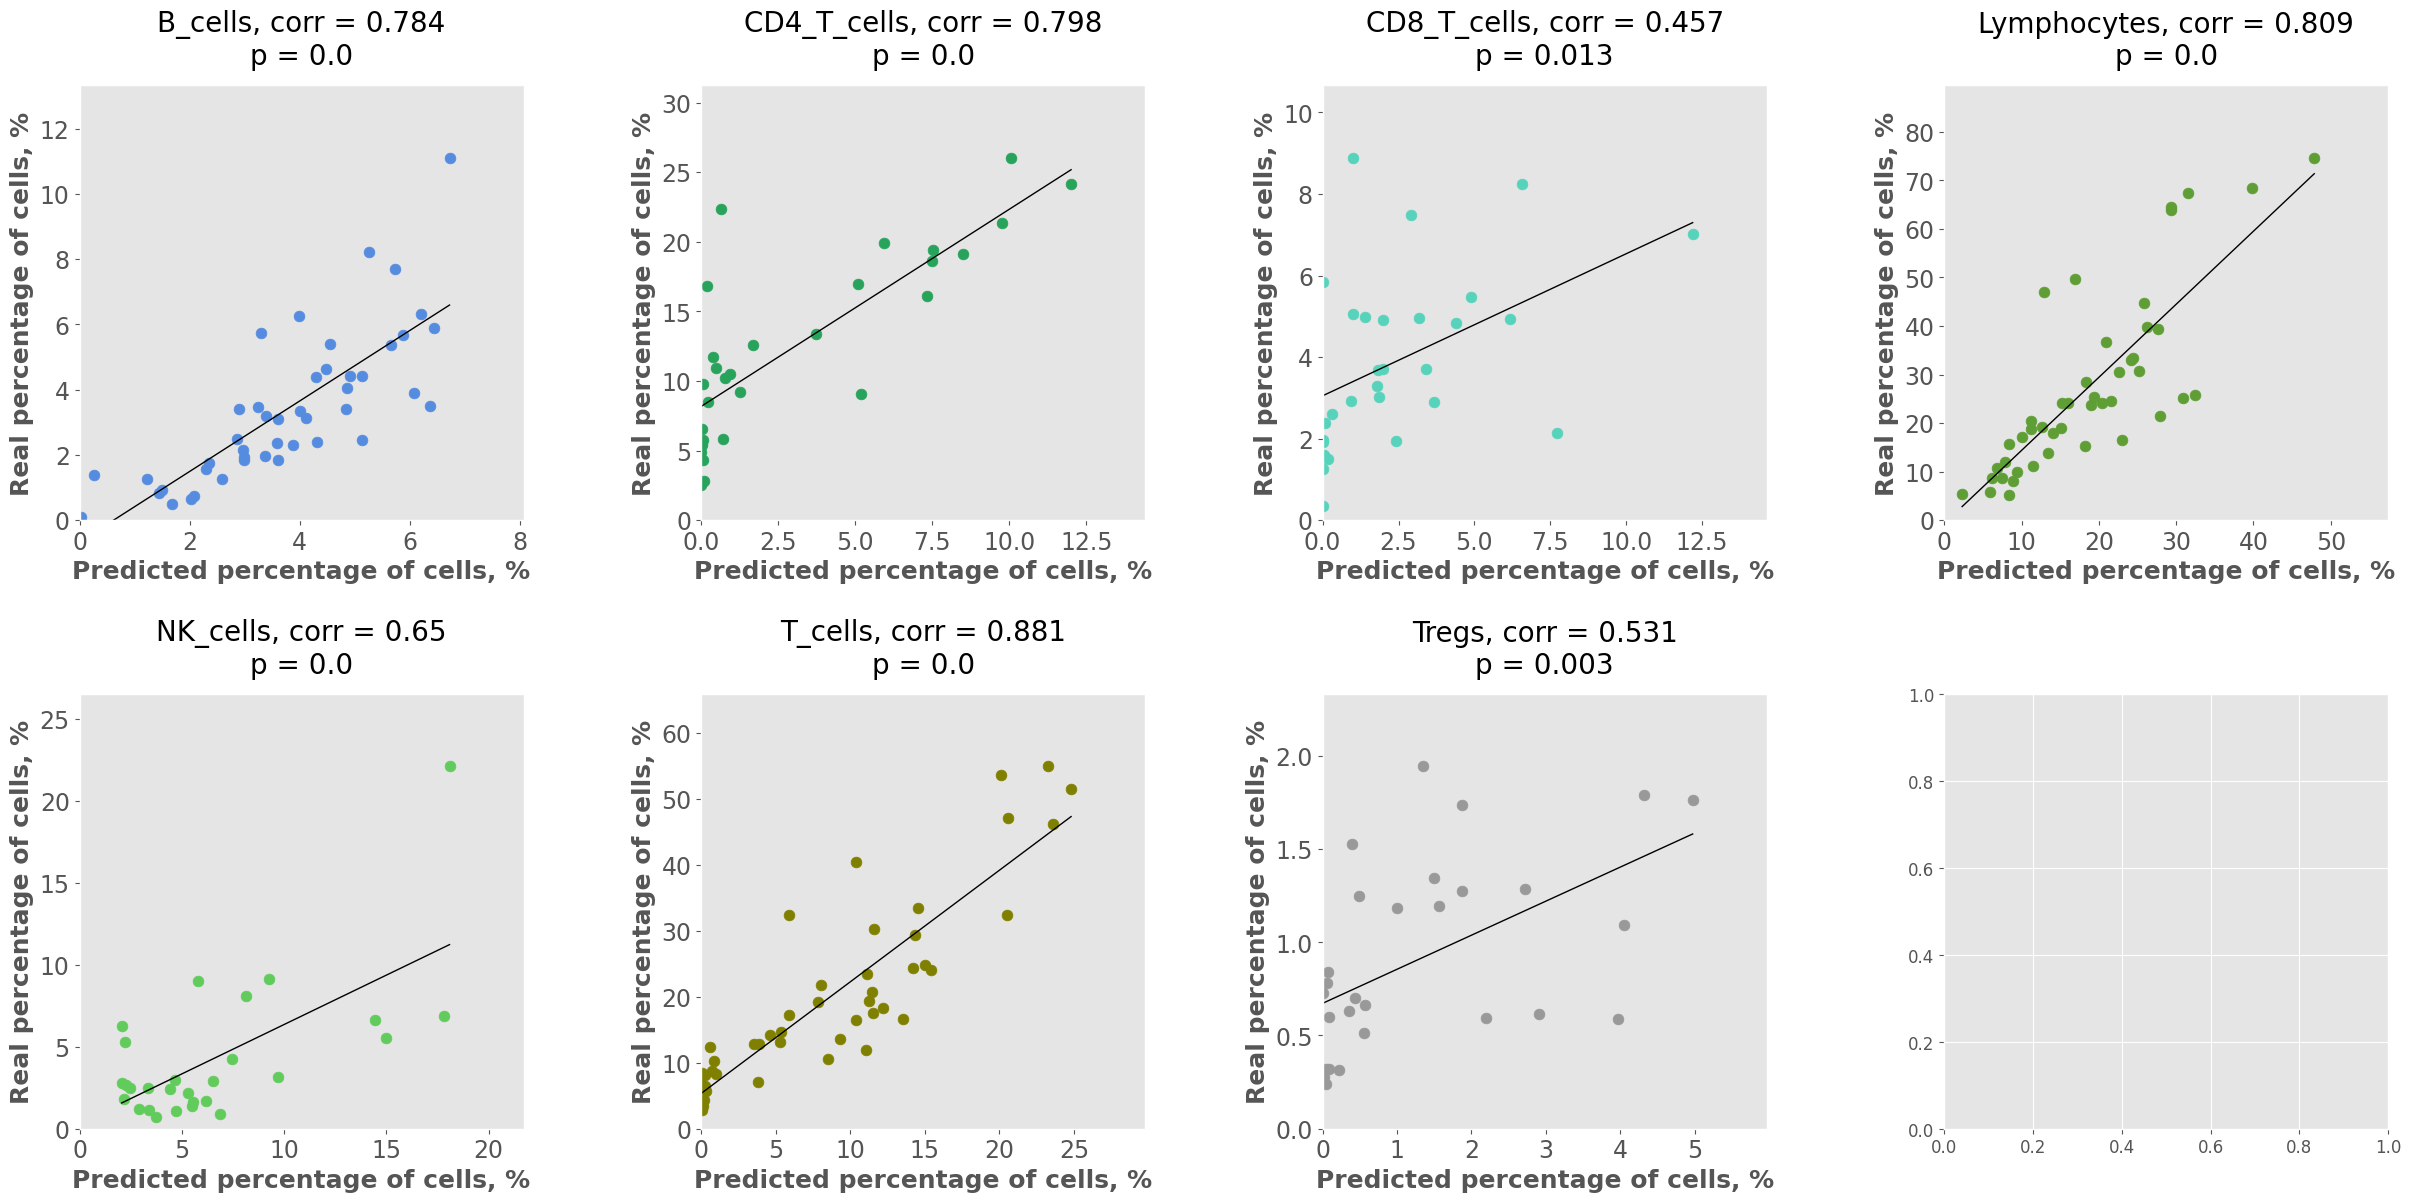

In [143]:
plotter.corr_plot(ca_preds_copy2, cytof2, pallete=cells_p)

Statistical Tests
------------------------
RMSE: 9.503 
Pearson Correlation Coefficient: 0.849 
P value: 0.0 
R^2: 0.544


<AxesSubplot: title={'center': 'GSE107572'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>

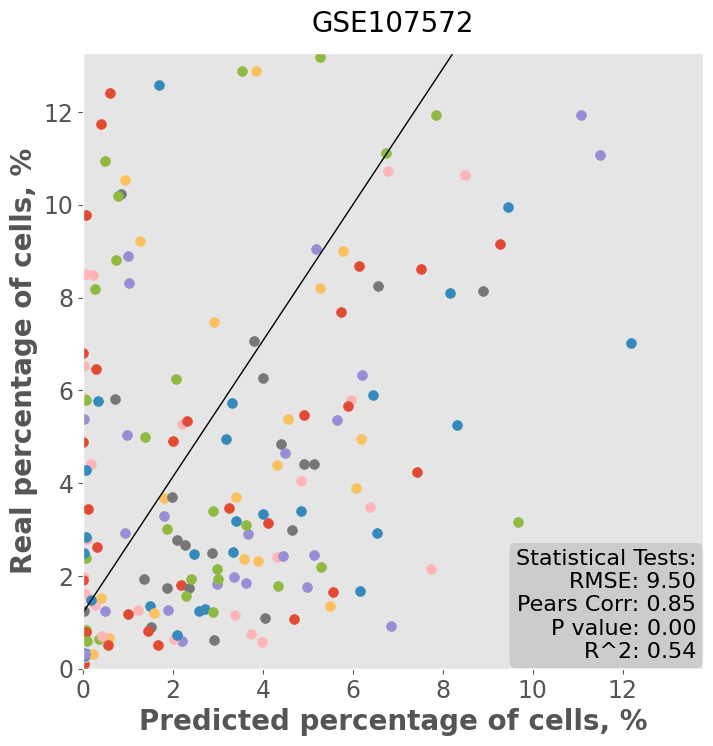

In [144]:
plotter.print_cell_whole(ca_preds_copy2, cytof2, pallete = cells_p, title=title, stat=True)

these results make sense as alot of cell subtypes are being incorrectly identified compared to the CyTOF data

array([[<AxesSubplot: title={'center': 'Bland Altman of B_cells: {0.369 +/- 1.424}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD4_T_cells: {-9.463 +/- 4.377}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD8_T_cells: {-1.435 +/- 2.676}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of Lymphocytes: {-8.718 +/- 11.805}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of NK_cells: {2.251 +/- 3.762}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of T_cells: {-11.462 +/- 8.324}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesS

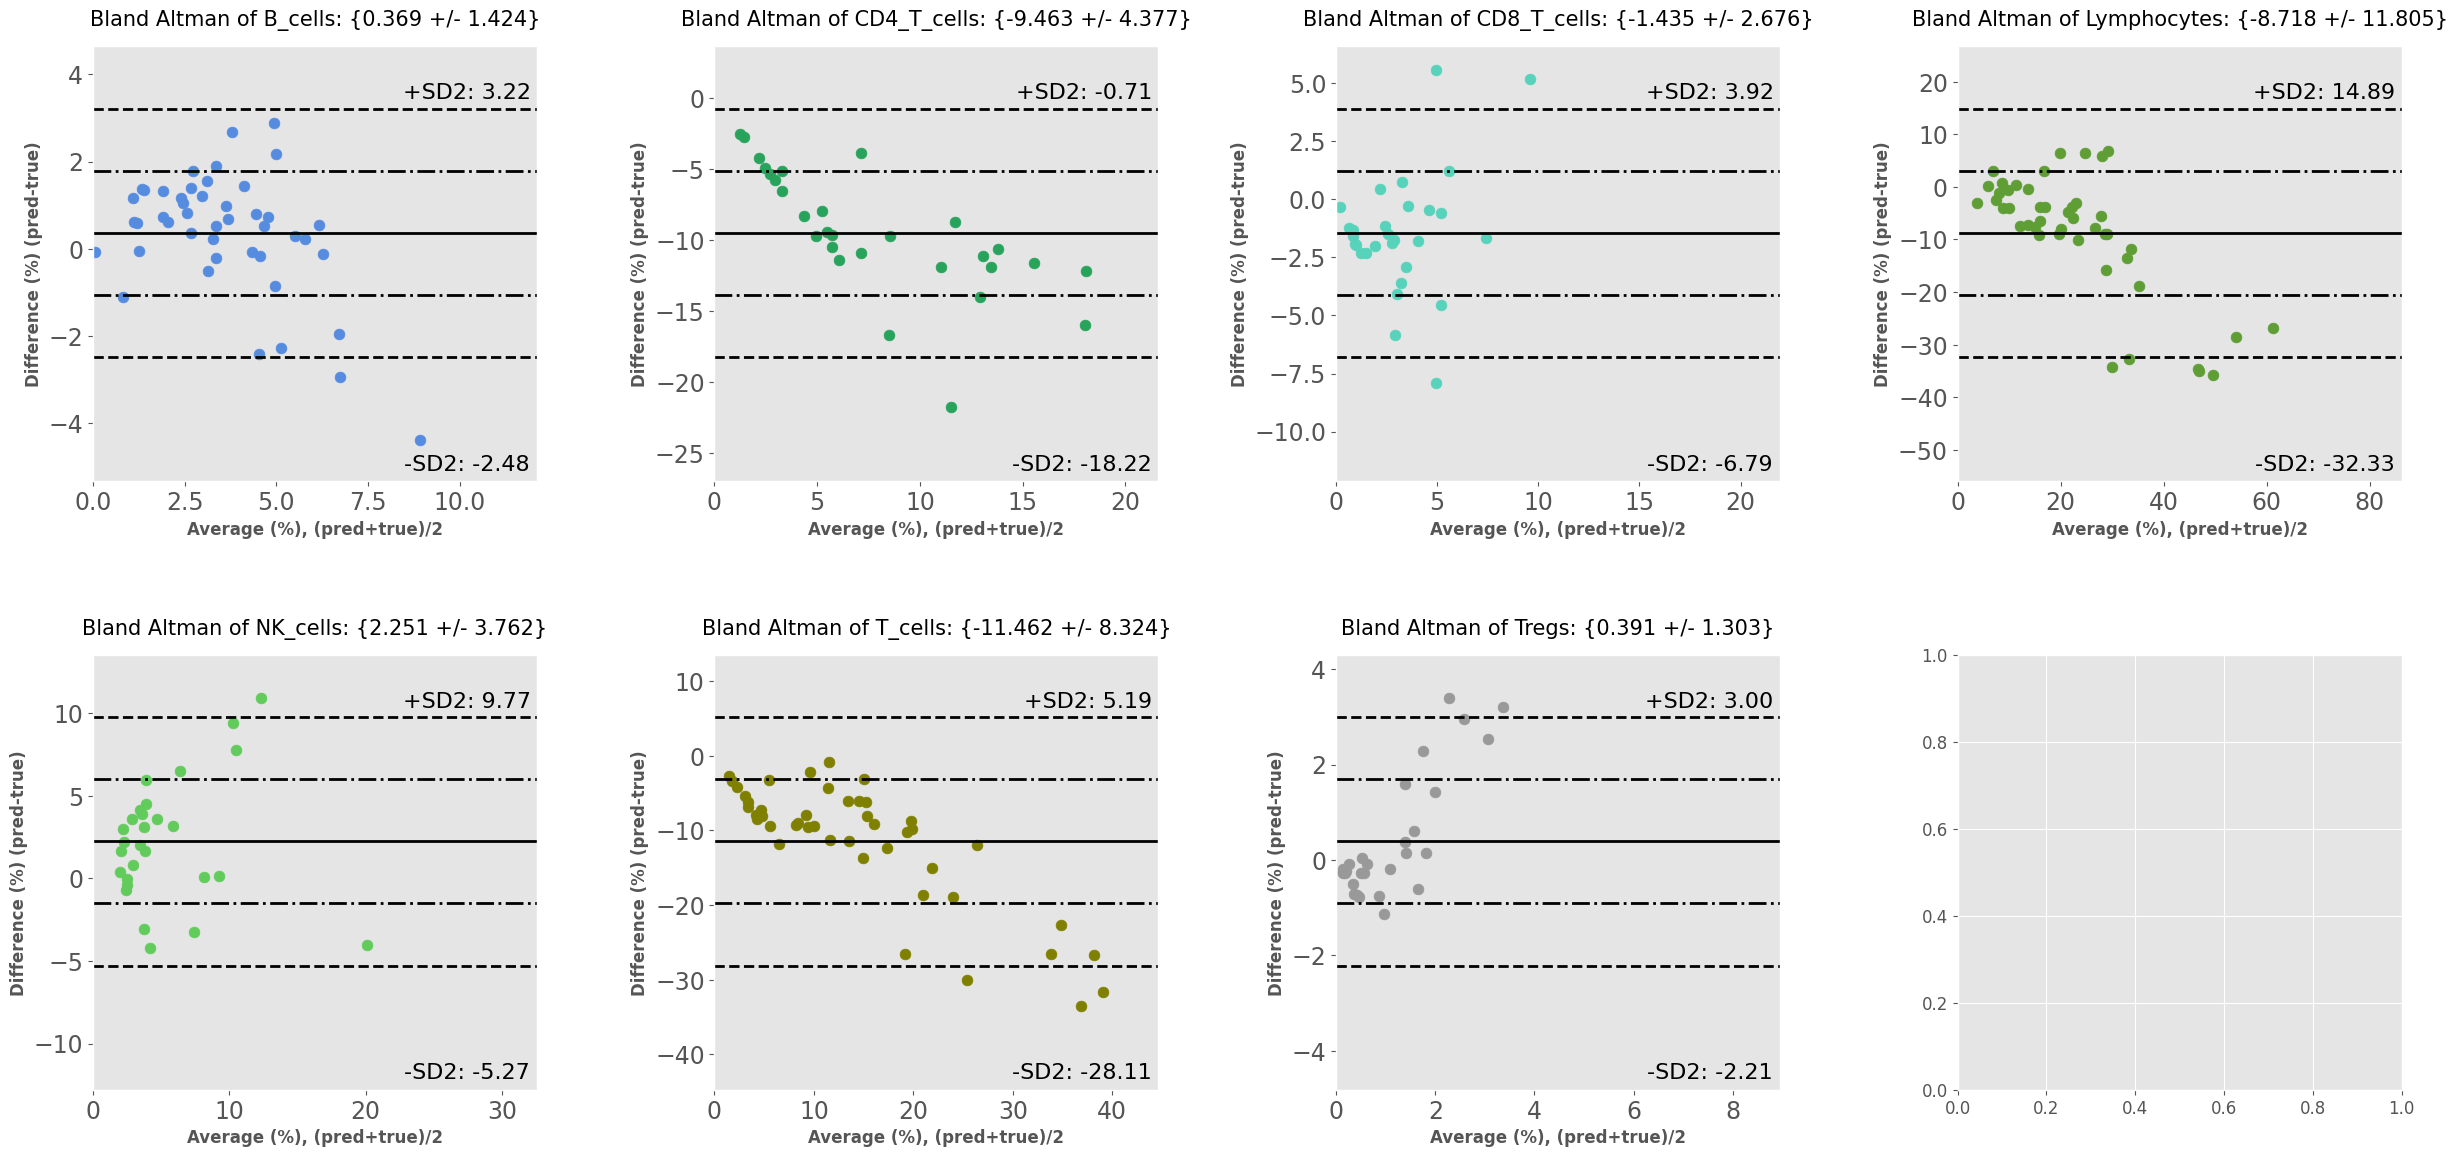

In [174]:
plotter.bland_altman(ca_preds_copy2, cytof2, pallete = cells_p)

#### Kassandra

In [121]:
lab_expr = pd.read_csv('Kassandra/trainingData/laboratory_data_expressions.tsv', sep='\t', index_col=0)
lab_annot = pd.read_csv('Kassandra/trainingData/laboratory_data_annotation.tsv', sep='\t', index_col=0)

In [122]:
lab_annot['Dataset'] = lab_annot.index
lab_annot = lab_annot.iloc[:,[1,0]]

In [123]:
cell_types = CellTypes.load('Kassandra/configs/custom.yaml')
mixer = Mixers(cell_types=cell_types,
              cells_expr=lab_expr, cells_annot=lab_annot,
              tumor_expr=lab_expr, tumor_annot=lab_annot,
              num_av=3, num_points=3000)
model = DeconvolutionModels(cell_types,
                           boosting_params_first_step='Kassandra/configs/boosting_params/median_model_first.tsv',
                           boosting_params_second_step='Kassandra/configs/boosting_params/median_model_second.tsv')
model.fit(mixer)

Checking normal cells expressions...
Expressions OK
Checking cancer cells expressions...
Expressions OK
============== L1 models ==============
Generating mixes for B_cells model
Fitting B_cells model
Trained in:  2.8 sec.


Generating mixes for CD27neg_Memory_B_cells model
Fitting CD27neg_Memory_B_cells model
Trained in:  6.5 sec.


Generating mixes for CD4_T_cells model
Fitting CD4_T_cells model
Trained in:  4.3 sec.


Generating mixes for CD57neg_Cytotoxic_NK_cells model
Fitting CD57neg_Cytotoxic_NK_cells model
Trained in:  6.5 sec.


Generating mixes for CD57pos_Cytotoxic_NK_cells model
Fitting CD57pos_Cytotoxic_NK_cells model
Trained in:  5.2 sec.


Generating mixes for CD8_T_cells model
Fitting CD8_T_cells model
Trained in:  4.2 sec.


Generating mixes for CDC model
Fitting CDC model
Trained in:  7.5 sec.


Generating mixes for Central_memory_CD8_T_cells model
Fitting Central_memory_CD8_T_cells model
Trained in:  9.2 sec.


Generating mixes for Central_memory_T_helpers model
Fitt

In [124]:
k_preds = model.predict(bulk) 
k_preds.loc['Lymphocytes'] = k_preds.loc[['B_cells', 'T_cells', 'NK_cells']].sum()
k_preds_100 = k_preds * 100

# drop parent nodes so we can plot child nodes stack plots
parent_nodes = ['Non_plasma_B_cells', 'Monocytes', 'Granulocytes', 'B_cells', 'T_cells', 'NK_cells', 'Myeloid_cells', 'Lymphoid_cells', 'Lymphocytes', 'CD8_T_cells', 'Cytotoxic_NK_cells', 'CD4_T_cells', 'Memory_T_helpers', 'Memory_CD8_T_cells']
k_preds_child = k_preds_100.drop(parent_nodes)

Expressions OK


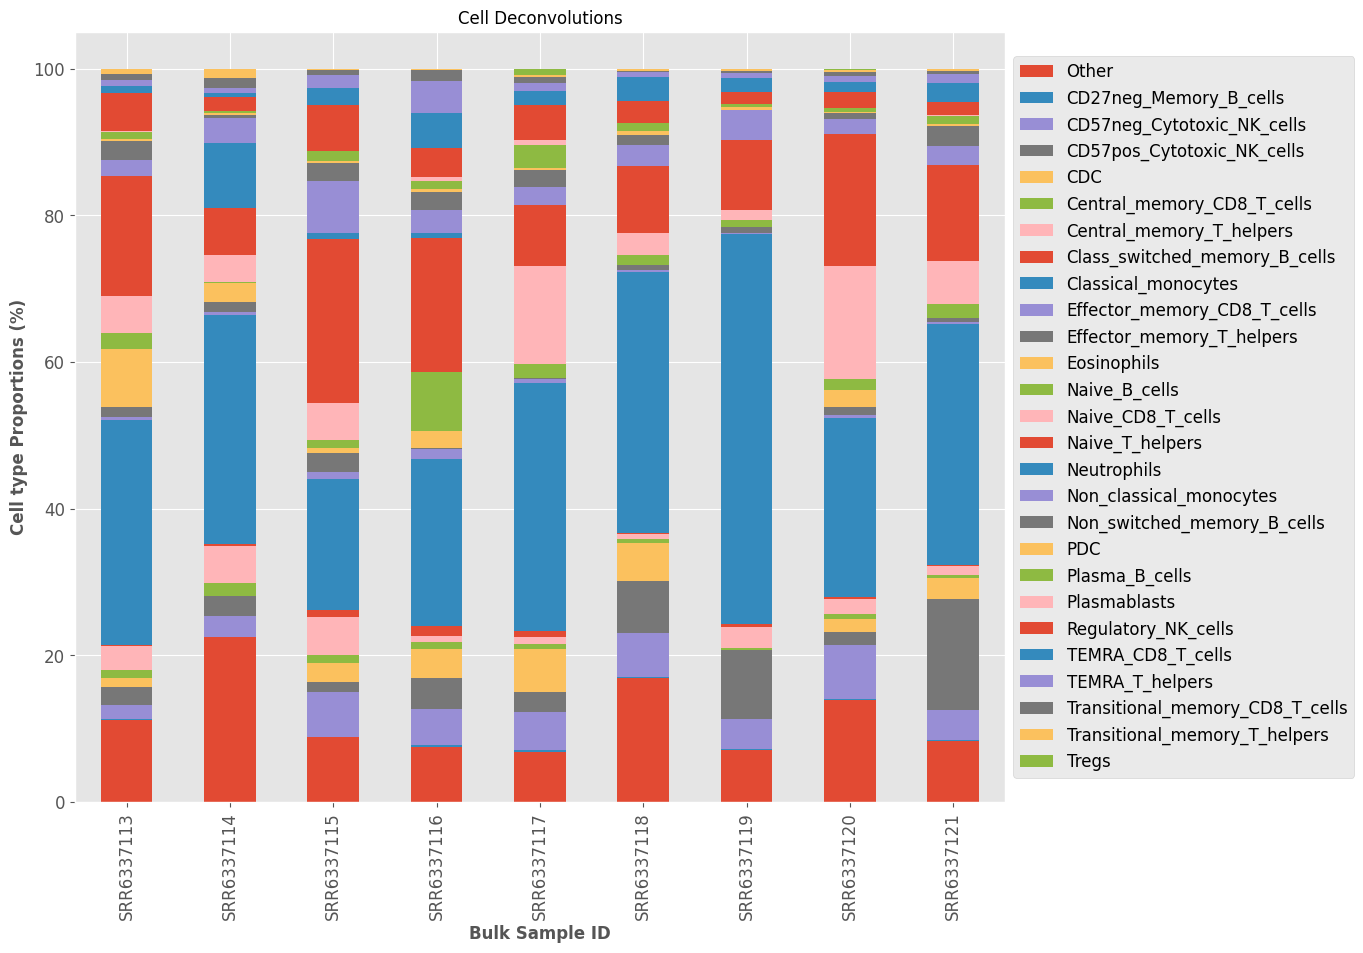

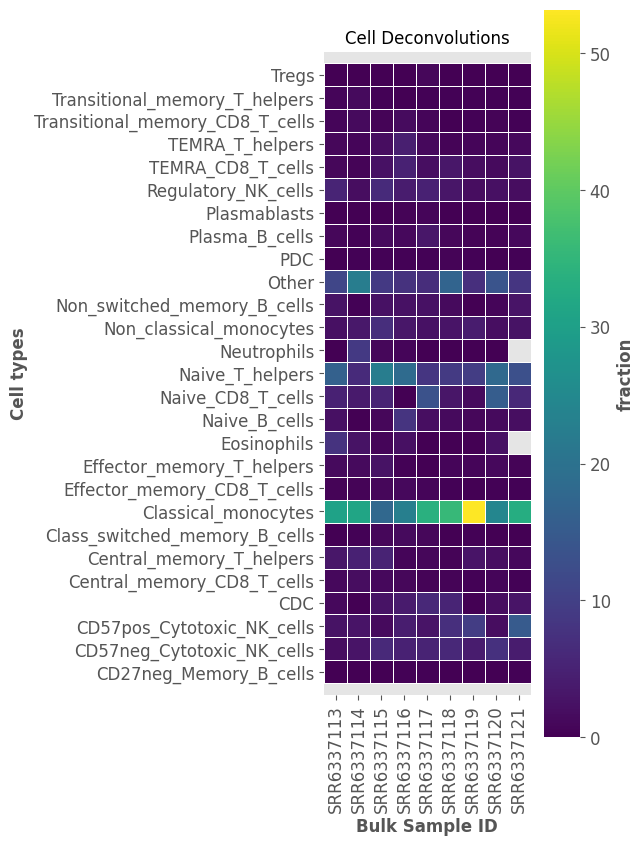

In [125]:
# cell proportion plots
plotter.stack_plot(k_preds_child.T)
plotter.heat_map(k_preds_child.T)

In [126]:
# check for intersections
flatten(k_preds_100, cytof1)

Index(['Neutrophils', 'Tregs', 'Monocytes', 'CD8_T_cells', 'CD4_T_cells',
       'B_cells', 'T_cells', 'NK_cells', 'Lymphocytes'],
      dtype='object')
Index(['SRR6337113', 'SRR6337114', 'SRR6337115', 'SRR6337116', 'SRR6337117',
       'SRR6337118', 'SRR6337119', 'SRR6337120', 'SRR6337121'],
      dtype='object')


array([[<AxesSubplot: title={'center': 'B_cells, corr = 0.56\np = 0.117'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD4_T_cells, corr = 0.353\np = 0.351'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD8_T_cells, corr = -0.074\np = 0.85'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'Lymphocytes, corr = 0.136\np = 0.726'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>],
       [<AxesSubplot: title={'center': 'Monocytes, corr = 0.082\np = 0.834'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'NK_cells, corr = 0.628\np = 0.07'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center':

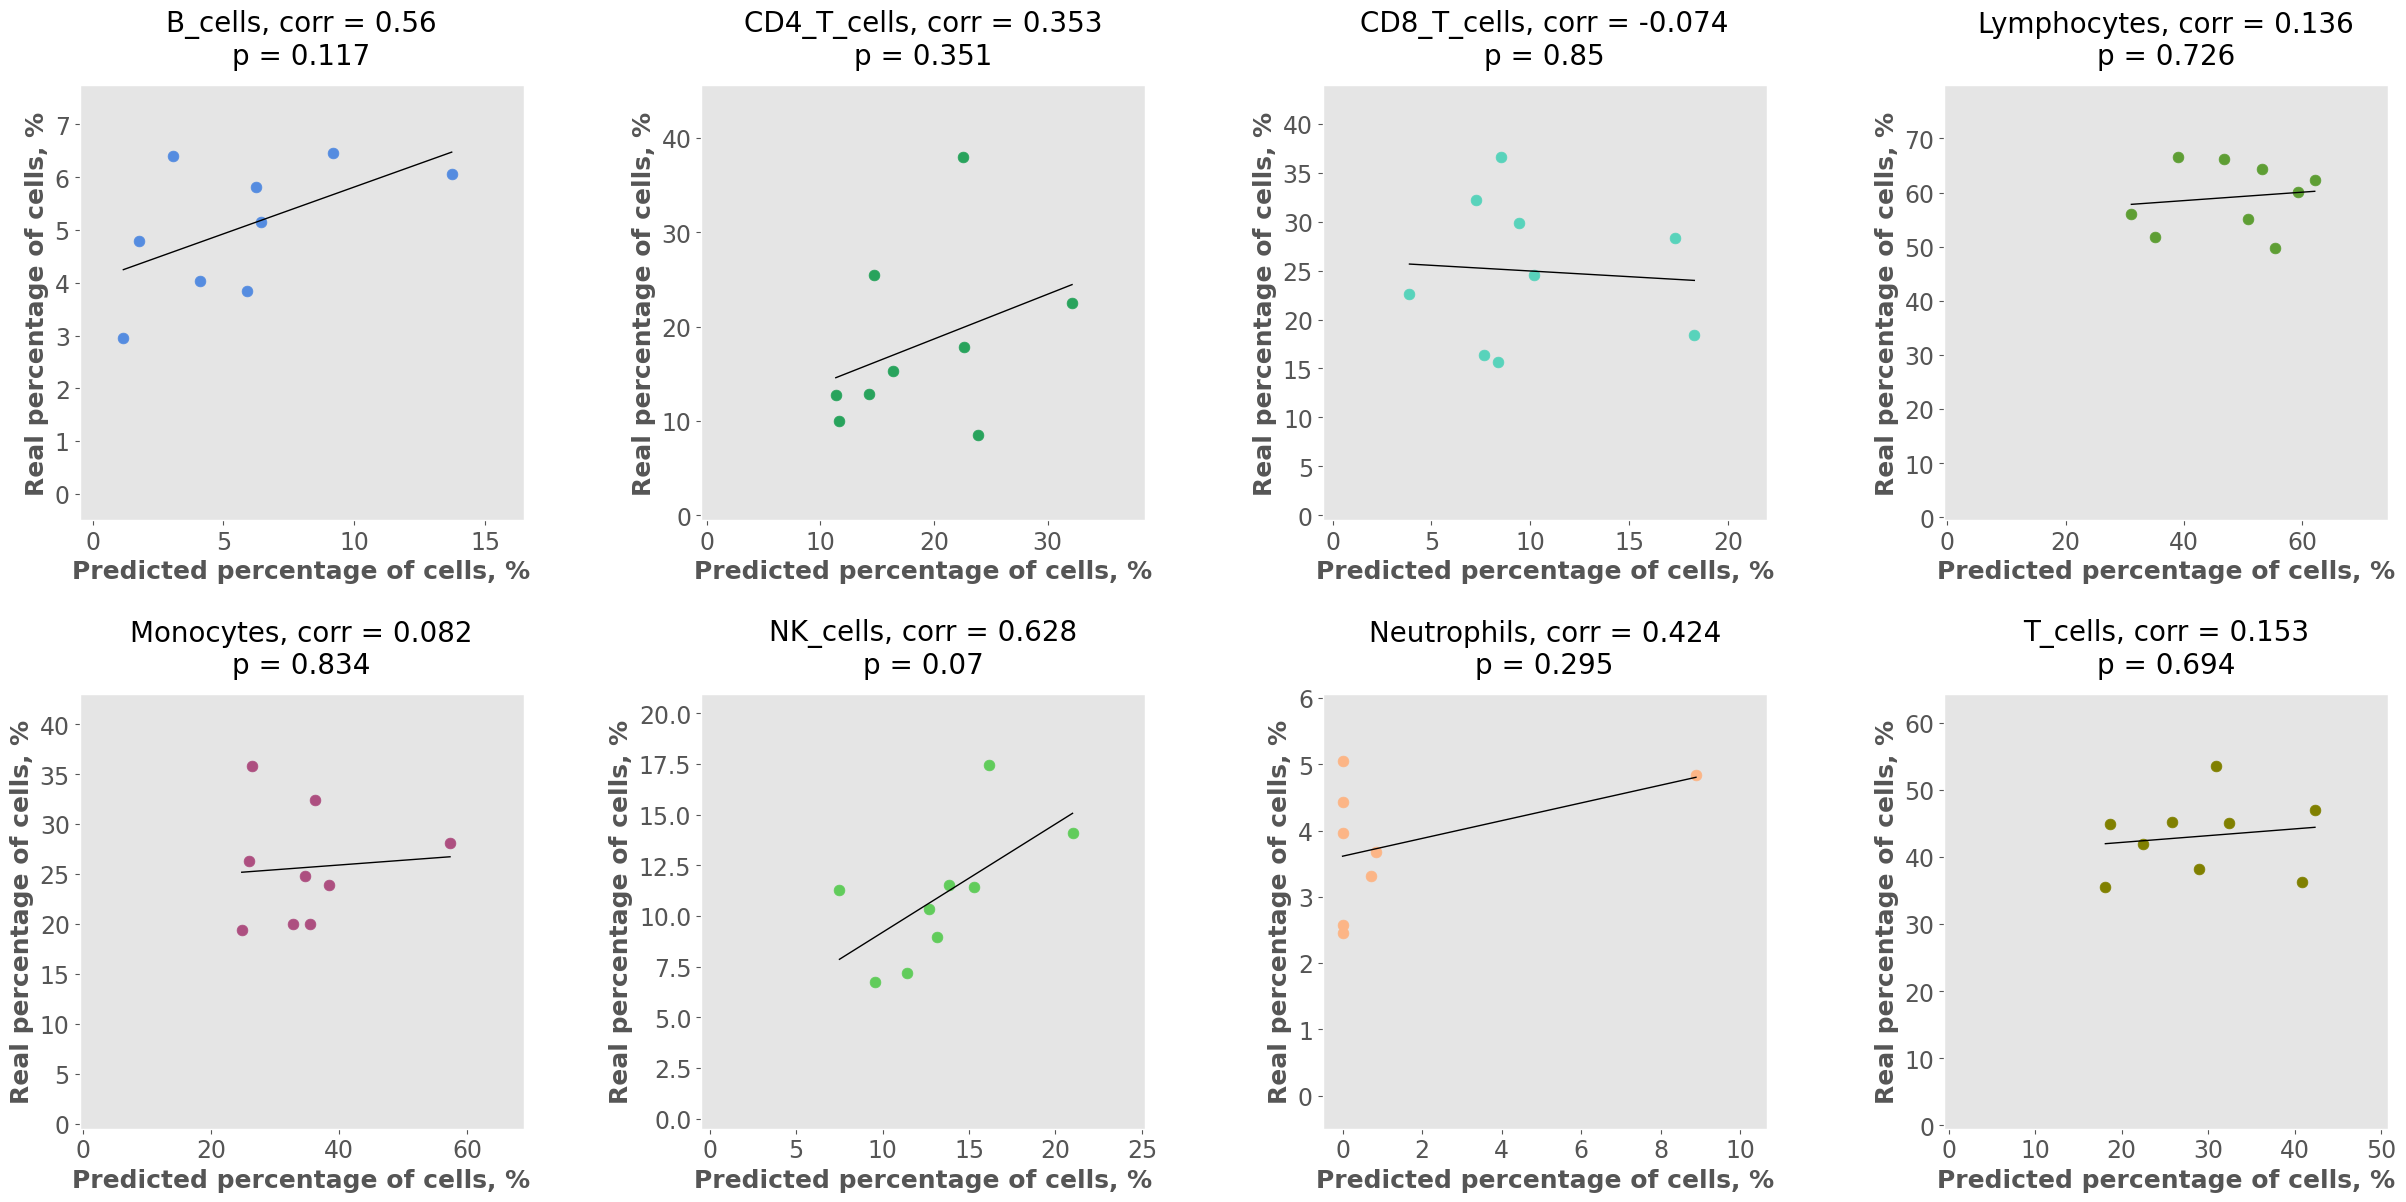

In [127]:
plotter.corr_plot(k_preds_100, cytof1, pallete=cells_p)

Statistical Tests
------------------------
RMSE: 11.275 
Pearson Correlation Coefficient: 0.827 
P value: 0.0 
R^2: 0.651


<AxesSubplot: title={'center': 'GSE107572'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>

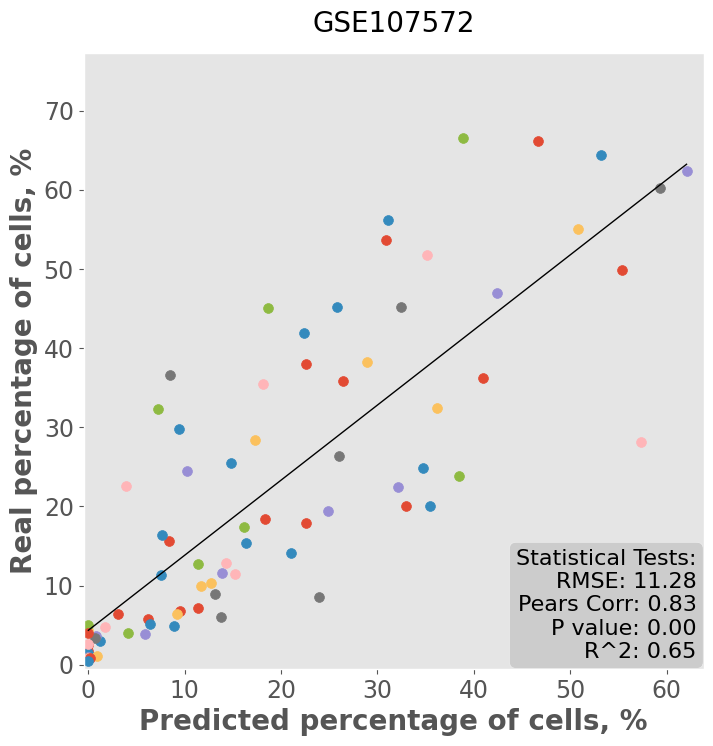

In [128]:
plotter.print_cell_whole(k_preds_100, cytof1, pallete = cells_p, title=title, stat=True)

array([[<AxesSubplot: title={'center': 'Bland Altman of B_cells: {0.672 +/- 3.381}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD4_T_cells: {0.702 +/- 9.419}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD8_T_cells: {-14.845 +/- 9.031}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of Lymphocytes: {-11.089 +/- 11.79}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of Monocytes: {9.057 +/- 10.975}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of NK_cells: {2.383 +/- 3.175}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <Axes

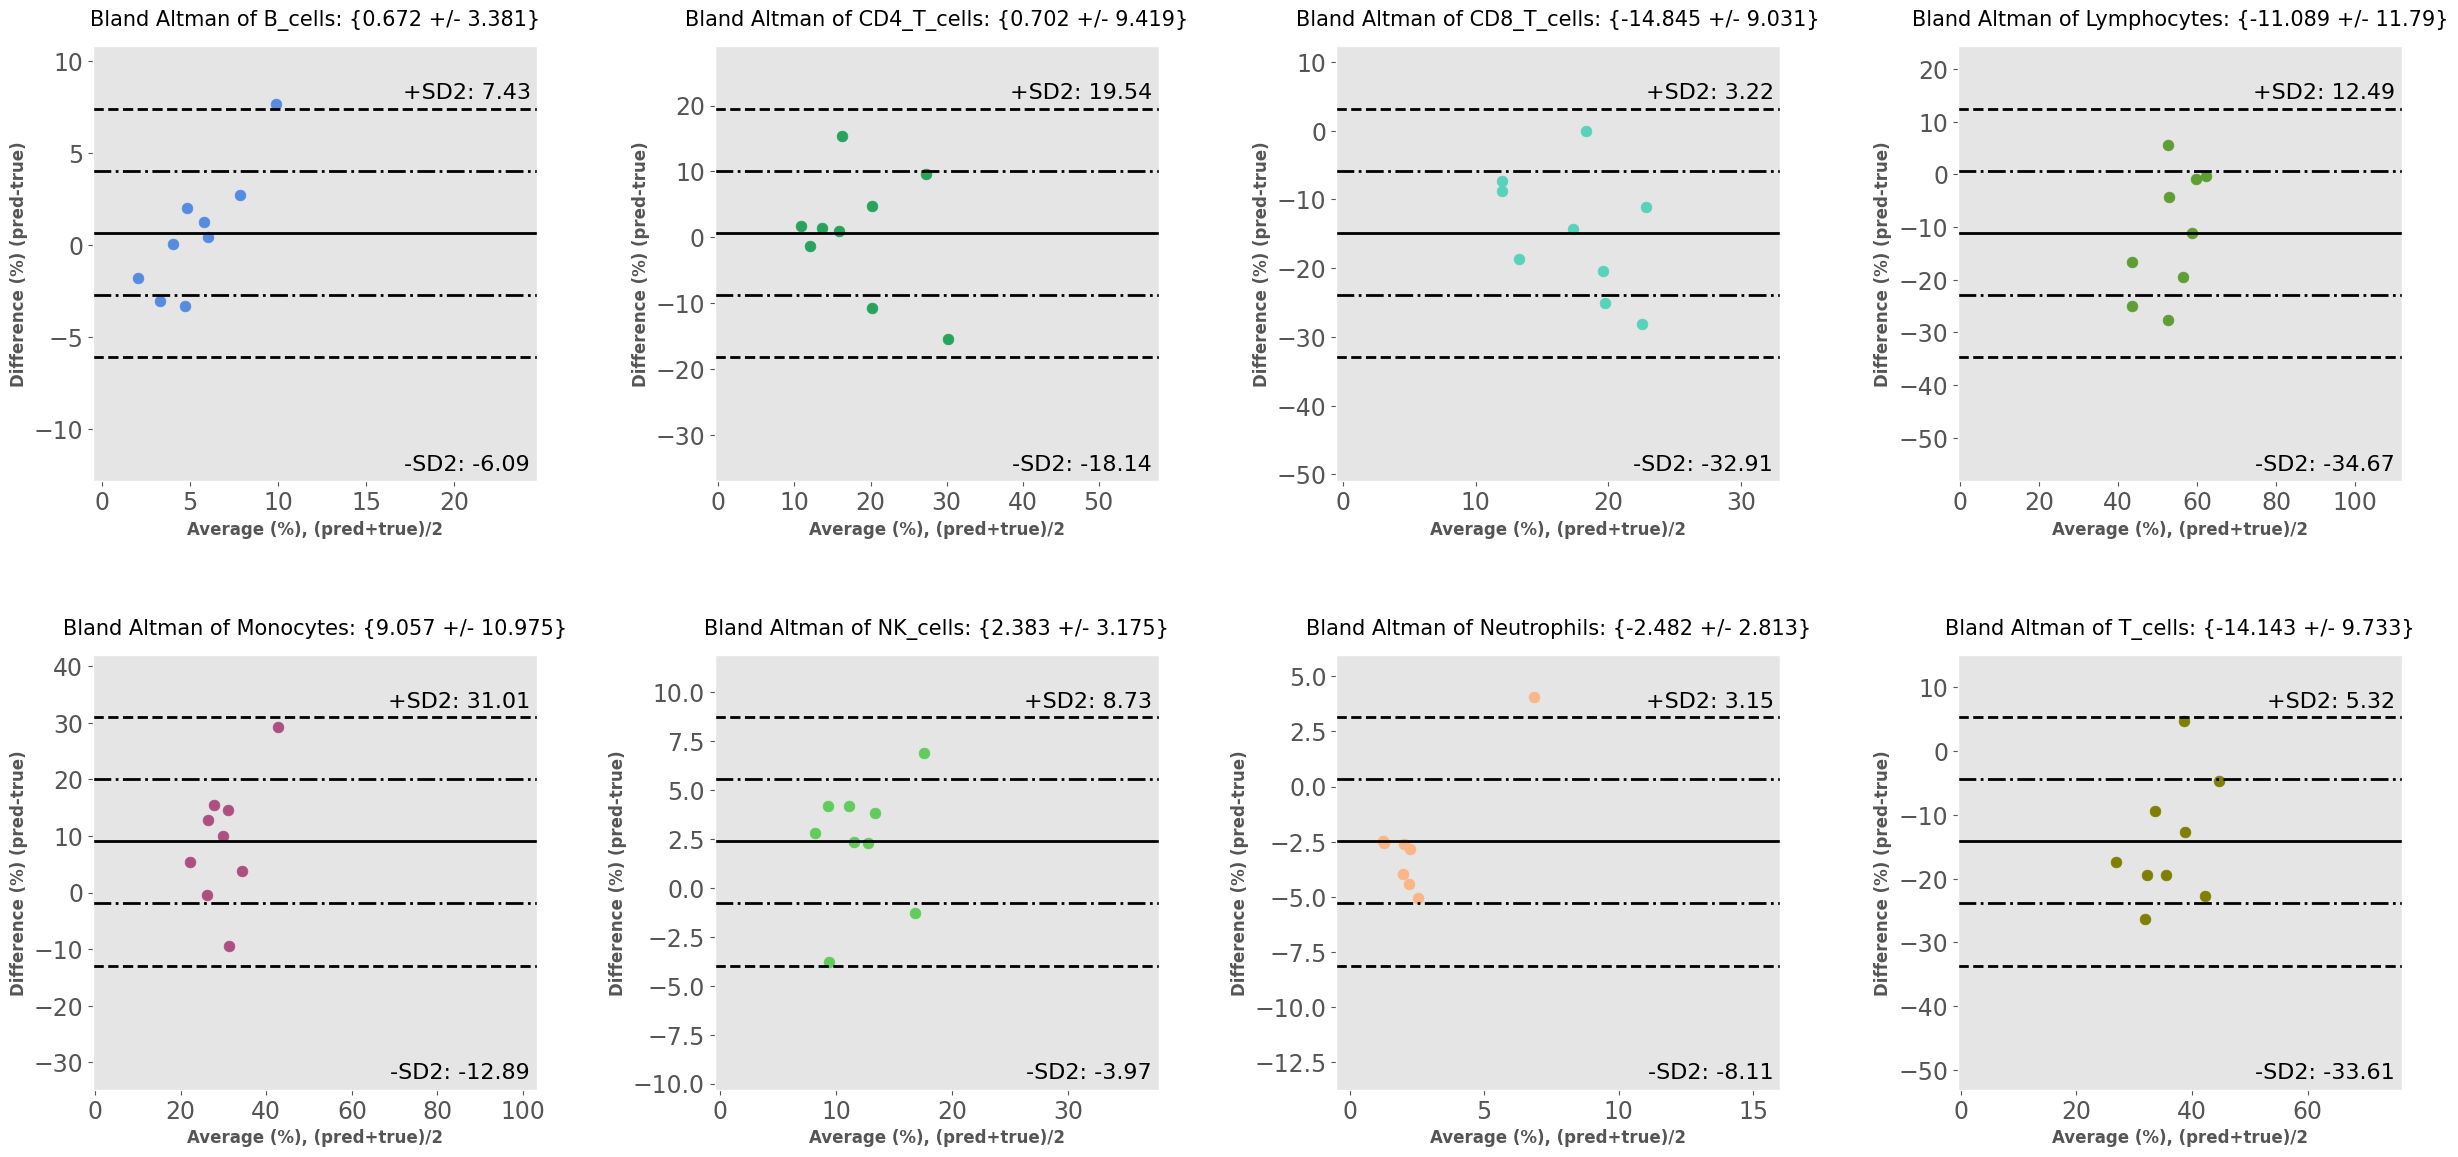

In [129]:
plotter.bland_altman(k_preds_100, cytof1, pallete = cells_p)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

array([[<AxesSubplot: title={'center': 'Bland Altman of SRR6337113: {-5.878 +/- 11.488}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337114: {-6.334 +/- 11.017}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337115: {-0.401 +/- 6.765}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337116: {-2.031 +/- 12.425}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of SRR6337117: {-2.083 +/- 5.461}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of SRR6337118: {-8.104 +/- 14.725}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
     

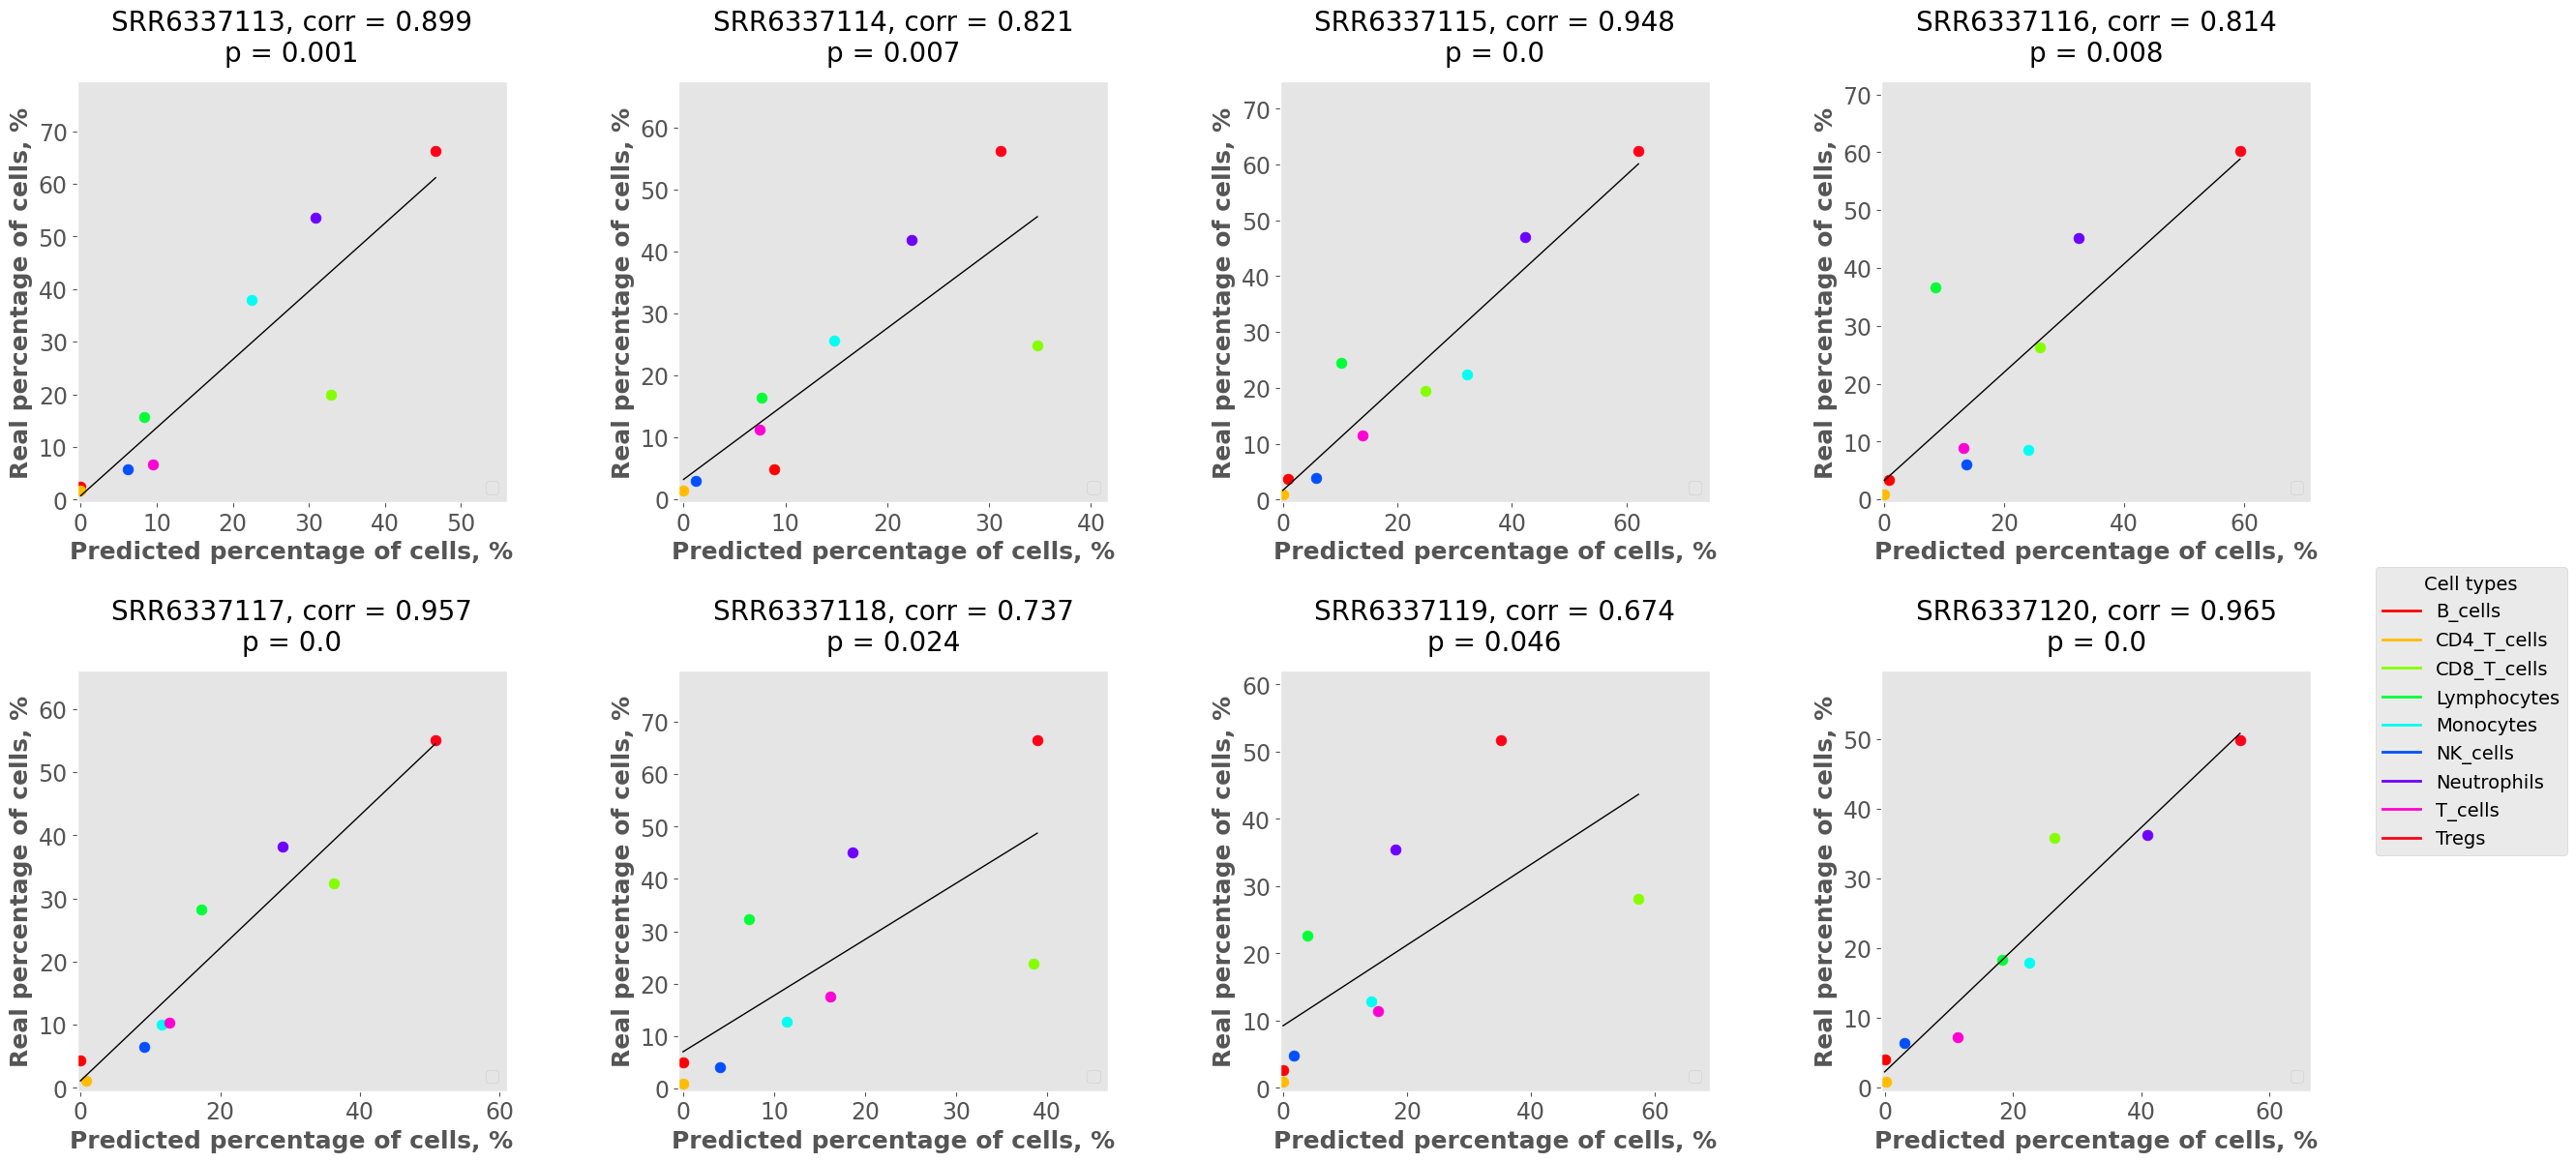

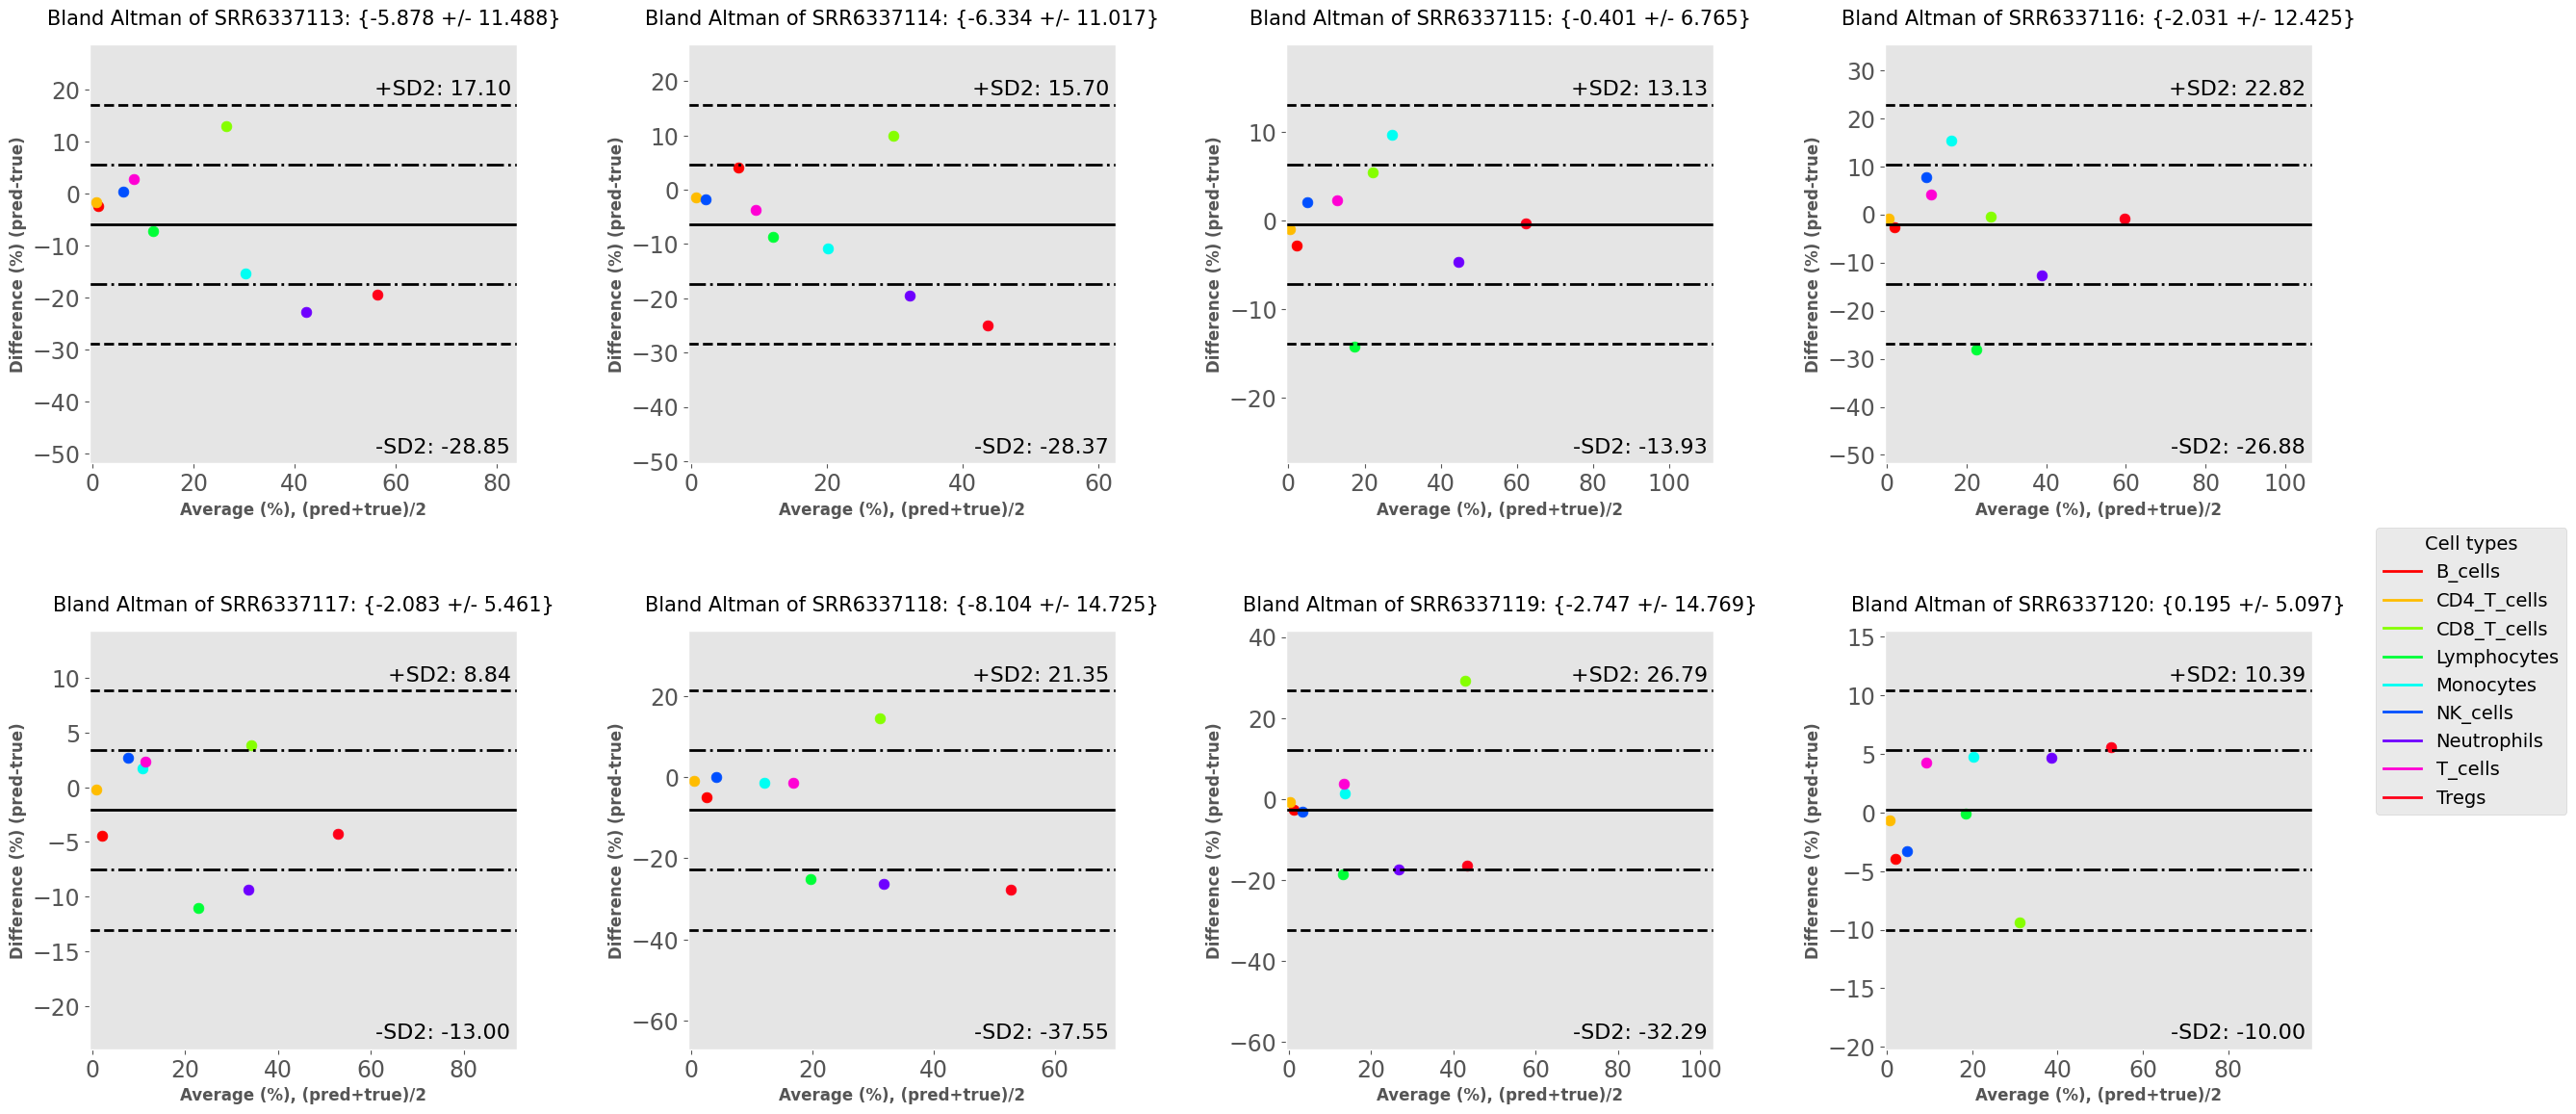

In [136]:
# get a color pallete for color samples
ind_names = k_preds_100.index.intersection(cytof1.index)
sample_color = plotter.get_cmap(len(ind_names))
plotter.plot_sample(k_preds_100, cytof1, pallete = sample_color)
plotter.bland_altman_v2(k_preds_100, cytof1, pallete = sample_color)

#### Fit Second Dataset

In [139]:
k_preds2 = model.predict(bulk2) 
k_preds2.loc['Lymphocytes'] = k_preds2.loc[['B_cells', 'T_cells', 'NK_cells']].sum()
k_preds2_100 = k_preds2 * 100

# drop parent nodes so we can plot child nodes stack plots
parent_nodes = ['Non_plasma_B_cells', 'Monocytes', 'Granulocytes', 'B_cells', 'T_cells', 'NK_cells', 'Myeloid_cells', 'Lymphoid_cells', 'Lymphocytes', 'CD8_T_cells', 'Cytotoxic_NK_cells', 'CD4_T_cells', 'Memory_T_helpers', 'Memory_CD8_T_cells']
k_preds2_child = k_preds2_100.drop(parent_nodes)

Expressions OK


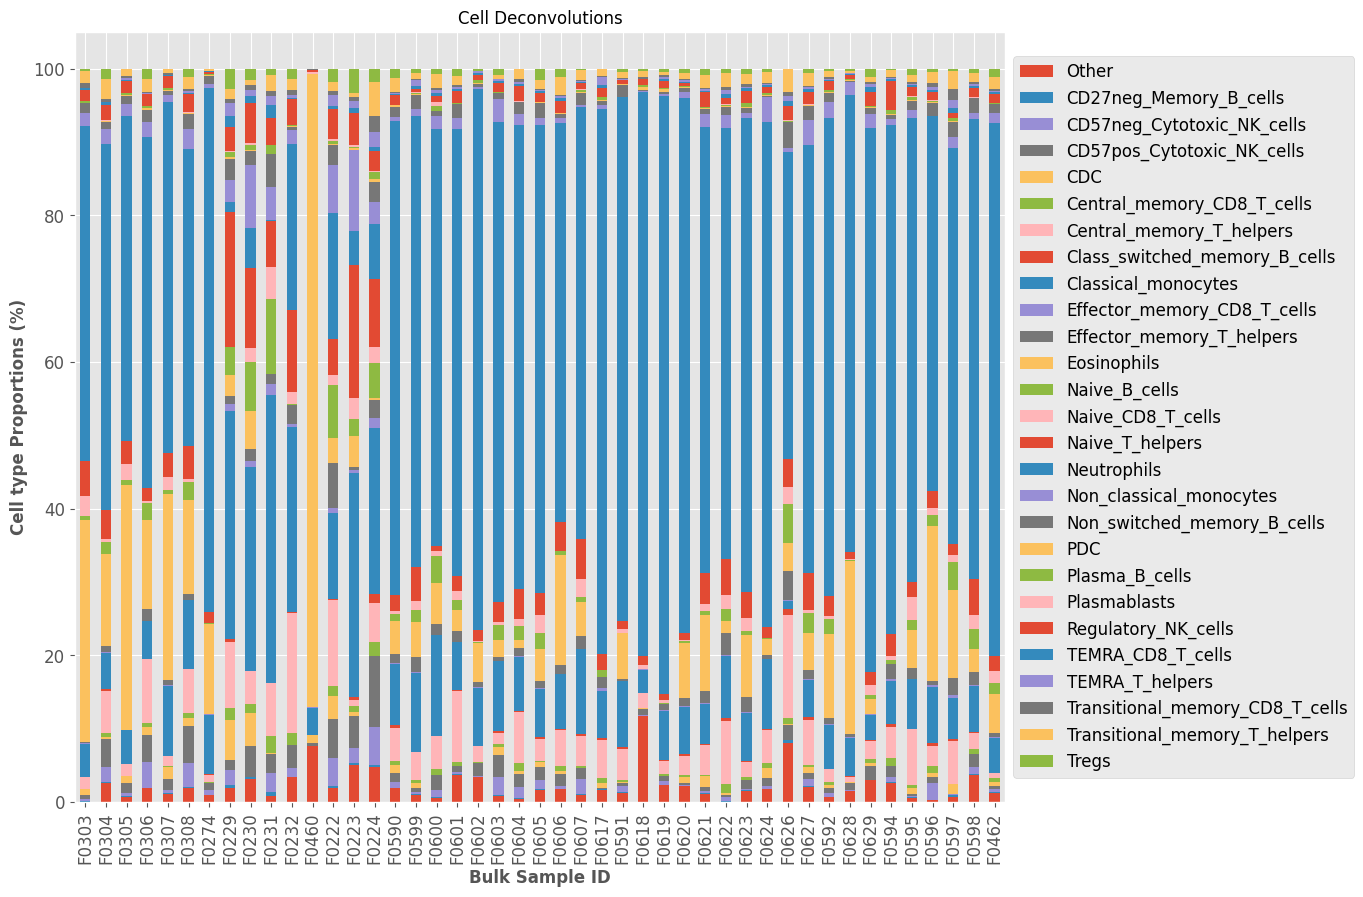

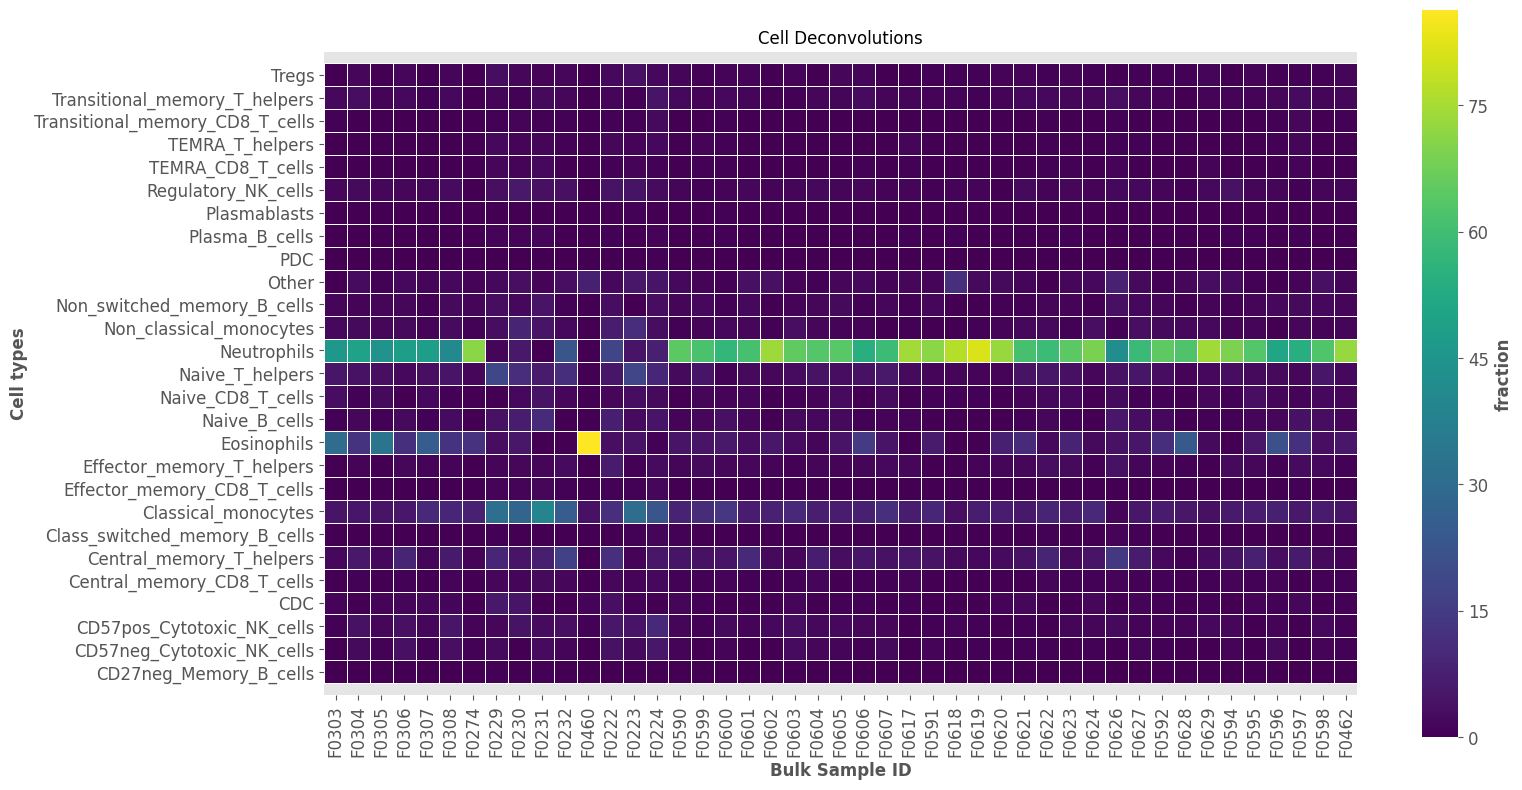

In [140]:
# cell proportion plots
plotter.stack_plot(k_preds2_child.T)
plotter.heat_map(k_preds2_child.T)

In [141]:
# check for intersections
flatten(k_preds2_100, cytof2)

Index(['CD27neg_Memory_B_cells', 'CD57neg_Cytotoxic_NK_cells',
       'CD57pos_Cytotoxic_NK_cells', 'CDC', 'Central_memory_CD8_T_cells',
       'Central_memory_T_helpers', 'Class_switched_memory_B_cells',
       'Classical_monocytes', 'Effector_memory_CD8_T_cells',
       'Effector_memory_T_helpers', 'Eosinophils', 'Naive_B_cells',
       'Naive_CD8_T_cells', 'Naive_T_helpers', 'Neutrophils',
       'Non_classical_monocytes', 'Non_switched_memory_B_cells', 'PDC',
       'Plasma_B_cells', 'Plasmablasts', 'Regulatory_NK_cells',
       'TEMRA_CD8_T_cells', 'TEMRA_T_helpers',
       'Transitional_memory_CD8_T_cells', 'Transitional_memory_T_helpers',
       'Tregs', 'Non_plasma_B_cells', 'Monocytes', 'Memory_T_helpers',
       'Memory_CD8_T_cells', 'Granulocytes', 'Cytotoxic_NK_cells',
       'CD8_T_cells', 'CD4_T_cells', 'B_cells', 'T_cells', 'NK_cells',
       'Myeloid_cells', 'Lymphoid_cells', 'Lymphocytes'],
      dtype='object')
Index(['F0303', 'F0304', 'F0305', 'F0306', 'F0307', 'F030

array([[<AxesSubplot: title={'center': 'B_cells, corr = 0.883\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD27neg_Memory_B_cells, corr = 0.64\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD4_T_cells, corr = 0.589\np = 0.001'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD57neg_Cytotoxic_NK_cells, corr = 0.757\np = 0.004'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>],
       [<AxesSubplot: title={'center': 'CD57pos_Cytotoxic_NK_cells, corr = -0.465\np = 0.128'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD8_T_cells, corr = 0.673\np = 0.0'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %

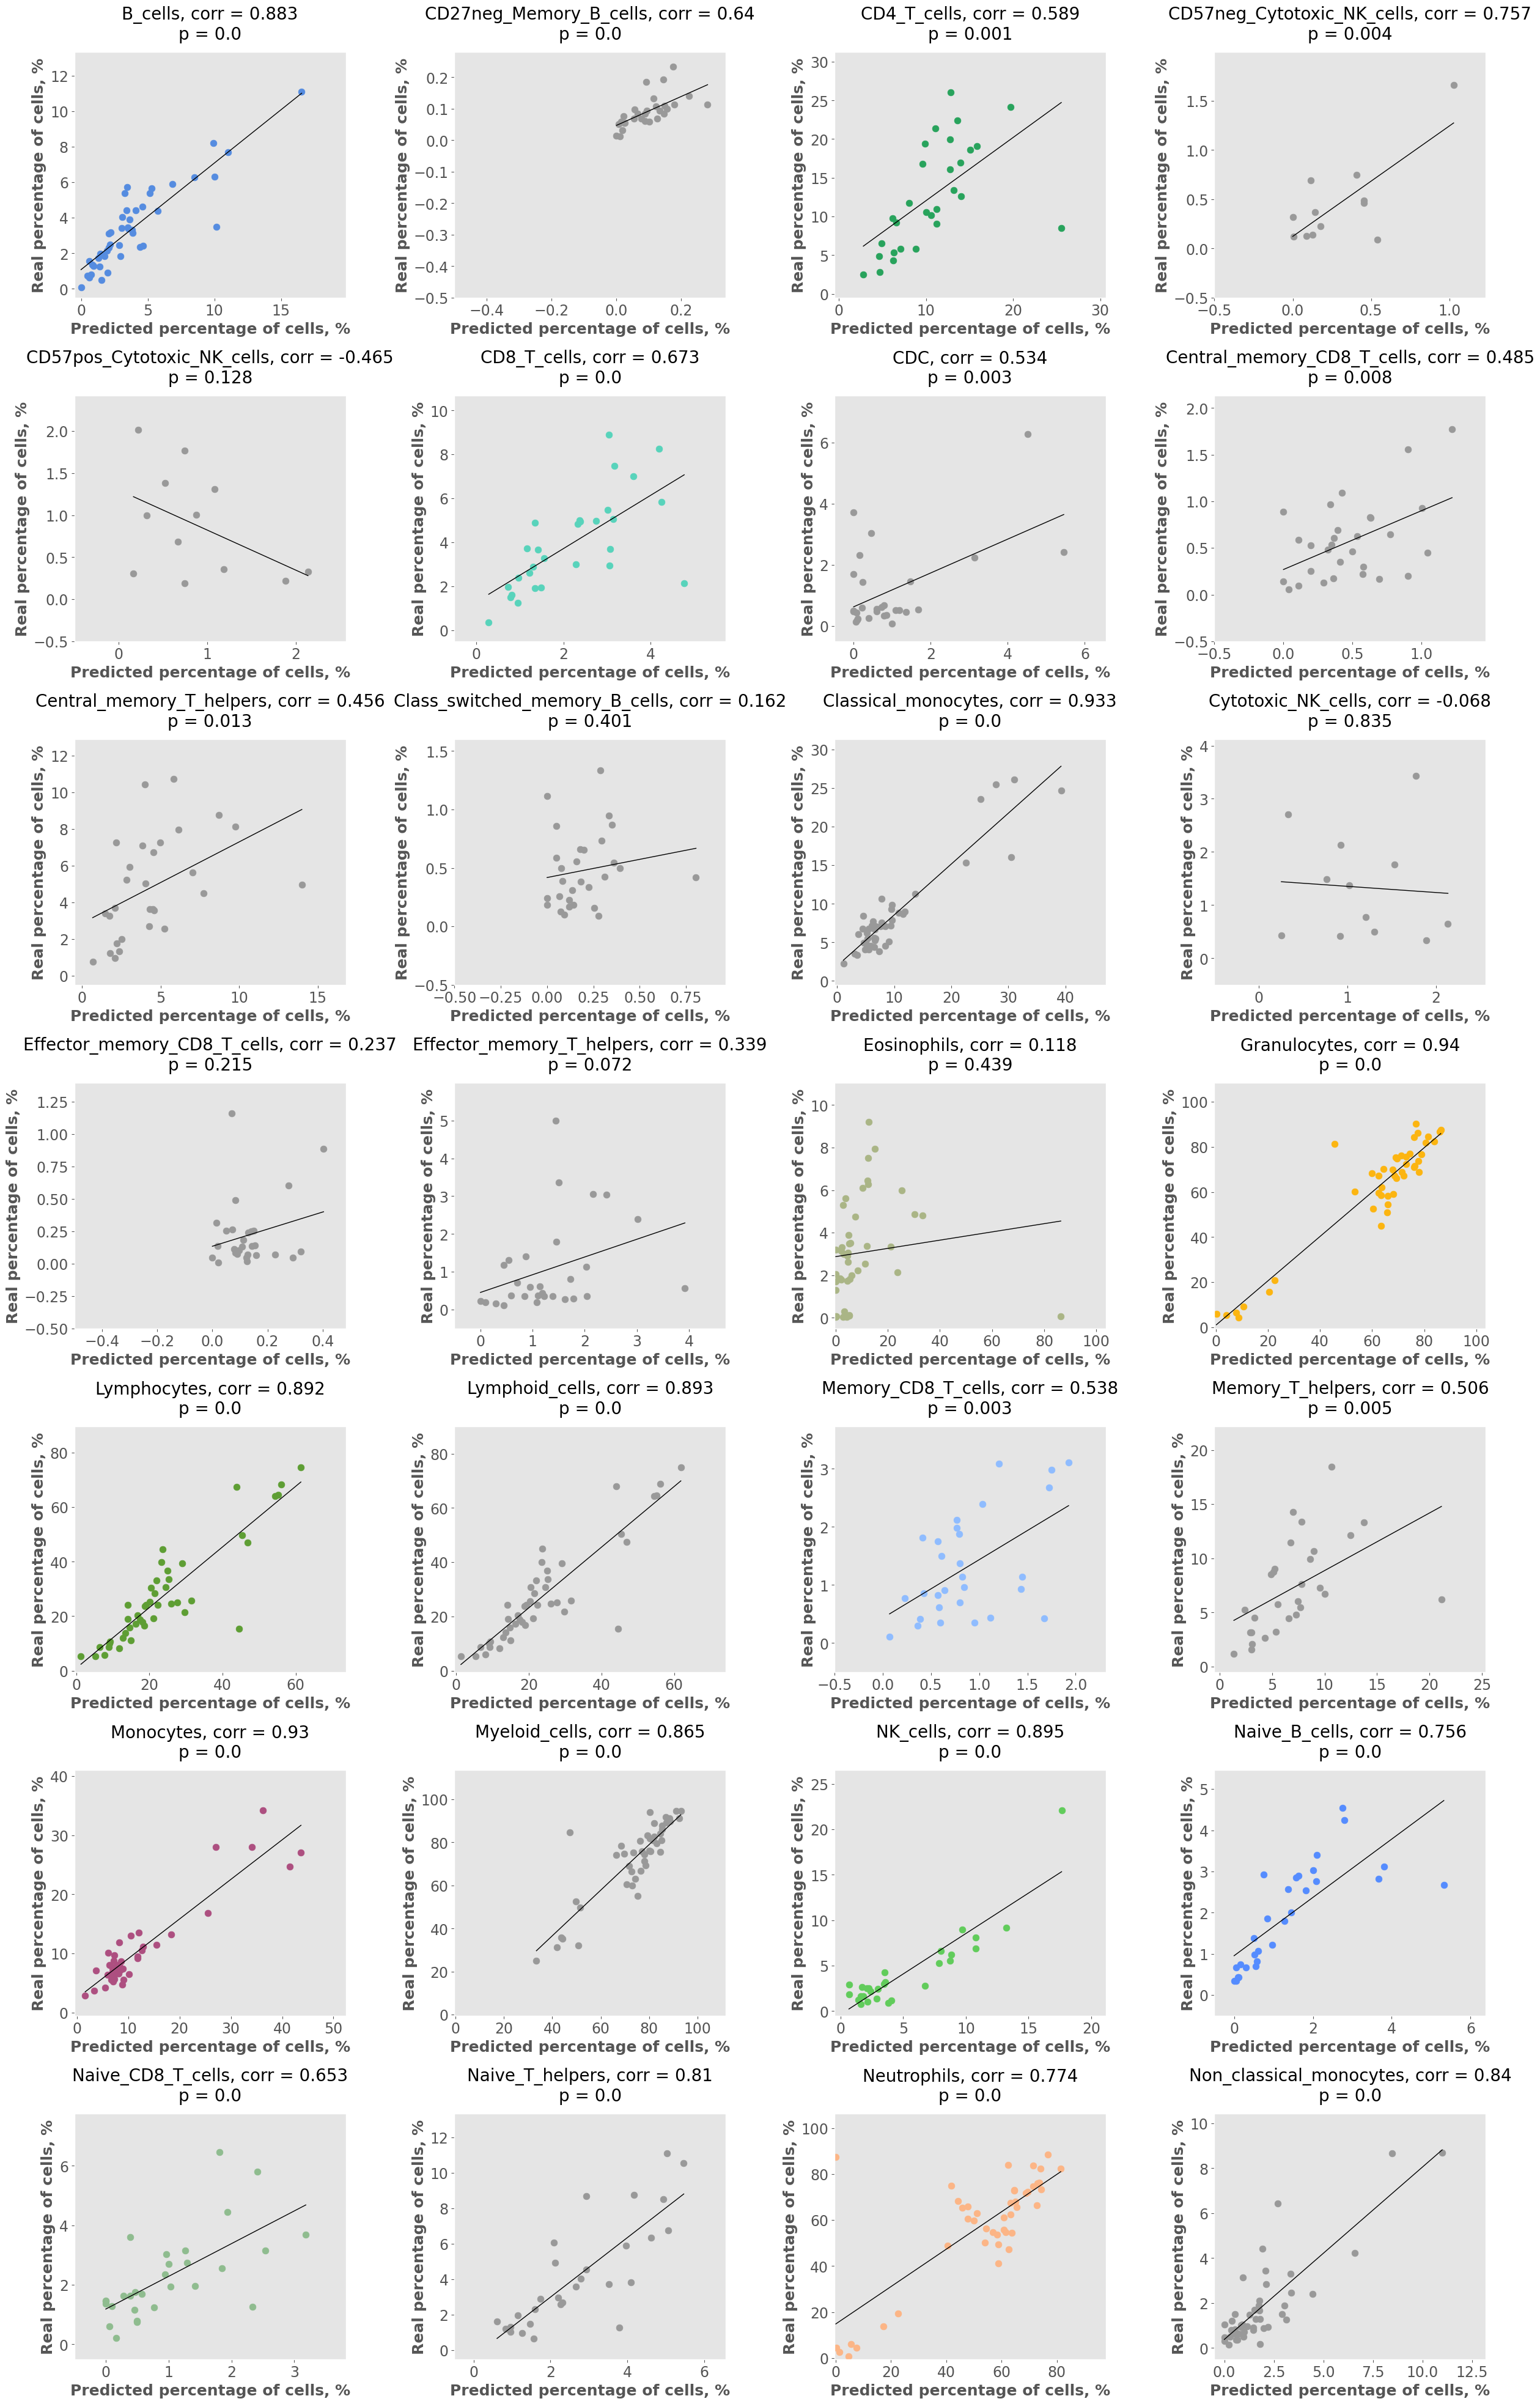

In [142]:
plotter.corr_plot(k_preds2_100, cytof2, pallete=cells_p)

Statistical Tests
------------------------
RMSE: 5.315 
Pearson Correlation Coefficient: 0.97 
P value: 0.0 
R^2: 0.94


<AxesSubplot: title={'center': 'GSE107572'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>

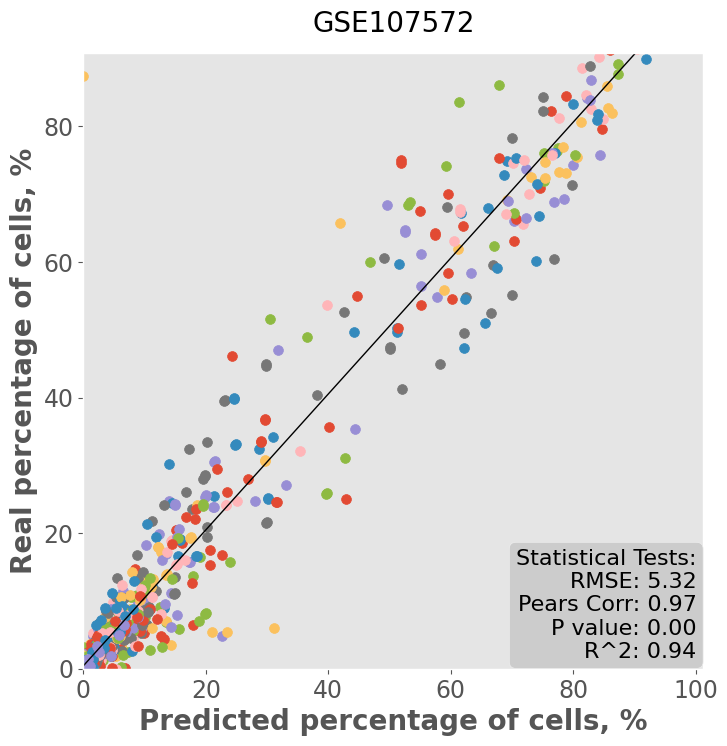

In [169]:
plotter.print_cell_whole(k_preds2_100, cytof2, pallete = cells_p, title=title, stat=True)

array([[<AxesSubplot: title={'center': 'Bland Altman of B_cells: {0.724 +/- 1.406}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD27neg_Memory_B_cells: {0.018 +/- 0.064}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD4_T_cells: {-2.644 +/- 4.567}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD57neg_Cytotoxic_NK_cells: {0.129 +/- 0.439}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of CD57pos_Cytotoxic_NK_cells: {-0.305 +/- 0.505}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD8_T_cells: {-1.457 +/- 1.563}'}, xlabel='Average (%), (pred+true)/2', ylabel=

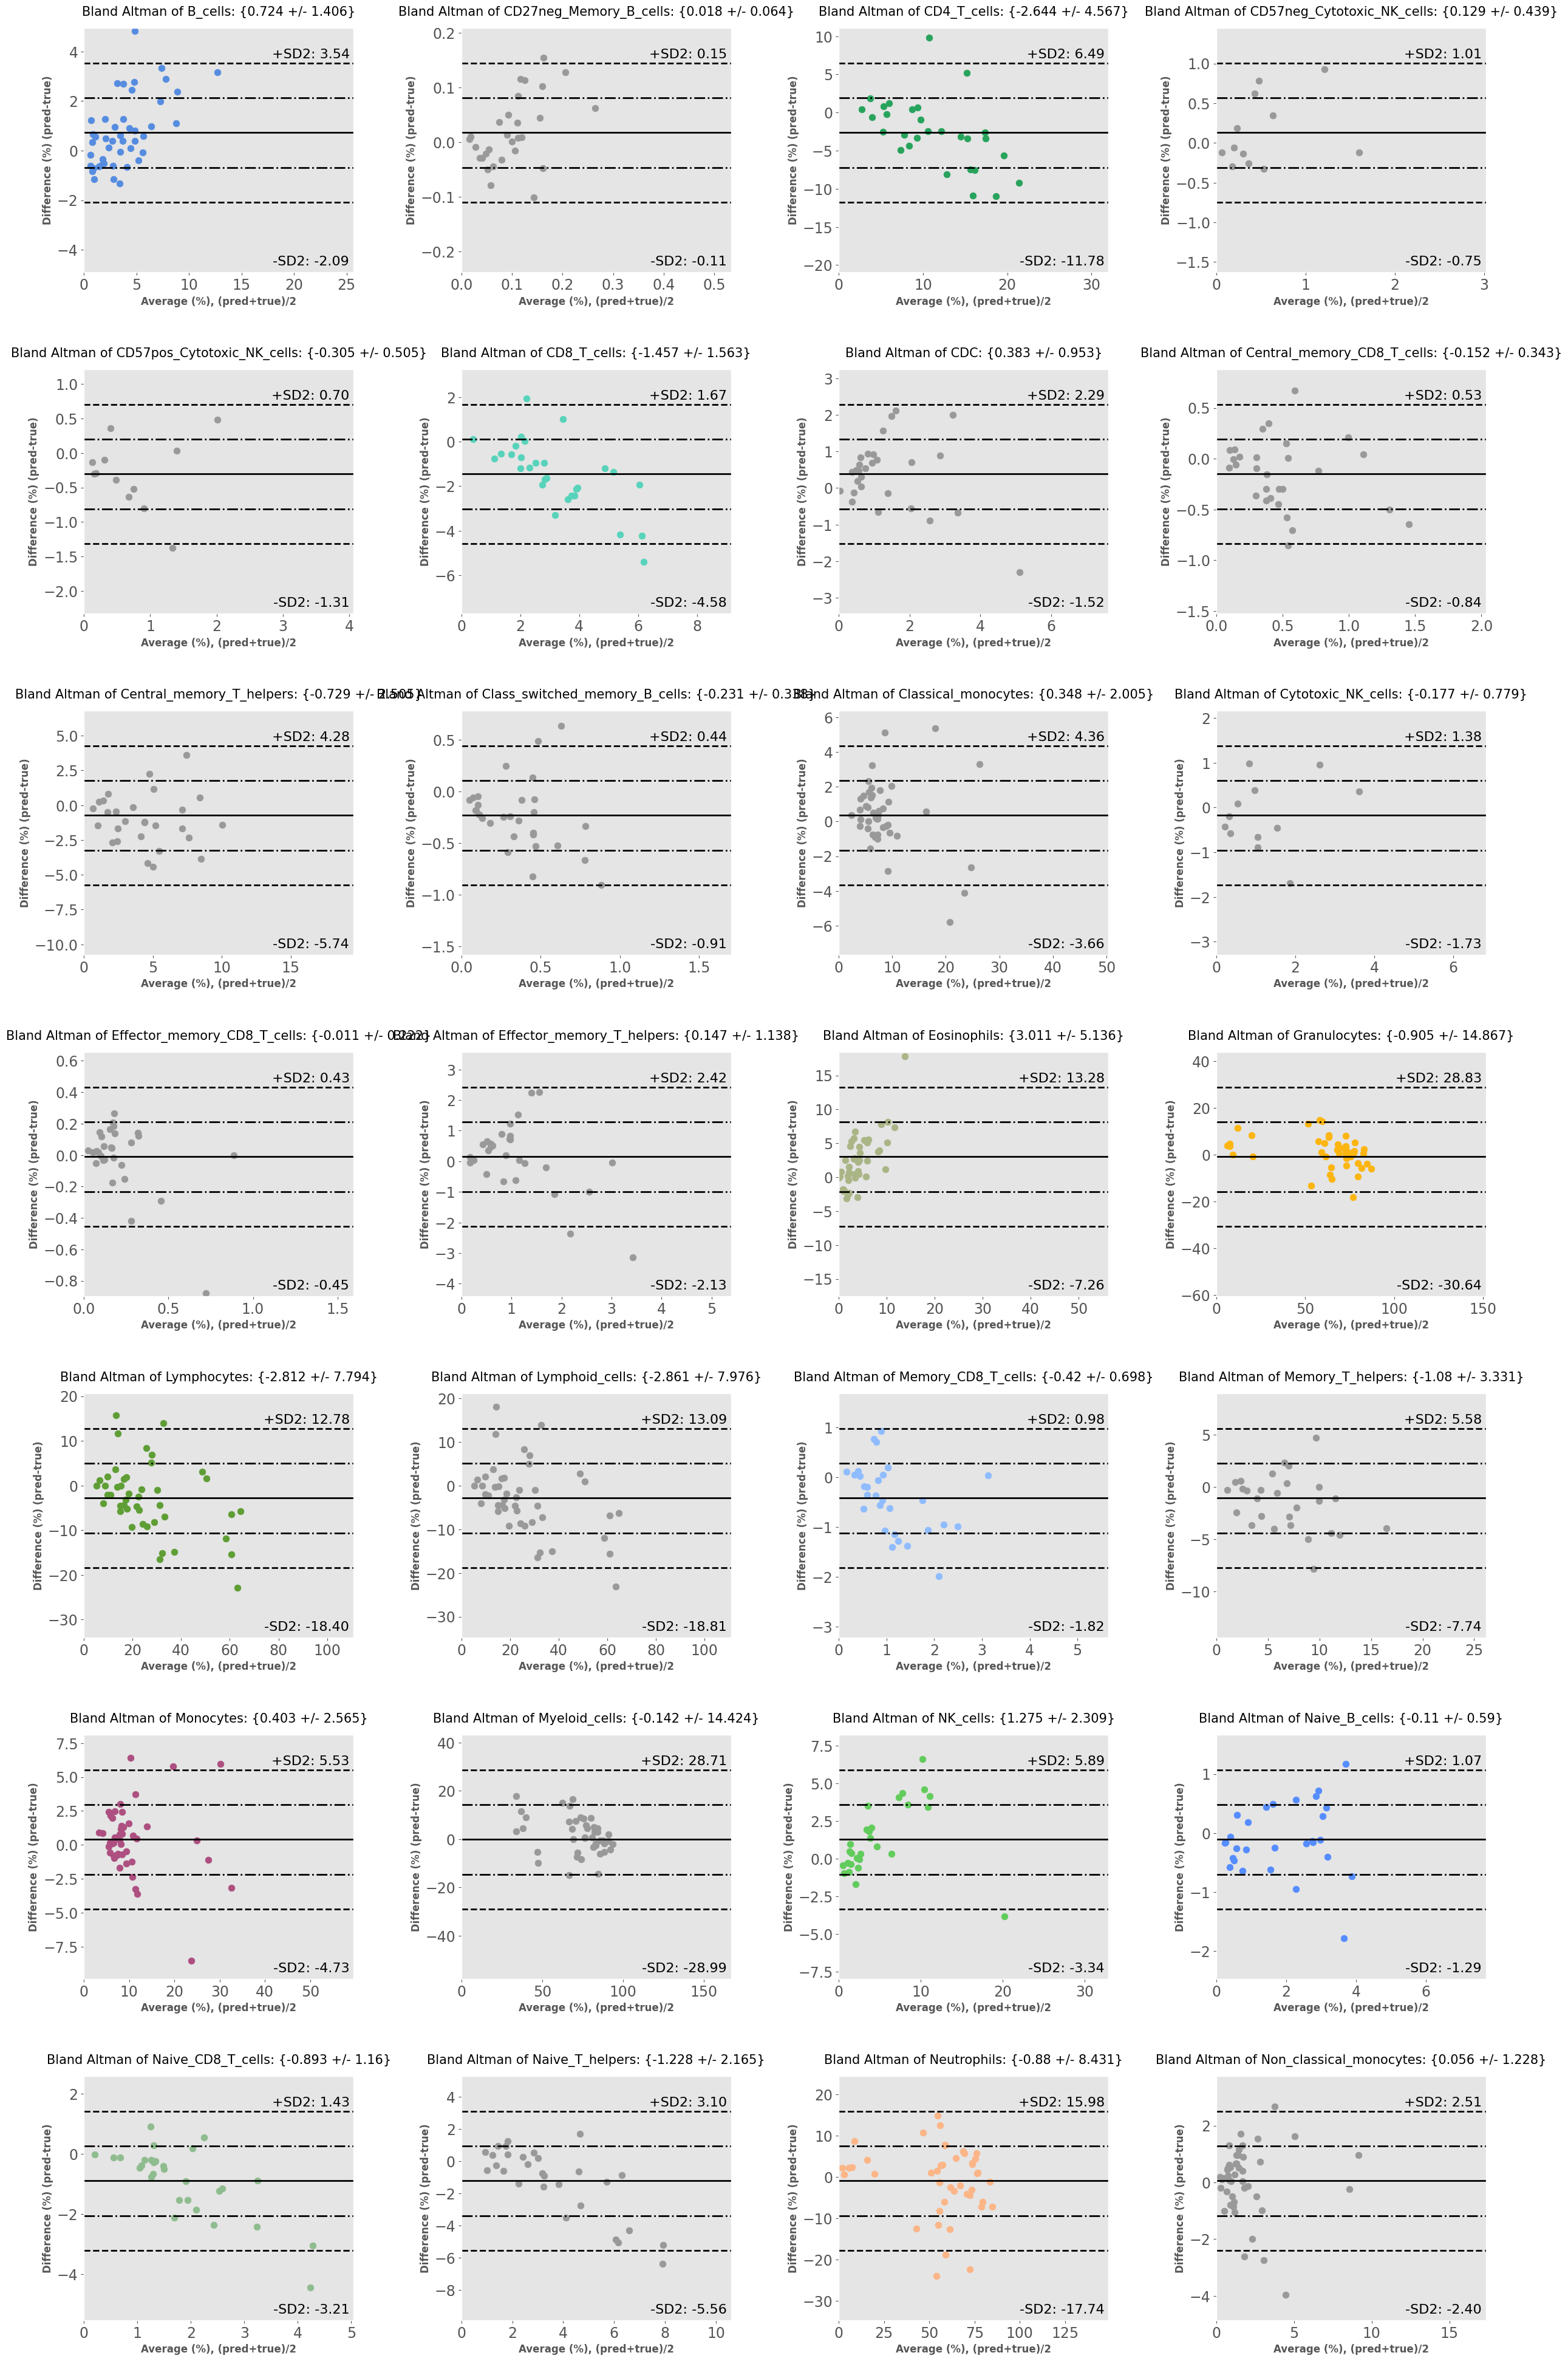

In [176]:
plotter.bland_altman(k_preds2_100, cytof2, pallete = cells_p)

array([[<AxesSubplot: title={'center': 'Bland Altman of F0222: {-0.312 +/- 8.488}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of F0223: {-0.623 +/- 14.189}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of F0224: {-0.752 +/- 7.56}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of F0229: {-0.426 +/- 6.824}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of F0230: {-0.267 +/- 3.245}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of F0231: {0.096 +/- 9.341}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': '

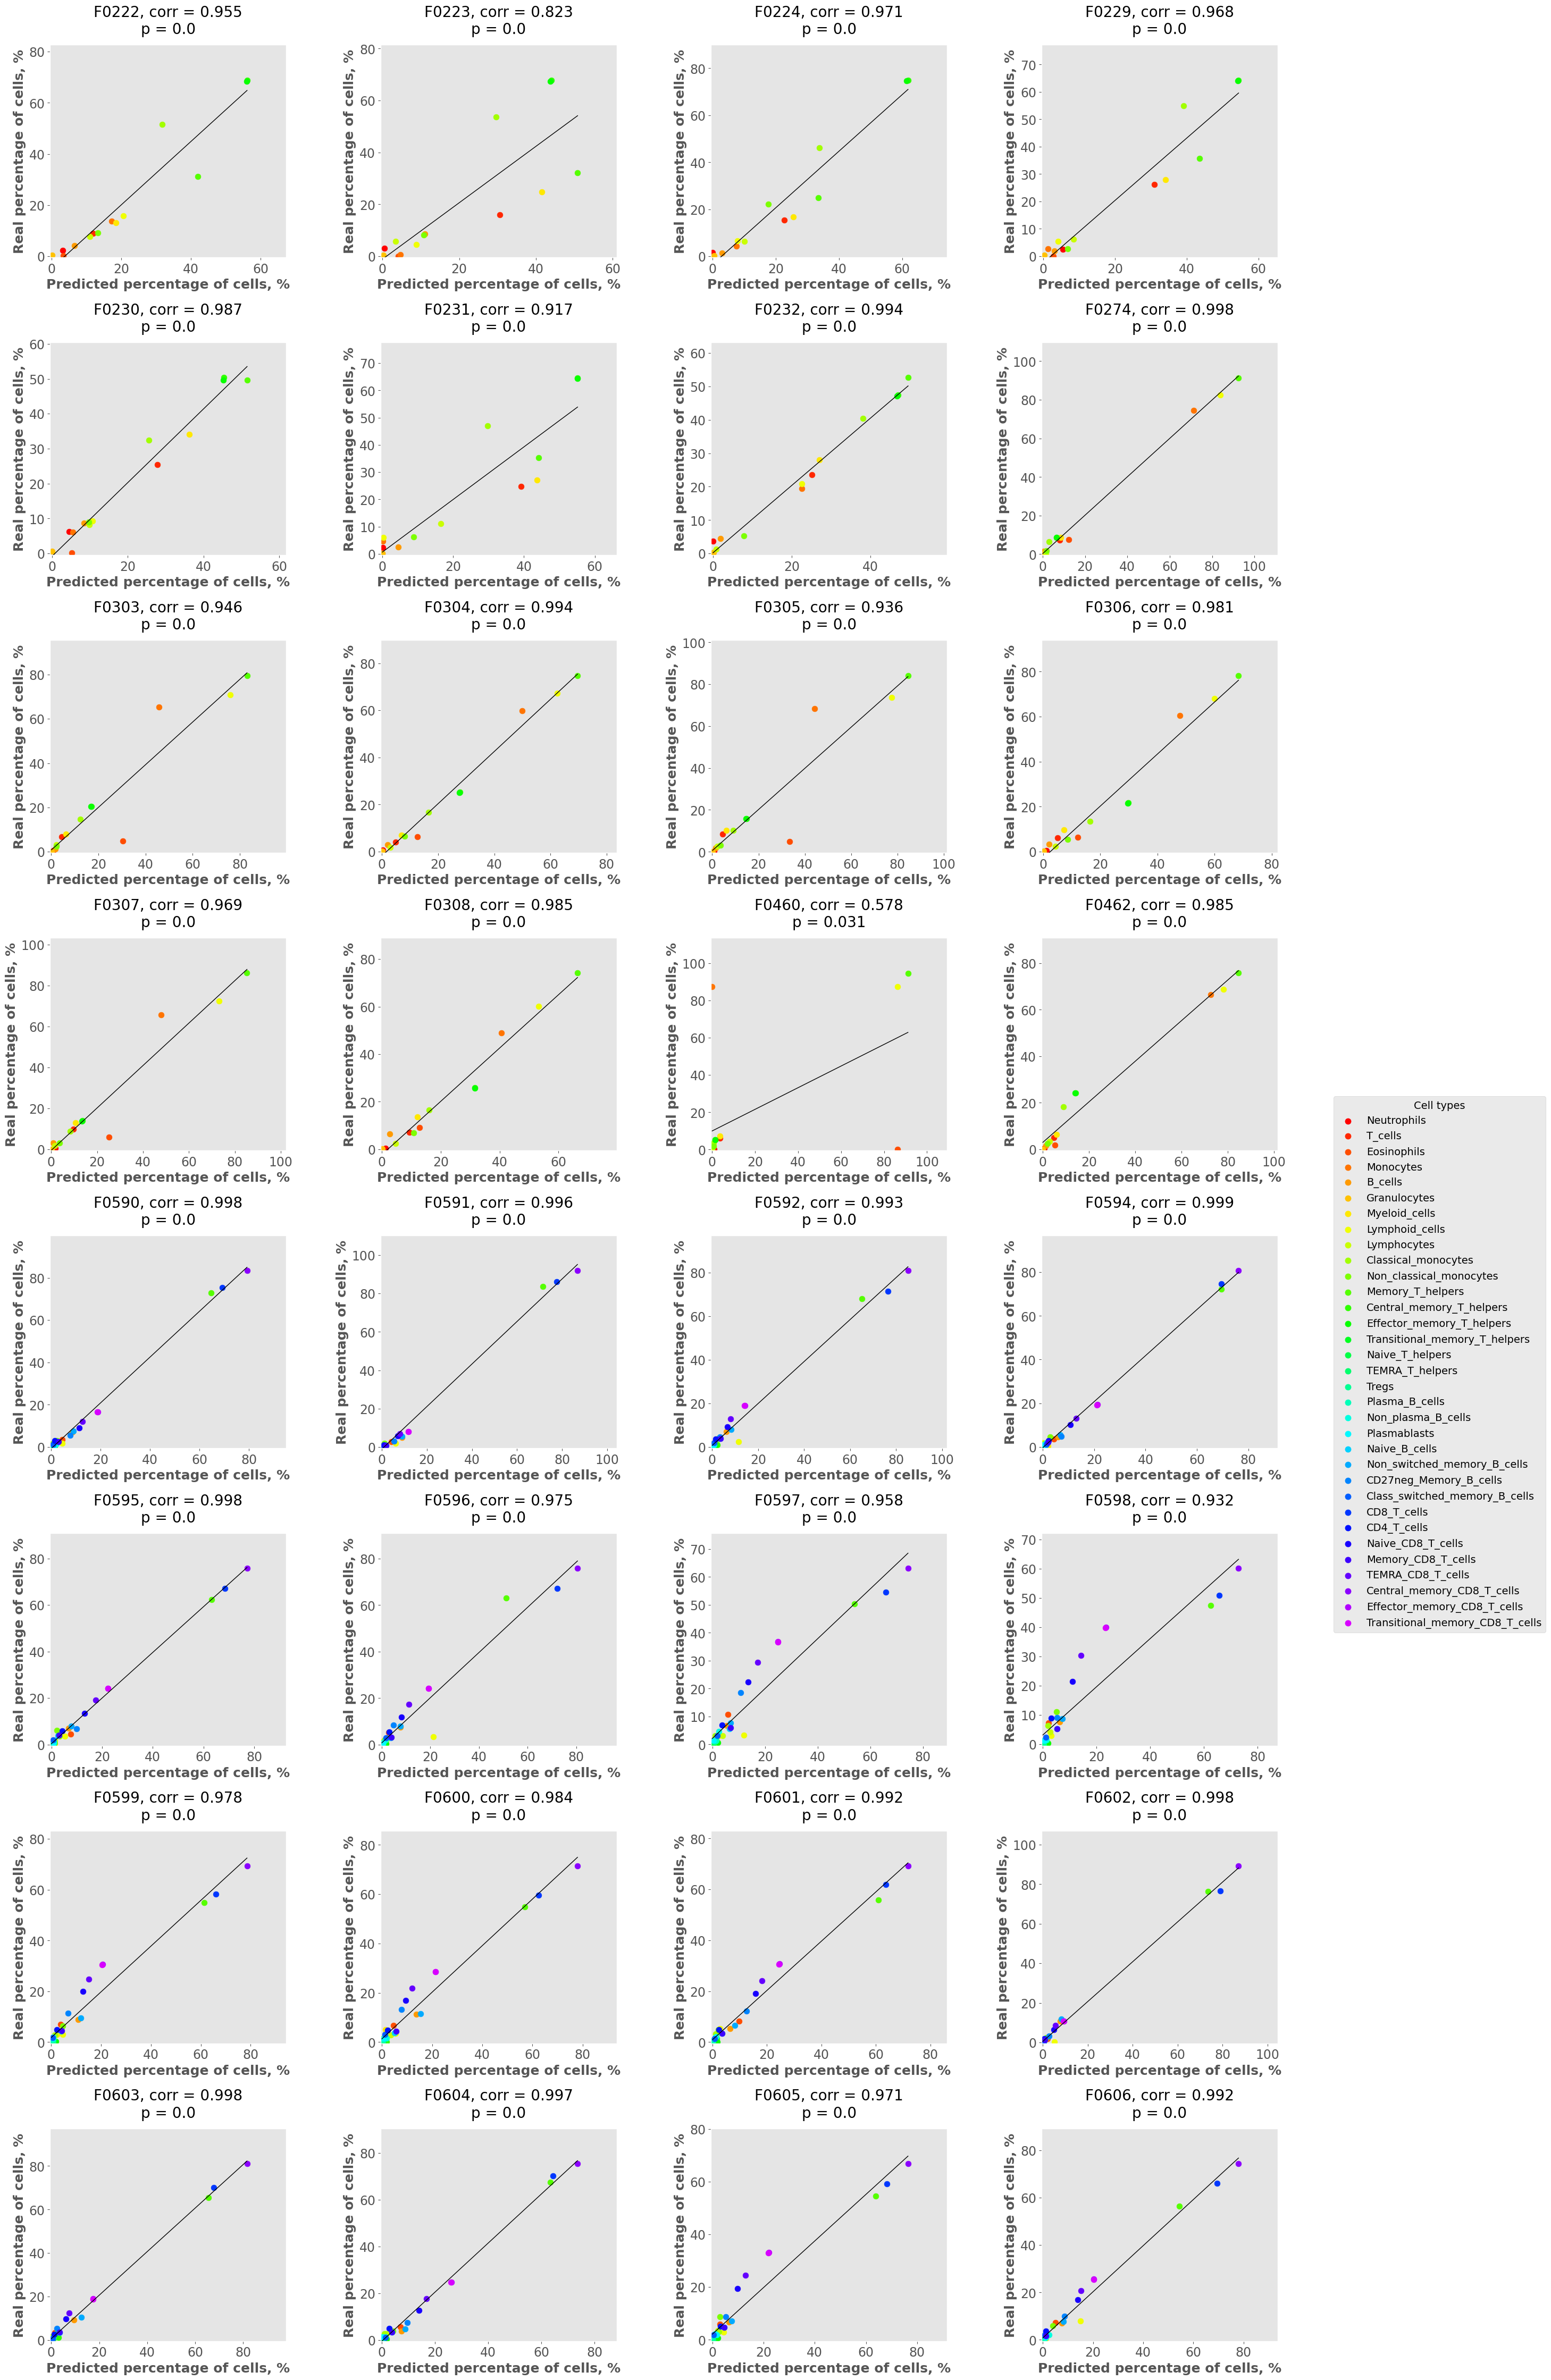

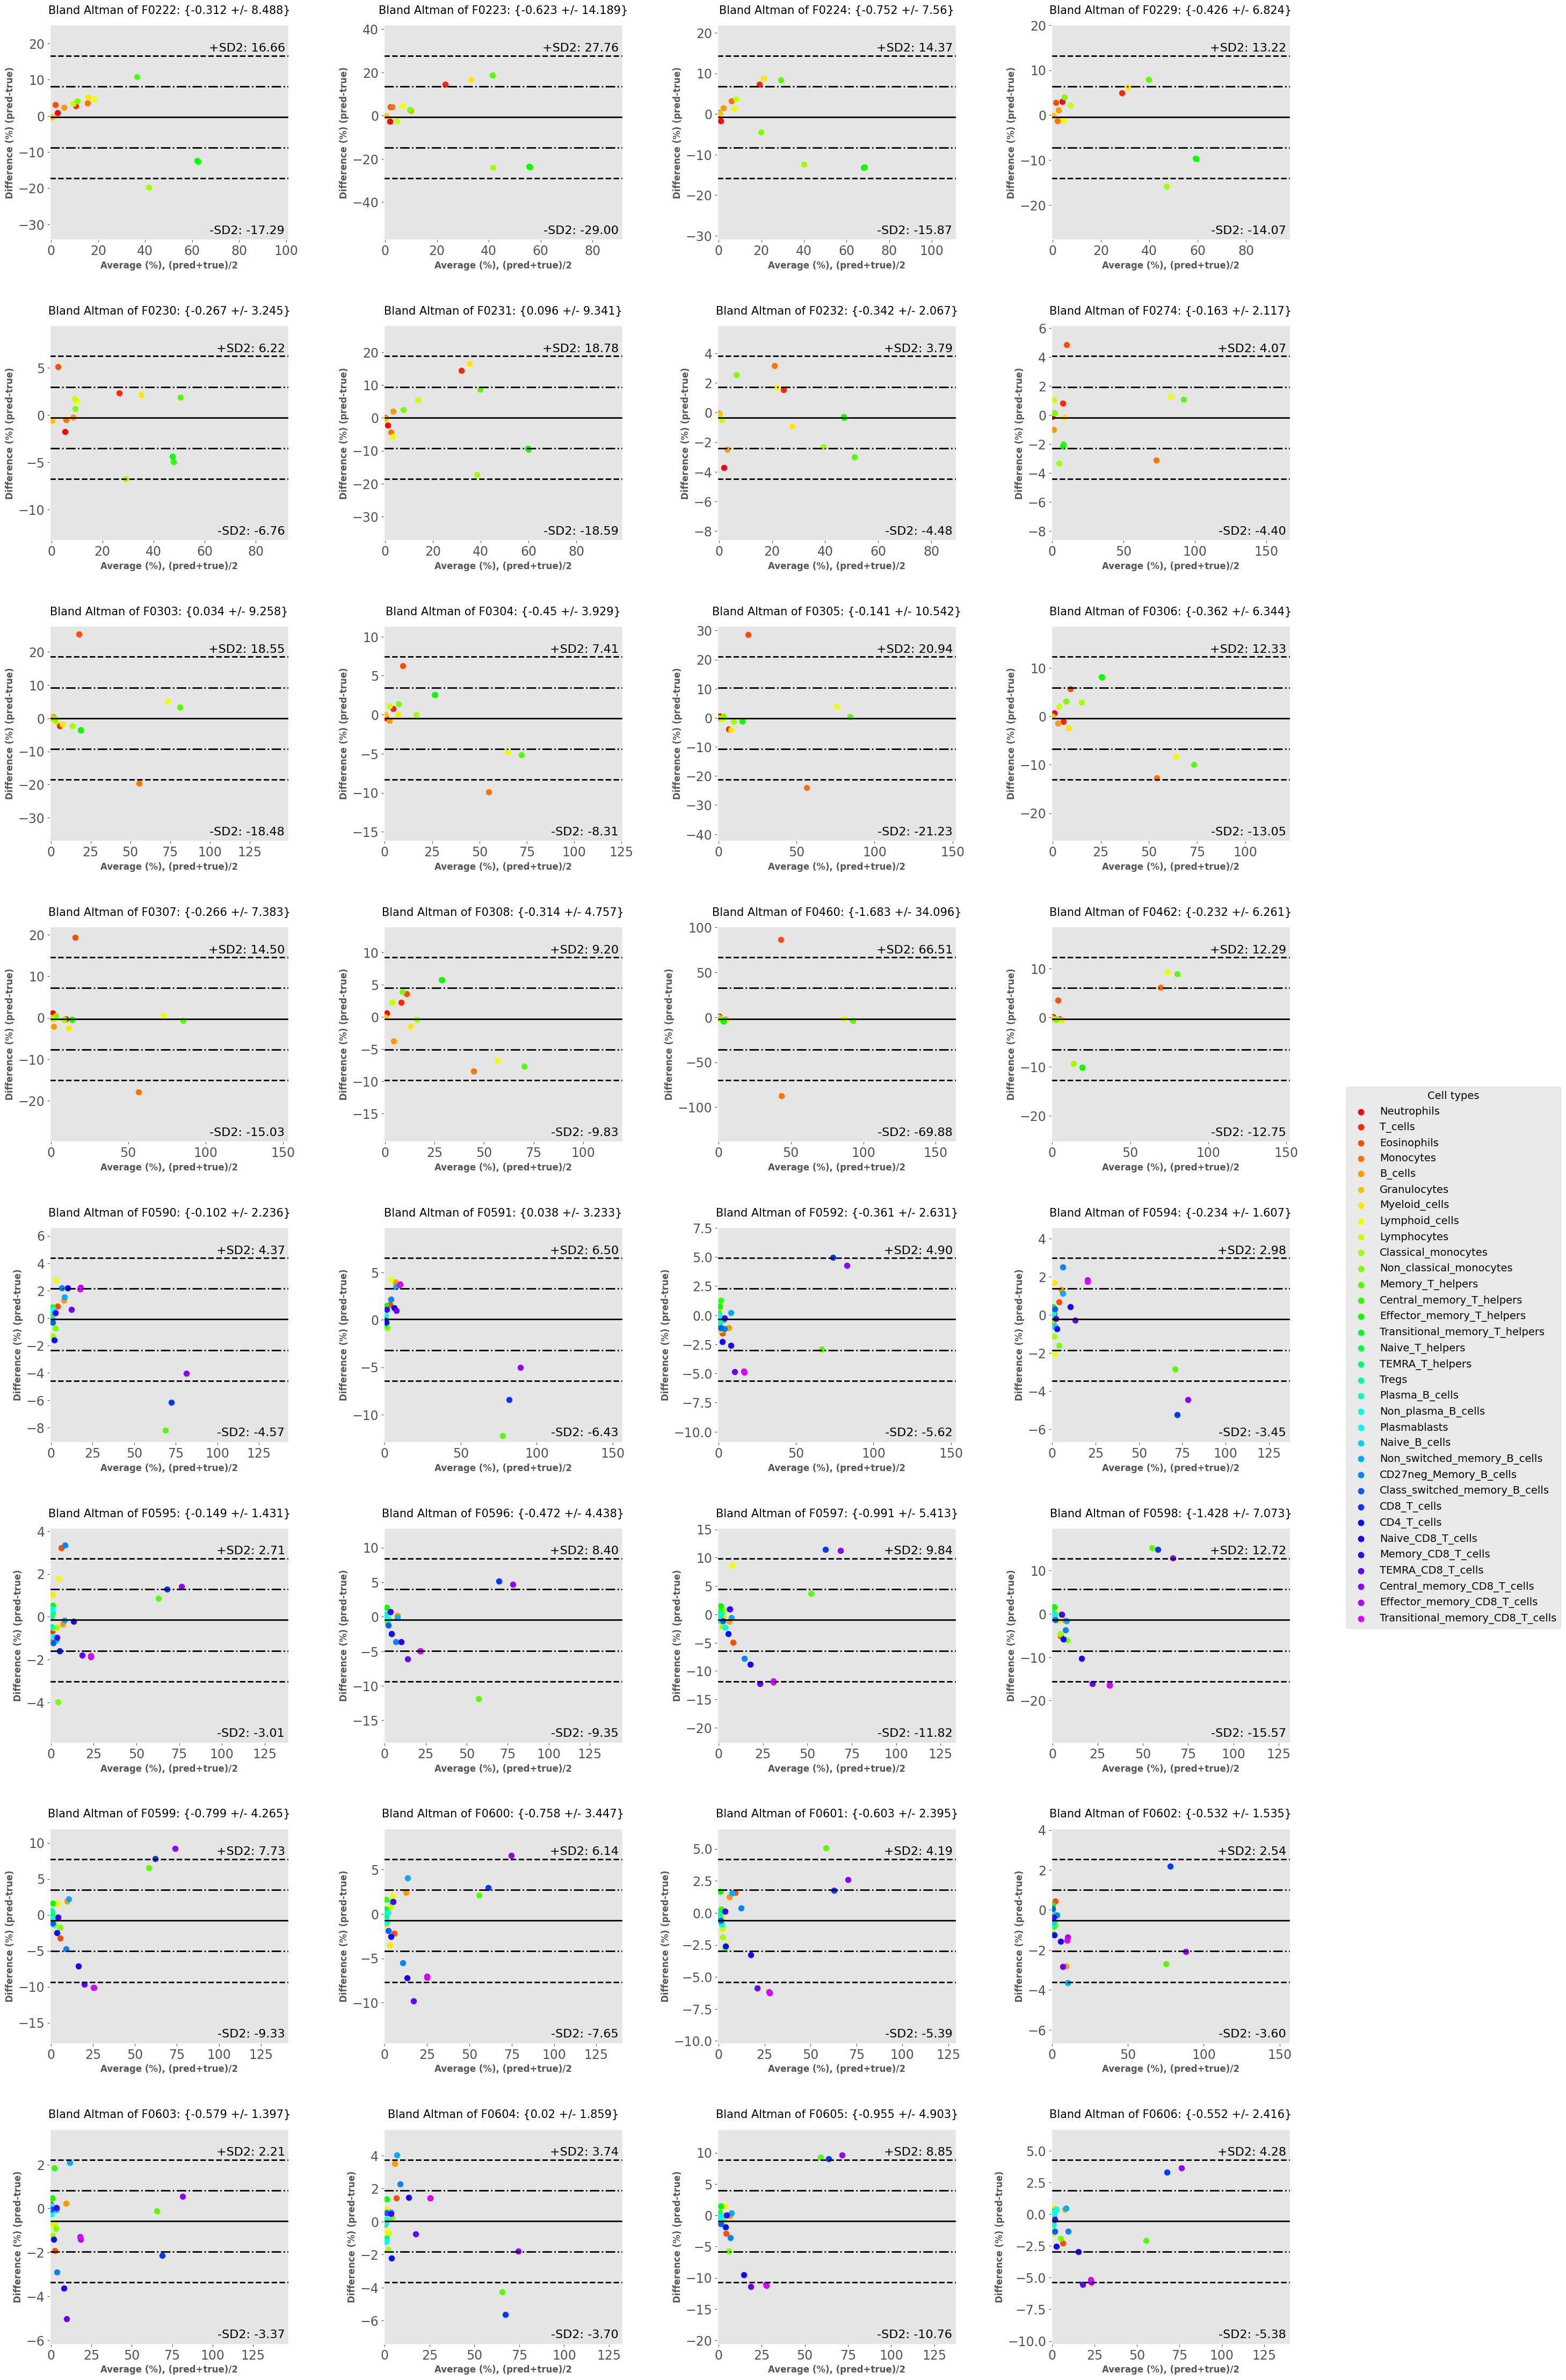

In [207]:
# get a color pallete for color samples
ind_names = k_preds2_100.index.intersection(cytof2.index)
sample_color = plotter.get_cmap(len(ind_names))
plotter.plot_sample(k_preds2_100, cytof2, pallete = sample_color, specific_col='F0598')
plotter.bland_altman_v2(k_preds2_100, cytof2, pallete = sample_color,specific_col='F0598')

#### SVR

In [17]:
signature = pd.read_csv('../src/cellanneal/examples/example_data/sc_PBMC_gene_mean_signature.csv',index_col=0)
bulk2 = pd.read_csv('../src/Kassandra/data/GSE107572_expr.tsv.tar.gz',sep='\t',index_col=0)
bulk = pd.read_csv('../src/Kassandra/trainingData/laboratory_data_expressions.tsv', sep='\t', index_col=0)

In [23]:
set1 = set(bulk.index)
set2 = set(bulk2.index)
set3 = set(signature.index)
intersection = (set1.intersection(set2)).intersection(set3)
inter = list(intersection)

In [25]:
signature = signature.filter(items=inter,axis=0)
bulk = bulk.filter(items=inter,axis=0)
bulk2 = bulk2.filter(items=inter,axis=0)

In [26]:
print(signature.shape, bulk.shape, bulk2.shape)

(12995, 18) (12995, 348) (12995, 9)


In [28]:
scaler = StandardScaler()
  
# transform data
train  = scaler.fit_transform(signature)
test_data = scaler.fit_transform(bulk2)
ind = bulk2.columns

In [29]:
genes = bulk.index
ind = bulk2.columns
Nus=[0.25, 0.5, 0.75, 1.0]

SVRcoef = np.zeros((signature.shape[1], bulk2.shape[1]))
Selcoef = np.zeros((bulk.shape[0], bulk2.shape[1]))

for i in tqdm(range(bulk2.shape[1])):
    sols = [NuSVR(kernel='linear', nu=nu).fit(train,test_data[:,i]) for nu in Nus]
    im_name = signature.columns
    RMSE = [mse(sol.predict(train), test_data[:,i]) for sol in sols]
    Selcoef[sols[np.argmin(RMSE)].support_, i] = 1
    SVRcoef[:,i] = np.maximum(sols[np.argmin(RMSE)].coef_,0)
    SVRcoef[:,i] = SVRcoef[:,i]/np.sum(SVRcoef[:,i])
svr_preds = pd.DataFrame(SVRcoef,index=im_name, columns=ind)
svr_preds = svr_preds.reindex(sorted(svr_preds.columns), axis=1)
svr_preds

100%|██████████| 9/9 [54:35<00:00, 363.89s/it]


SRR6337113  SRR6337114  SRR6337115  SRR6337116  SRR6337117  \
CD4-naive        0.399582    0.441363    0.351477    0.303954    0.380076   
CD14             0.182677    0.136131    0.164366    0.224977    0.192985   
CD4              0.000000    0.000000    0.000000    0.000000    0.000000   
NK               0.000000    0.000000    0.010786    0.013730    0.000000   
CD8              0.000000    0.000000    0.000000    0.006621    0.000000   
CD16             0.000000    0.010747    0.029749    0.034710    0.004902   
B-naive          0.000000    0.000000    0.011661    0.011586    0.000000   
Treg             0.035940    0.030379    0.000000    0.000000    0.038009   
gdT              0.133152    0.121486    0.174973    0.169019    0.125397   
CD8-naive        0.000000    0.000000    0.000000    0.000000    0.000000   
B                0.016894    0.023751    0.030324    0.022723    0.019363   
T_undef          0.026471    0.035942    0.027631    0.005356    0.010912   
cDC              0.068057    0.064318    0.045831    0.060277    0.081960   
platelet_cont    0.024421    0.020091    0.020516    0.024637    0.029544   
CD14-PPBP        0.000000    0.000000    0.000000    0.000000    0.000000   
HSC              0.000000    0.000000    0.000000    0.000000    0.000000   
pDC              0.000000    0.000000    0.000000    0.000000    0.000000   
other            0.112806    0.115792    0.132686    0.122410    0.116853   

               SRR6337118  SRR6337119  SRR6337120  SRR6337121  
CD4-naive        0.384210    0.355094    0.367755    0.398894  
CD14             0.145022    0.176574    0.172519    0.142092  
CD4              0.000000    0.000000    0.000000    0.000000  
NK               0.008080    0.015376    0.000000    0.002833  
CD8              0.000000    0.000000    0.000000    0.000000  
CD16             0.025438    0.030176    0.023174    0.036862  
B-naive          0.003981    0.003840    0.014258    0.015820  
Treg             0.009918    0.019667    0.044143    0.016399  
gdT              0.165144    0.156014    0.104016    0.170740  
CD8-naive        0.000000    0.000000    0.000000    0.000000  
B                0.010499    0.008355    0.010164    0.002030  
T_undef          0.031094    0.011365    0.049431    0.010521  
cDC              0.072069    0.074758    0.074230    0.065432  
platelet_cont    0.021252    0.026343    0.023642    0.024010  
CD14-PPBP        0.000000    0.000000    0.000000    0.000000  
HSC              0.000000    0.000000    0.000000    0.000000  
pDC              0.000000    0.000000    0.000000    0.000000  
other            0.123292    0.122438    0.116668    0.114366

In [31]:
svr_preds_100 = svr_preds * 100

In [41]:
svr_preds_copy = svr_preds_100.copy()
svr_preds_copy.loc['B_cells'] = svr_preds_copy.loc[['B', 'B-naive']].sum()
svr_preds_copy.loc['CD4_T_cells'] = svr_preds_copy.loc[['CD4', 'CD4-naive']].sum()
svr_preds_copy.loc['CD8_T_cells'] = svr_preds_copy.loc[['CD8']].sum()
svr_preds_copy.loc['NK_cells'] = svr_preds_copy.loc[['NK']].sum()
svr_preds_copy.loc['Tregs'] = svr_preds_copy.loc[['Treg']].sum()
svr_preds_copy.loc['T_cells'] = svr_preds_copy.loc[['CD8_T_cells', 'CD4_T_cells', 'Tregs', 'T_undef']].sum()
svr_preds_copy.loc['Lymphocytes'] = svr_preds_copy.loc[['B_cells', 'T_cells', 'NK_cells']].sum()

In [43]:
svr_preds_copy

SRR6337113  SRR6337114  SRR6337115  SRR6337116  SRR6337117  \
CD4-naive       39.958195   44.136289   35.147710   30.395442   38.007552   
CD14            18.267730   13.613116   16.436588   22.497700   19.298504   
CD4              0.000000    0.000000    0.000000    0.000000    0.000000   
NK               0.000000    0.000000    1.078573    1.373003    0.000000   
CD8              0.000000    0.000000    0.000000    0.662123    0.000000   
CD16             0.000000    1.074710    2.974929    3.471018    0.490191   
B-naive          0.000000    0.000000    1.166065    1.158605    0.000000   
Treg             3.594044    3.037891    0.000000    0.000000    3.800933   
gdT             13.315173   12.148613   17.497304   16.901851   12.539716   
CD8-naive        0.000000    0.000000    0.000000    0.000000    0.000000   
B                1.689425    2.375100    3.032423    2.272260    1.936255   
T_undef          2.647095    3.594204    2.763105    0.535571    1.091248   
cDC              6.805657    6.431753    4.583103    6.027678    8.195973   
platelet_cont    2.442059    2.009116    2.051590    2.463725    2.954360   
CD14-PPBP        0.000000    0.000000    0.000000    0.000000    0.000000   
HSC              0.000000    0.000000    0.000000    0.000000    0.000000   
pDC              0.000000    0.000000    0.000000    0.000000    0.000000   
other           11.280622   11.579207   13.268611   12.241024   11.685268   
B_cells          1.689425    2.375100    4.198488    3.430865    1.936255   
CD4_T_cells     39.958195   44.136289   35.147710   30.395442   38.007552   
CD8_T_cells      0.000000    0.000000    0.000000    0.662123    0.000000   
NK_cells         0.000000    0.000000    1.078573    1.373003    0.000000   
Tregs            3.594044    3.037891    0.000000    0.000000    3.800933   
T_cells         46.199334   50.768384   37.910814   31.593135   42.899733   
Lymphocytes     47.888759   53.143484   43.187876   36.397004   44.835988   

               SRR6337118  SRR6337119  SRR6337120  SRR6337121  
CD4-naive       38.421006   35.509438   36.775495   39.889403  
CD14            14.502232   17.657434   17.251870   14.209220  
CD4              0.000000    0.000000    0.000000    0.000000  
NK               0.807999    1.537594    0.000000    0.283345  
CD8              0.000000    0.000000    0.000000    0.000000  
CD16             2.543776    3.017630    2.317425    3.686197  
B-naive          0.398124    0.383960    1.425829    1.582033  
Treg             0.991833    1.966673    4.414281    1.639863  
gdT             16.514428   15.601403   10.401574   17.074033  
CD8-naive        0.000000    0.000000    0.000000    0.000000  
B                1.049853    0.835520    1.016411    0.203038  
T_undef          3.109422    1.136479    4.943072    1.052066  
cDC              7.206944    7.475800    7.422955    6.543226  
platelet_cont    2.125194    2.634296    2.364239    2.401027  
CD14-PPBP        0.000000    0.000000    0.000000    0.000000  
HSC              0.000000    0.000000    0.000000    0.000000  
pDC              0.000000    0.000000    0.000000    0.000000  
other           12.329191   12.243773   11.666849   11.436550  
B_cells          1.447976    1.219480    2.442240    1.785071  
CD4_T_cells     38.421006   35.509438   36.775495   39.889403  
CD8_T_cells      0.000000    0.000000    0.000000    0.000000  
NK_cells         0.807999    1.537594    0.000000    0.283345  
Tregs            0.991833    1.966673    4.414281    1.639863  
T_cells         42.522261   38.612590   46.132848   42.581331  
Lymphocytes     44.778236   41.369664   48.575087   44.649747

In [44]:
flatten(svr_preds_copy, cytof1)

Index(['B_cells', 'CD4_T_cells', 'CD8_T_cells', 'NK_cells', 'Tregs', 'T_cells',
       'Lymphocytes'],
      dtype='object')
Index(['SRR6337113', 'SRR6337114', 'SRR6337115', 'SRR6337116', 'SRR6337117',
       'SRR6337118', 'SRR6337119', 'SRR6337120', 'SRR6337121'],
      dtype='object')


array([[<AxesSubplot: title={'center': 'B_cells, corr = -0.105\np = 0.789'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD4_T_cells, corr = 0.529\np = 0.143'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'CD8_T_cells, corr = 0.594\np = 0.092'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'Lymphocytes, corr = -0.119\np = 0.76'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>],
       [<AxesSubplot: title={'center': 'NK_cells, corr = 0.265\np = 0.491'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center': 'T_cells, corr = -0.032\np = 0.935'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>,
        <AxesSubplot: title={'center

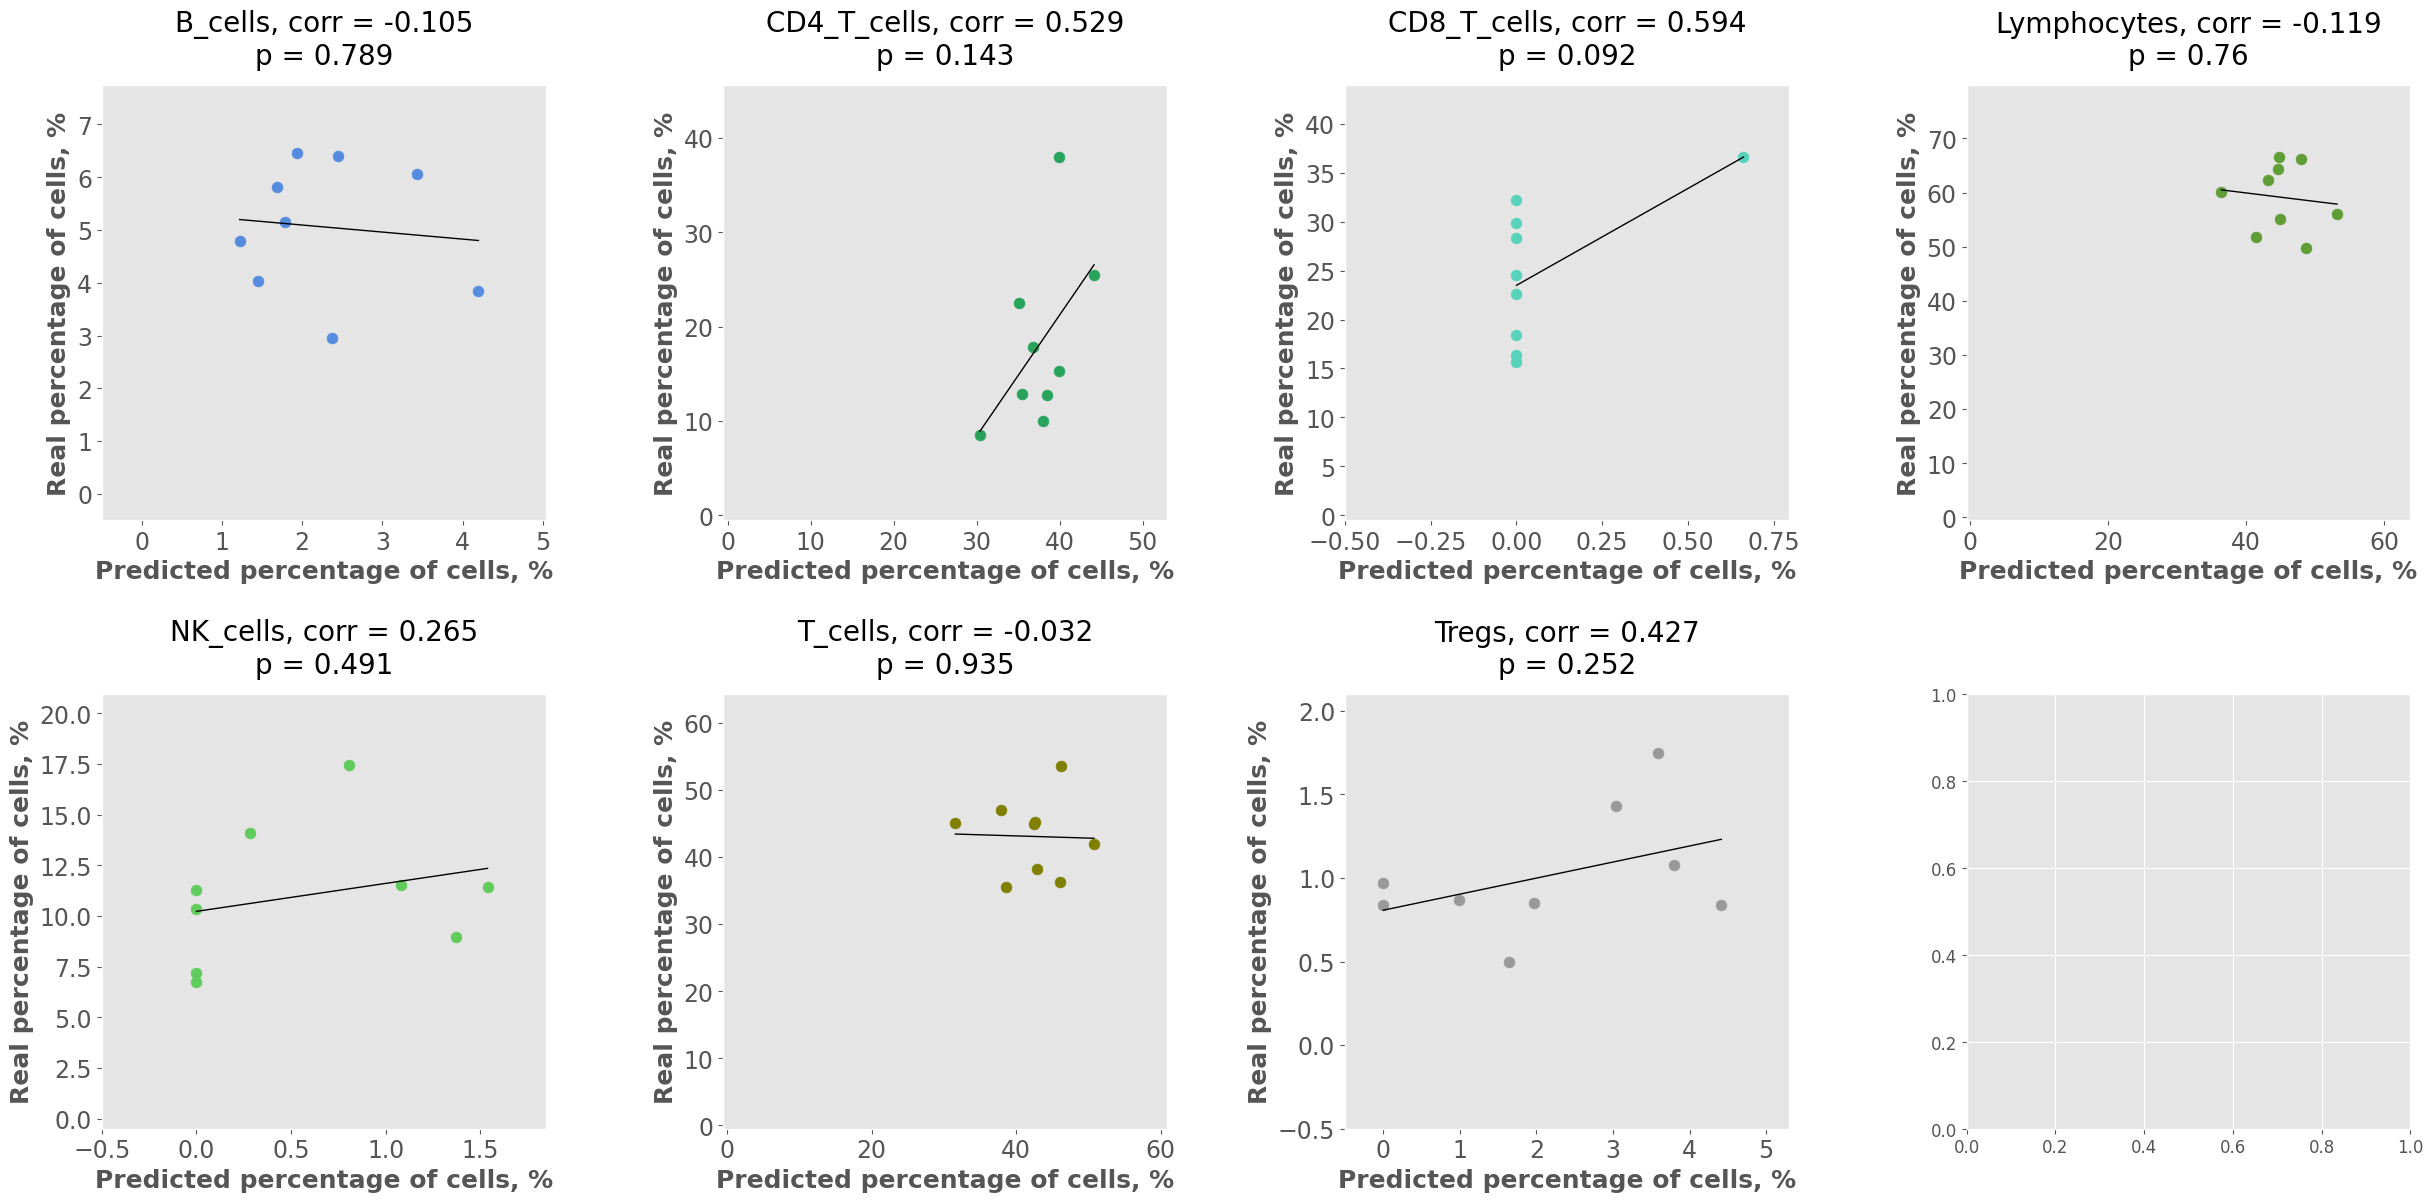

In [45]:
plotter.corr_plot(svr_preds_copy, cytof1, pallete=cells_p)

Statistical Tests
------------------------
RMSE: 14.895 
Pearson Correlation Coefficient: 0.757 
P value: 0.0 
R^2: 0.462


<AxesSubplot: title={'center': 'GSE107572'}, xlabel='Predicted percentage of cells, %', ylabel='Real percentage of cells, %'>

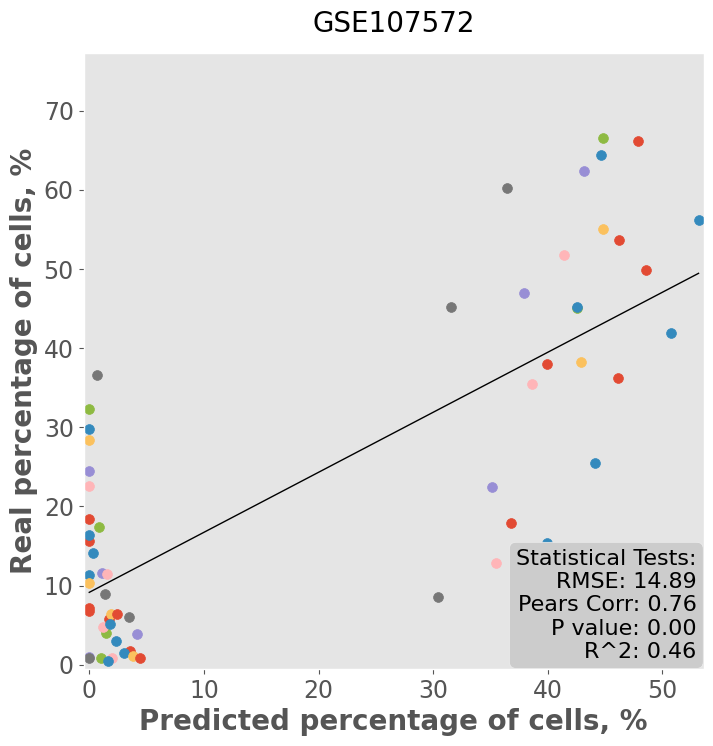

In [47]:
title = 'GSE107572'
plotter.print_cell_whole(svr_preds_copy, cytof1, pallete = cells_p, title=title, stat=True)

array([[<AxesSubplot: title={'center': 'Bland Altman of B_cells: {-2.776 +/- 1.655}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD4_T_cells: {19.442 +/- 7.954}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of CD8_T_cells: {-24.881 +/- 7.235}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of Lymphocytes: {-14.176 +/- 8.245}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>],
       [<AxesSubplot: title={'center': 'Bland Altman of NK_cells: {-10.441 +/- 3.227}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <AxesSubplot: title={'center': 'Bland Altman of T_cells: {-0.959 +/- 8.159}'}, xlabel='Average (%), (pred+true)/2', ylabel='Difference (%) (pred-true)'>,
        <Ax

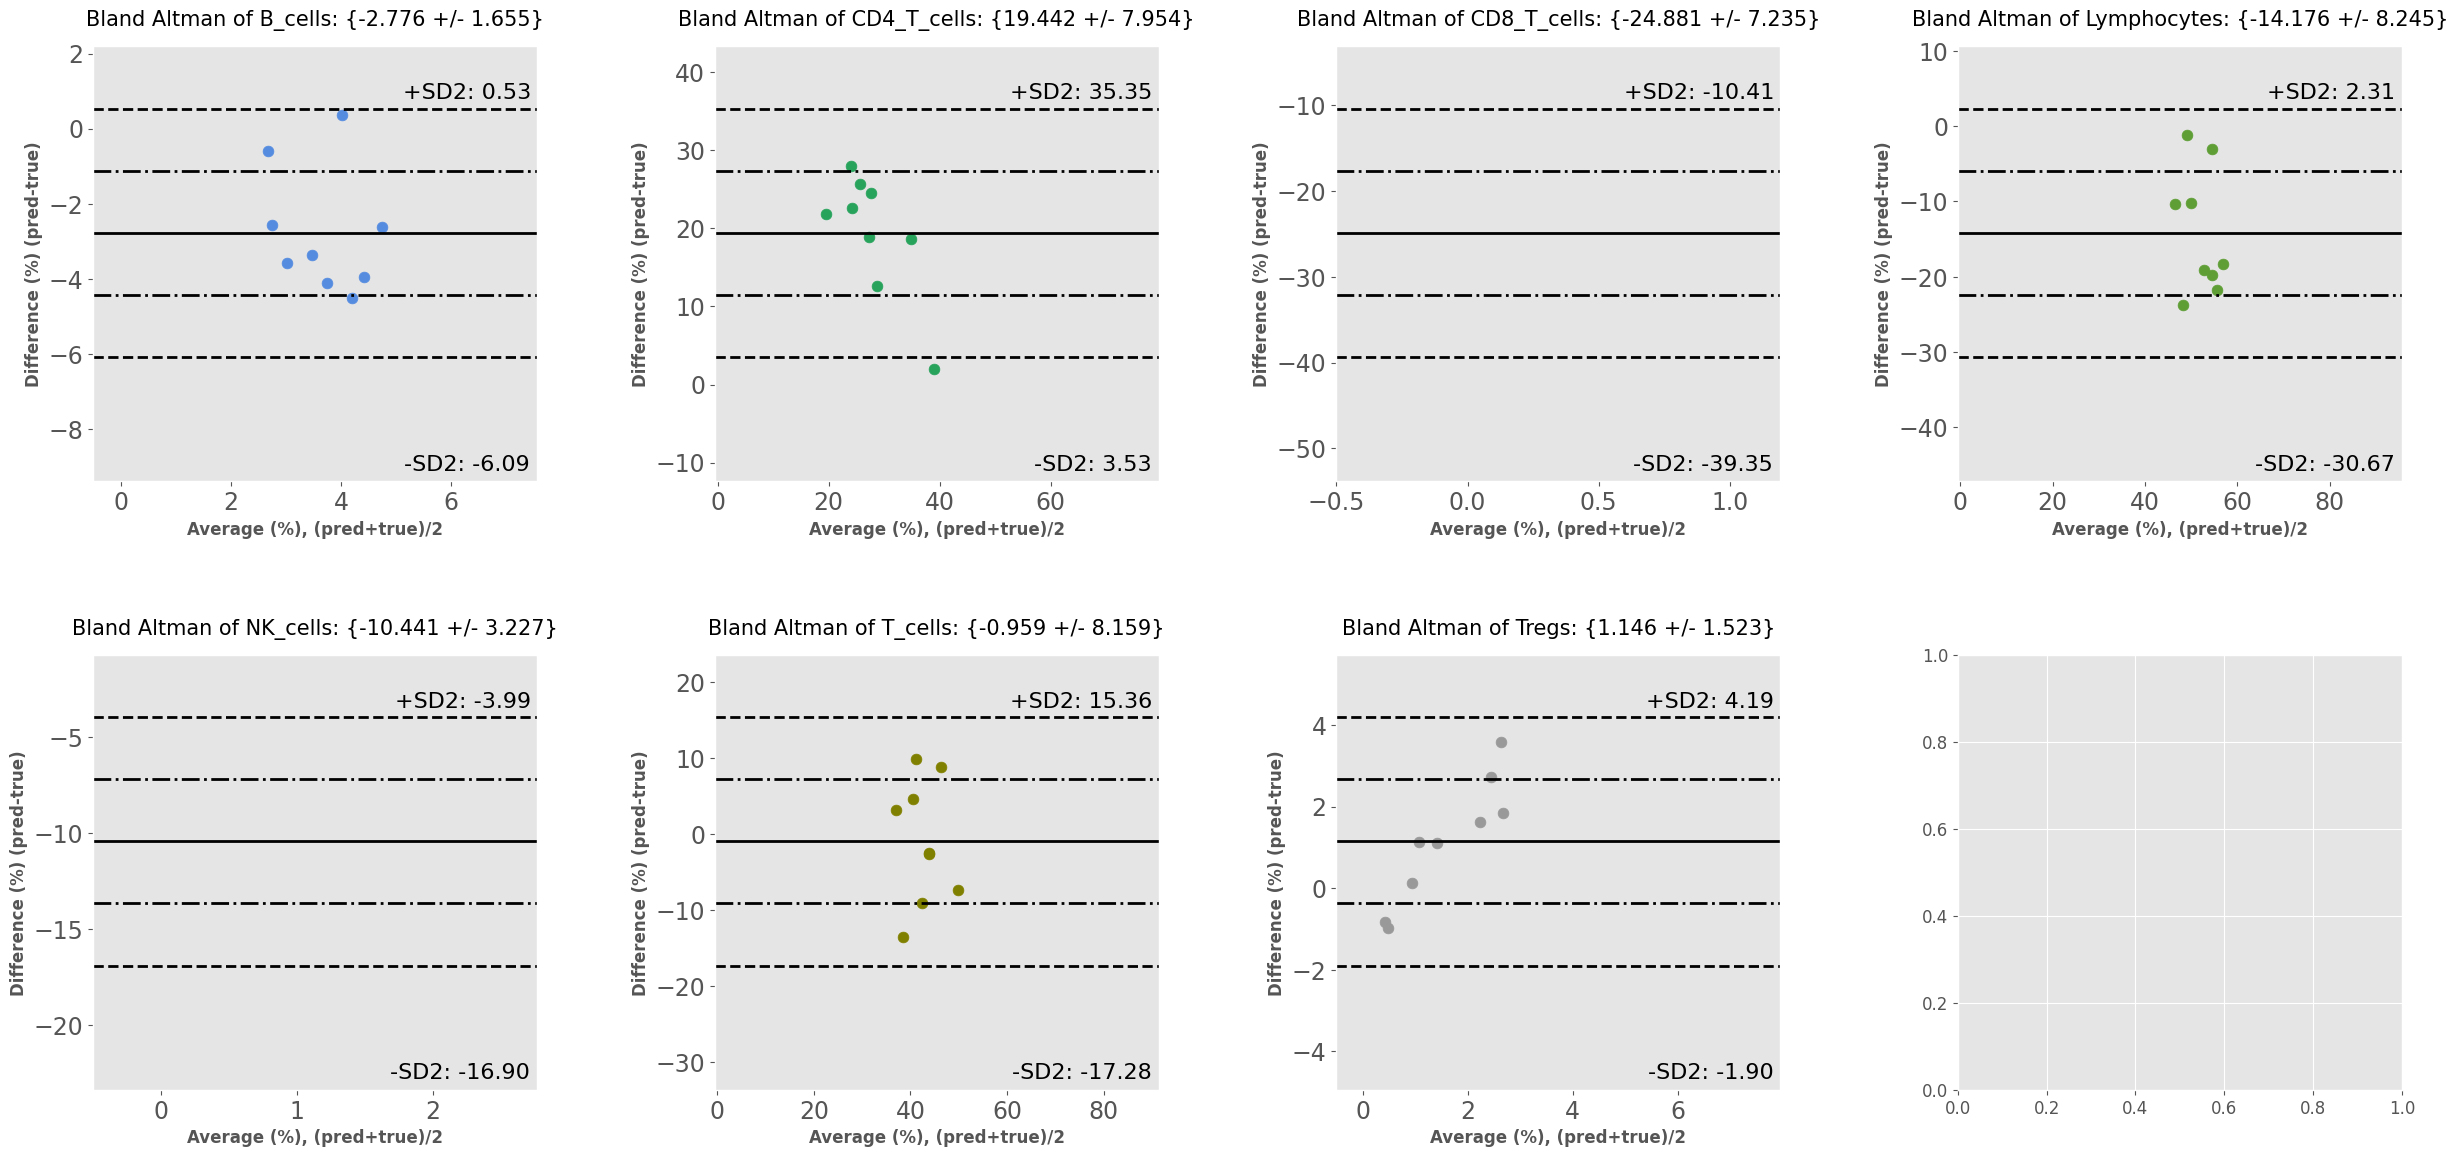

In [48]:
plotter.bland_altman(svr_preds_copy, cytof1, pallete = cells_p)

# Methods to score which method performed the best

#### TODO
- Takes the difference, of true and predicted between cell types. The most with the lowest difference wins
- Make benchmarking plot that takes in a list of dataframes as input, takes the RMSE & Pearson between every sample and forms a plot where each datapoint is the RMSE and corrlation.